# Example of GITIII usage in the MERFISH mouse brain dataset

In this tutorial, we demonstrate the functionalities of the cell-cell interaction (CCI) analyzing tool GITIII in:
1. Estimating the influence tensor that describe how each cell is influenced by its top k (default 50) nearest neighbors
2. Visualizing the relationship between the strength of interaction with the distance between two cells
3. Visualizing the functions of CCI pairs using UMAP: the pair of one sender cell influencing one receiver cell is called a CCI pair, and the estimated influence from the sender cell to the receiver cell (how much the gene expression in the receiver cell would change because of the existing of the sender cell) are treated as the features of the CCI pair. This function aim to visualize how different CCI pairs belonging to different cell type combinations differ from each other in terms of their functions
4. Prediction visualization: visualize the predicted cell expression v.s. predicted expression, can be state expression (have negative values) or raw expression (>0)
5. Information flow: Where are the strongest CCI pairs in the slide (tissue section), with arrows in the plot indicating the interaction from one sender cell to one receiver cell
6. Cell subtyping analysis: We first construct interpretable CCI-informed features for each cell, (how each cell type influence each measured genes in this cell), use these features to do Leiden clustering and UMAP visualization. Then differential expressed gene (DEG) analysis can be performed on these subtypes (subgroups), and we can also visualize how this cell ('s one target gene) is influenced by other cell types via heatmap.
7. Network analysis: Using partial linear regression to make statistical test of whether one cell type significantly influence one gene in the receiver cell type, forming a significant CCI network targeting each gene.

**It would roughly take 1.5 hours for the computer to run all the codes in this tutorial (under the selected batch size and A5000 24G GPU).**

# Data downloading

This dataset contains 254 genes measured in 284,098 cells across 64 slices from two mice, with annotations of 24 cell types. We used slice 201 from mouse 1 with 6,137 cells for demonstration. The dataset is published at https://www.nature.com/articles/s41586-021-03705-x.

A processed dataset is available at https://drive.google.com/file/d/1IEQu_ce2KEghqY3aAL13ogJpudSOSurh/view?usp=sharing

Suppose the data is downloaded at the working directory with name "./mouse.csv"

If you want to use your own data, the dataframe you input should have the following columns:

- genes (more than one column), as described below, these columns form the expression matrix. Values in these columns must be int or float
- "centerx": x coordinates of the cells. int or float
- "centery": y coordinates of the cells. int or float
- "section": which tissue slide this cell belongs to, since a dataset may contain more than one slide. string
- "subclass": the cell type annotation for this cell. string

You also need a list of measured genes in the dataset, like the code block below:

In [1]:
genes=['1700022I11Rik', '1810046K07Rik', '5031425F14Rik', '5730522E02Rik', 'Acta2', 'Adam2', 'Adamts2', 'Adamts4', 'Adra1b', 'Alk', 'Ankfn1', 'Ano4', 'Aqp4', 'Asic4', 'B4galnt2', 'B4galnt3', 'Barx2', 'Bcl11b', 'Bdnf', 'Bgn', 'Blnk', 'Bmpr1b', 'Brinp3', 'C1ql3', 'C1qtnf7', 'Cacng5', 'Calb2', 'Camk2d', 'Car3', 'Cbln2', 'Cbln4', 'Ccbe1', 'Ccdc162', 'Ccdc3', 'Ccdc80', 'Ccnb1', 'Cd14', 'Cd24a', 'Cdca7', 'Cdcp1', 'Cdh12', 'Cdh13', 'Cdh20', 'Cdh9', 'Ceacam9', 'Cemip', 'Chat', 'Chn2', 'Chodl', 'Chrm2', 'Chrna2', 'Cldn5', 'Clrn1', 'Cntnap5b', 'Cobll1', 'Col14a1', 'Col15a1', 'Col23a1', 'Col24a1', 'Col25a1', 'Corin', 'Cplx3', 'Crhr2', 'Crispld2', 'Cspg4', 'Ctss', 'Cux2', 'Cxcl14', 'Daam2', 'Dmkn', 'Dnase1l3', 'Dscaml1', 'Egfem1', 'Egfr', 'Egln3', 'Egr2', 'Elfn1', 'Enpp6', 'Epha7', 'Fam19a2', 'Fam84b', 'Fbxl7', 'Fezf2', 'Flrt3', 'Flt1', 'Fndc7', 'Fosb', 'Foxp2', 'Frem2', 'Fst', 'Gfap', 'Glra1', 'Gpc6', 'Grik1', 'Grin3a', 'Grm1', 'Grm8', 'Hpse', 'Hs3st5', 'Igf2', 'Igfbp4', 'Igfbp5', 'Ikzf2', 'Il1rapl2', 'Il4ra', 'Inpp4b', 'Iqgap2', 'Itgb8', 'Kcng1', 'Kcnj8', 'L3mbtl4', 'Lama3', 'Lhx6', 'Lmo1', 'Lsp1', 'Ltf', 'Luzp2', 'Lypd1', 'Lyzl4', '1-Mar', 'Marcksl1', 'Meis2', 'Moxd1', 'Mrc1', 'Mrgprx2', 'Muc20', 'Myh14', 'Ndst4', 'Nhs', 'Nkain3', 'Nnmt', 'Nos1', 'Npas1', 'Npnt', 'Npsr1', 'Npy2r', 'Nr2f2', 'Nr4a1', 'Nr4a2', 'Ntng2', 'Nxph1', 'Nxph2', 'Nxph4', 'Olah', 'Olfm3', 'Opalin', 'Oprk1', 'Osr1', 'Otof', 'Parm1', 'Pcdh8', 'Pde11a', 'Pdgfc', 'Pdgfra', 'Pdlim5', 'Phactr2', 'Plch1', 'Plcxd3', 'Pld5', 'Plekhg3', 'Pou3f1', 'Pou3f3', 'Pou6f2', 'Prdm8', 'Prok2', 'Prokr2', 'Prox1', 'Prr16', 'Prss12', 'Prss23', 'Ptger3', 'Ptprk', 'Ptprm', 'Ptprt', 'Ptpru', 'Pxdc1', 'Ramp1', 'Reln', 'Rerg', 'Rfx3', 'Rgs5', 'Rgs6', 'Rnf152', 'Ror1', 'Rorb', 'Rspo1', 'Rxfp1', 'Rxfp2', 'Satb2', 'Scgn', 'Sema3e', 'Sema5a', 'Serpinf1', 'Sertm1', 'Sgcd', 'Shisa9', 'Slc17a6', 'Slc17a8', 'Slc25a13', 'Slc30a3', 'Slc32a1', 'Slc44a5', 'Slco5a1', 'Sncg', 'Sox10', 'Sox6', 'Sp8', 'Spon1', 'St6galnac5', 'Sulf1', 'Sulf2', 'Syndig1', 'Syt10', 'Syt6', 'Tbc1d4', 'Tcap', 'Teddm3', 'Tenm3', 'Th', 'Thbs2', 'Thsd7a', 'Timp3', 'Tmem163', 'Tmtc2', 'Tnfaip6', 'Tox', 'Trp53i11', 'Trpc4', 'Trpc6', 'Tshz2', 'Tunar', 'Ubash3b', 'Unc13c', 'Unc5b', 'Unc5d', 'Ust', 'Vipr2', 'Vtn', 'Vwc2', 'Wipf3', 'Wnt7b', 'Zfp804b', 'Vip', 'Calb1', 'Gad2', 'Tac2', 'Lamp5', 'Cnr1', 'Pvalb', 'Sst', 'Rab3b', 'Slc17a7', 'Penk', 'Gad1']

# Init the model

Note that the data has alreadly been normalized, so set `use_log_normalize=False`

In [2]:
# Import necessary python packages
import gitiii

estimator=gitiii.estimator.GITIII_estimator(df_path="./mouse.csv",genes=genes,use_log_normalize=False,species="mouse",use_nichenetv2=True,visualize_when_preprocessing=False,distance_threshold=80,process_num_neighbors=50,num_neighbors=50,batch_size_train=256,lr=1e-4,epochs=50,node_dim=256,edge_dim=48,att_dim=8,batch_size_val=256,use_cell_type_embedding=True)

## Introduction of the parameters used in the code block above:

**Except for `df_path`, `genes`, `use_log_normalize`, and `species`, you can feel good to use all other hyperparameters by default as shown above, so generally speaking, you only need to fill in 4 parameters and prepare your own dataset and all other steps will be done automatically**

### Data you must input:

:param `df_path`: str, the path of your dataset, which should be a .csv file with columns of:
- genes (more than one column), as described below, these columns form the expression matrix.
            values in these columns must be int or float
- "centerx": x coordinates of the cells. int or float
- "centery": y coordinates of the cells. int or float
- "section": which tissue slide this cell belongs to, since a dataset may contain more than one slide. string
- "subclass": the cell type annotation for this cell. string

:param `genes`: list of str, a python list of measured gene names in the dataset

:param `use_log_normalize`: bool, whether to perform log-normalization log2(x+1) here for the expression matrix

- Attention: If you would like to use your own way of data normalization or have already normalized your expression matrix in the dataframe, choose False

:param `species`: str, what is the species of your dataset, must be one of "human" or "mouse"

---

### Hyperparameter settings (you can use the default one):

:param `use_nichenetv2`: bool, whether or not to include the ligands from nichenetv2, if not, only ligand-receptor pair from cellchat and neuronchat will be used, default to True

:param `visualize_when_preprocessing`: bool, whether to visualize the ST dataset when preprocessing, default to false.

:param `distance_threshold`: float or int, if the distance between one cell and its nearest neighbor isabove this threshold, then we think this cell is moved during the preparation of the tissue slide in the wet lab experiment, we would not include this cell in the analysis

:param `process_num_neighbors`: int, how many k-nearest neighbor are needed to be calculated in preprocessing, default to 50

:param `num_neighbors`: int, number of neighboring cells used to predict the cell state of the center cell, default to 50

:param `batch_size_train`: int, batch size at the training step, default to 256, increase it may accelerate the training but require higher GPU memory.

:param `lr`: learning rate, float, default to 1e-4

:param `epochs`: int, number of training rounds, default to 50, normally, a value between 25-35 is good, 50 is to make sure it would converge, but usually it would converge after 15 epoches.

:param `node_dim`: int, embedding dimension for node in the graph transformer, default to 256

:param `edge_dim`: int, embedding dimension for edge in the graph transformer, default to 48

:param `att_dim`: int, dimension needed to calculate for one-head attention, default to 8

:param `batch_size_val`: int, batch size at the evaluating step, default to 256

# Preprocess the dataset

This includes calculating the top 50 nearest neighbor for each cell, splitting the cell type expression and cell state expression, this step only use CPU and takes about 15 minutes. 

For the next 3 step, I recommend to use script instead of using interactive software like jupyter notebook since it would took hours to finish.

In [3]:
estimator.preprocess_dataset()

There are 47 ligands measured in this dataset
Doing log2(x+1) tranform
Finish doing log2(x+1) tranform
Splitting cell type expression and cell state expression


All variance 0.3562958612856235 type_variance 0.17622533910051008 0.4946039464635812 state_variance 0.18007052218516298 0.5053960535365579


Finish splitting cell type expression and cell state expression
processing: mouse1_slice1


Select 2351 cells from 2352 cells


processing: mouse1_slice10
Select 2393 cells from 2394 cells


processing: mouse1_slice102


Select 6636 cells from 6637 cells


processing: mouse1_slice112


Select 4920 cells from 4921 cells


processing: mouse1_slice122


Select 6082 cells from 6085 cells


processing: mouse1_slice131


Select 4994 cells from 4994 cells


processing: mouse1_slice153


Select 7517 cells from 7519 cells


processing: mouse1_slice162


Select 6868 cells from 6869 cells


processing: mouse1_slice170


Select 6354 cells from 6354 cells


processing: mouse1_slice180


Select 6173 cells from 6173 cells


processing: mouse1_slice190


Select 5636 cells from 5636 cells


processing: mouse1_slice200
Select 2169 cells from 2169 cells


processing: mouse1_slice201


Select 6137 cells from 6137 cells


processing: mouse1_slice21
Select 2010 cells from 2010 cells


processing: mouse1_slice212


Select 6447 cells from 6450 cells


processing: mouse1_slice221


Select 5696 cells from 5697 cells


processing: mouse1_slice232


Select 5288 cells from 5288 cells


processing: mouse1_slice241


Select 3990 cells from 3991 cells


processing: mouse1_slice251


Select 4368 cells from 4370 cells


processing: mouse1_slice260


Select 5656 cells from 5656 cells


processing: mouse1_slice271


Select 3855 cells from 3857 cells


processing: mouse1_slice283


Select 4255 cells from 4255 cells


processing: mouse1_slice291


Select 4394 cells from 4394 cells


processing: mouse1_slice301


Select 4345 cells from 4345 cells


processing: mouse1_slice31


Select 3065 cells from 3067 cells


processing: mouse1_slice313


Select 3853 cells from 3854 cells


processing: mouse1_slice326


Select 4102 cells from 4102 cells


processing: mouse1_slice40


Select 4100 cells from 4100 cells


processing: mouse1_slice50


Select 4285 cells from 4285 cells


processing: mouse1_slice62


Select 4719 cells from 4720 cells


processing: mouse1_slice71


Select 5665 cells from 5667 cells


processing: mouse1_slice81


Select 5181 cells from 5183 cells


processing: mouse1_slice91


Select 5575 cells from 5576 cells


processing: mouse2_slice1
Select 1687 cells from 1688 cells


processing: mouse2_slice10
Select 1151 cells from 1151 cells


processing: mouse2_slice109


Select 5137 cells from 5139 cells


processing: mouse2_slice119


Select 4970 cells from 4973 cells


processing: mouse2_slice129


Select 5091 cells from 5092 cells


processing: mouse2_slice139


Select 4155 cells from 4155 cells


processing: mouse2_slice151


Select 5003 cells from 5003 cells


processing: mouse2_slice160


Select 4477 cells from 4477 cells


processing: mouse2_slice169


Select 5151 cells from 5152 cells


processing: mouse2_slice189


Select 4365 cells from 4365 cells


processing: mouse2_slice20
Select 659 cells from 659 cells


processing: mouse2_slice201


Select 3719 cells from 3719 cells


processing: mouse2_slice209


Select 4357 cells from 4357 cells


processing: mouse2_slice219


Select 3526 cells from 3526 cells


processing: mouse2_slice229


Select 5016 cells from 5017 cells


processing: mouse2_slice249


Select 4068 cells from 4069 cells


processing: mouse2_slice261


Select 3527 cells from 3527 cells


processing: mouse2_slice270


Select 4070 cells from 4070 cells


processing: mouse2_slice280


Select 3835 cells from 3835 cells


processing: mouse2_slice289


Select 4319 cells from 4319 cells


processing: mouse2_slice300


Select 3755 cells from 3757 cells


processing: mouse2_slice309


Select 3240 cells from 3240 cells


processing: mouse2_slice31
Select 2019 cells from 2019 cells


processing: mouse2_slice319


Select 2764 cells from 2766 cells


processing: mouse2_slice40


Select 3153 cells from 3153 cells


processing: mouse2_slice50


Select 2876 cells from 2877 cells


processing: mouse2_slice61


Select 3270 cells from 3271 cells


processing: mouse2_slice70


Select 3999 cells from 3999 cells


processing: mouse2_slice79


Select 3821 cells from 3825 cells


processing: mouse2_slice90


Select 4886 cells from 4887 cells


processing: mouse2_slice99


Select 5191 cells from 5191 cells


# Train the deep learning model

This step require GPU, the batch_size and model hyperparameter in the above default estimator hyperparameters roughly require 5G GPU memory, if you want it to train faster, you can increase the batch_size.

The training takes about 1.5 hours in this dataset with A5000 24G. The model converges at about 20-th epoch, and the software will automatically save the best model with the lowest mean square error on the validation set.

For your own dataset, the computation time would increase linearly with the number of cells in the dataset and sqrt(number of measured genes in the dataset).

In [4]:
estimator.train()

Start loading the dataset
Have samples: 64 ['mouse1_slice1', 'mouse1_slice10', 'mouse1_slice102', 'mouse1_slice112', 'mouse1_slice122', 'mouse1_slice131', 'mouse1_slice153', 'mouse1_slice162', 'mouse1_slice170', 'mouse1_slice180', 'mouse1_slice190', 'mouse1_slice200', 'mouse1_slice201', 'mouse1_slice21', 'mouse1_slice212', 'mouse1_slice221', 'mouse1_slice232', 'mouse1_slice241', 'mouse1_slice251', 'mouse1_slice260', 'mouse1_slice271', 'mouse1_slice283', 'mouse1_slice291', 'mouse1_slice301', 'mouse1_slice31', 'mouse1_slice313', 'mouse1_slice326', 'mouse1_slice40', 'mouse1_slice50', 'mouse1_slice62', 'mouse1_slice71', 'mouse1_slice81', 'mouse1_slice91', 'mouse2_slice1', 'mouse2_slice10', 'mouse2_slice109', 'mouse2_slice119', 'mouse2_slice129', 'mouse2_slice139', 'mouse2_slice151', 'mouse2_slice160', 'mouse2_slice169', 'mouse2_slice189', 'mouse2_slice20', 'mouse2_slice201', 'mouse2_slice209', 'mouse2_slice219', 'mouse2_slice229', 'mouse2_slice249', 'mouse2_slice261', 'mouse2_slice270', 'm

There are totally 276336 cells in this dataset
Finish loading the dataset
Train loader length: 864
Validation loader length: 216


Start training


Training-> epoch: 0 step: 500 loss_all: 0.17139299935102462 loss_not_interaction: 0.17172163081169128 median PCC all: tensor(0.0977) median PCC_not_interact: tensor(0.0963) max PCC all: tensor(0.3997) max PCC_not_interact: tensor(0.4463)


Finish training, epoch: 0
Loss_all: 0.16754934686684497 ; Loss_not_interaction: 0.16782072307197032 median PCC all: tensor(0.1299) median PCC_not_interact: tensor(0.1315) max PCC all: tensor(0.4503) max PCC_not_interact: tensor(0.4856)
torch.return_types.topk(
values=tensor([0.1141, 0.0454, 0.0422, 0.0413, 0.0402, 0.0373, 0.0336, 0.0263, 0.0257,
        0.0251, 0.0247, 0.0219, 0.0211, 0.0209, 0.0137, 0.0137, 0.0137, 0.0137,
        0.0137, 0.0137, 0.0137, 0.0137, 0.0137, 0.0137, 0.0137, 0.0137, 0.0137,
        0.0137, 0.0137, 0.0137], device='cuda:0'),
indices=tensor([18,  5, 44, 20, 35, 40, 11, 38, 25,  2, 39, 27,  7, 45,  0,  1,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))


torch.return_types.topk(
values=tensor([0.2036, 0.1455, 0.0516, 0.0458, 0.0416, 0.0413, 0.0408, 0.0281, 0.0237,
        0.0212, 0.0204, 0.0198, 0.0193, 0.0169, 0.0168, 0.0137, 0.0131, 0.0119,
        0.0112, 0.0098, 0.0097, 0.0093, 0.0092, 0.0091, 0.0091, 0.0079, 0.0066,
        0.0065, 0.0065, 0.0065], device='cuda:0'),
indices=tensor([37, 26, 42, 22, 35, 40, 30, 11, 15, 43, 19, 29,  4,  6,  0,  2,  1, 34,
        45, 33, 48, 47, 24, 14, 46,  7, 41,  3,  5,  8], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0471, 0.0379, 0.0369, 0.0357, 0.0344, 0.0306, 0.0306, 0.0299, 0.0287,
        0.0279, 0.0262, 0.0244, 0.0239, 0.0231, 0.0218, 0.0208, 0.0197, 0.0194,
        0.0183, 0.0183, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176,
        0.0176, 0.0176, 0.0170], device='cuda:0'),
indices=tensor([47, 32, 26, 42, 40, 36, 35, 28, 37,  0, 29, 24, 27,  5, 44,  1,  3, 23,
         4, 45,  6, 11, 13, 15, 18, 25, 31, 38, 43, 19], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.2027, 0.1048, 0.0592, 0.0479, 0.0383, 0.0338, 0.0283, 0.0272, 0.0257,
        0.0248, 0.0236, 0.0207, 0.0200, 0.0157, 0.0155, 0.0139, 0.0109, 0.0090,
        0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
        0.0090, 0.0090, 0.0090], device='cuda:0'),
indices=tensor([19, 46, 37,  8,  3, 21, 47, 27, 45, 33, 29, 43,  5, 42, 48, 14, 40,  0,
         1,  2,  4,  6,  7,  9, 10, 11, 12, 13, 15, 16], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1381, 0.1098, 0.0303, 0.0274, 0.0274, 0.0255, 0.0238, 0.0234, 0.0218,
        0.0210, 0.0206, 0.0204, 0.0197, 0.0189, 0.0180, 0.0170, 0.0168, 0.0163,
        0.0162, 0.0161, 0.0160, 0.0160, 0.0160, 0.0159, 0.0159, 0.0159, 0.0159,
        0.0150, 0.0144, 0.0136], device='cuda:0'),
indices=tensor([43, 38, 32, 47,  6, 28,  4, 14, 48, 37, 45, 46, 40, 26, 34, 20, 17, 33,
        27, 24,  0,  2,  5, 15, 19, 39, 44, 21, 35, 36], device='cuda:0'))
torch.return_types.topk(
val

Finish validating, epoch: 0
Loss_all: 0.16103261536746113 ; Loss_not_interaction: 0.16132367912817885 median PCC all: tensor(0.1867) median PCC_not_interact: tensor(0.1876) max PCC all: tensor(0.5252) max PCC_not_interact: tensor(0.5402)
Best validation loss now: 0.16103261536746113


Training-> epoch: 1 step: 500 loss_all: 0.1592346113920212 loss_not_interaction: 0.1594601014852524 median PCC all: tensor(0.1988) median PCC_not_interact: tensor(0.2136) max PCC all: tensor(0.5393) max PCC_not_interact: tensor(0.5572)


Finish training, epoch: 1
Loss_all: 0.1585864095810663 ; Loss_not_interaction: 0.15885055477351503 median PCC all: tensor(0.2079) median PCC_not_interact: tensor(0.2211) max PCC all: tensor(0.5464) max PCC_not_interact: tensor(0.5616)
torch.return_types.topk(
values=tensor([0.1043, 0.0552, 0.0488, 0.0467, 0.0407, 0.0393, 0.0388, 0.0372, 0.0340,
        0.0322, 0.0299, 0.0285, 0.0240, 0.0205, 0.0120, 0.0120, 0.0120, 0.0120,
        0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120,
        0.0120, 0.0120, 0.0120], device='cuda:0'),
indices=tensor([18,  5, 44, 35, 20, 11, 40, 38,  2, 27, 25, 39, 45,  7,  0,  1,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1651, 0.1062, 0.0733, 0.0519, 0.0448, 0.0391, 0.0369, 0.0351, 0.0340,
        0.0274, 0.0245, 0.0231, 0.0188, 0.0181, 0.0174, 0.0140, 0.0124, 0.0122,
        0.0122, 0.0120, 0.0115, 0.0112, 0.0105, 0.0102, 0.0098, 0.0091, 0.0087,
       

torch.return_types.topk(
values=tensor([0.1025, 0.0674, 0.0332, 0.0315, 0.0282, 0.0282, 0.0251, 0.0251, 0.0250,
        0.0227, 0.0220, 0.0217, 0.0209, 0.0204, 0.0197, 0.0196, 0.0186, 0.0184,
        0.0181, 0.0180, 0.0177, 0.0175, 0.0174, 0.0170, 0.0167, 0.0166, 0.0165,
        0.0165, 0.0164, 0.0164], device='cuda:0'),
indices=tensor([ 8, 43, 34, 28, 13, 25, 22, 35,  4, 33,  6, 44, 45, 23, 18, 42, 29, 48,
        26, 21, 46,  7, 30, 14, 19, 17, 12, 16, 39, 11], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0957, 0.0931, 0.0664, 0.0338, 0.0320, 0.0317, 0.0291, 0.0285, 0.0249,
        0.0227, 0.0220, 0.0214, 0.0203, 0.0197, 0.0166, 0.0165, 0.0164, 0.0163,
        0.0155, 0.0145, 0.0145, 0.0144, 0.0143, 0.0142, 0.0135, 0.0133, 0.0133,
        0.0133, 0.0130, 0.0122], device='cuda:0'),
indices=tensor([31, 48, 35, 39, 44, 10, 33, 46, 16, 34, 43, 37, 29, 23, 12, 45, 22, 19,
        28, 27, 38, 42, 36, 40, 20, 11, 47, 25, 24,  0], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1430, 0.1281, 0.1036, 0.0610, 0.0577, 0.0555, 0.0470, 0.0450, 0.0347,
        0.0294, 0.0273, 0.0155, 0.0128, 0.0125, 0.0066, 0.0065, 0.0065, 0.0065,
        0.0065, 0.0065, 0.0065, 0.0065, 0.0065, 0.0065, 0.0065, 0.0065, 0.0065,
        0.0065, 0.0065, 0.0065], device='cuda:0'),
indices=tensor([29, 47, 36, 41, 13,  6,  0, 27,  5, 44, 35, 25, 21, 39,  1,  2,  3,  4,
         7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0497, 0.0387, 0.0322, 0.0321, 0.0308, 0.0290, 0.0288, 0.0285, 0.0269,
        0.0266, 0.0264, 0.0243, 0.0239, 0.0237, 0.0234, 0.0218, 0.0218, 0.0213,
        0.0208, 0.0204, 0.0203, 0.0199, 0.0198, 0.0194, 0.0187, 0.0181, 0.0181,
        0.0179, 0.0171, 0.0147], device='cuda:0'),
indices=tensor([17, 48, 39, 31, 22, 41, 25, 23, 44, 16, 46, 29, 32, 21, 30, 38, 14, 19,
        20,  6,  5,  9, 47, 37,  3,  8, 34, 28, 27, 11], device='cuda:0'))


Finish validating, epoch: 1
Loss_all: 0.15729012423091465 ; Loss_not_interaction: 0.15761771777437794 median PCC all: tensor(0.2265) median PCC_not_interact: tensor(0.2322) max PCC all: tensor(0.5496) max PCC_not_interact: tensor(0.5705)
Best validation loss now: 0.15729012423091465


Training-> epoch: 2 step: 500 loss_all: 0.1564478197991848 loss_not_interaction: 0.15671819826960565 median PCC all: tensor(0.2359) median PCC_not_interact: tensor(0.2403) max PCC all: tensor(0.5640) max PCC_not_interact: tensor(0.5733)


Finish training, epoch: 2
Loss_all: 0.15613504233597605 ; Loss_not_interaction: 0.15643322405715784 median PCC all: tensor(0.2383) median PCC_not_interact: tensor(0.2434) max PCC all: tensor(0.5610) max PCC_not_interact: tensor(0.5775)
torch.return_types.topk(
values=tensor([0.1052, 0.0554, 0.0452, 0.0446, 0.0384, 0.0379, 0.0378, 0.0356, 0.0333,
        0.0309, 0.0307, 0.0296, 0.0224, 0.0220, 0.0124, 0.0124, 0.0124, 0.0123,
        0.0123, 0.0123, 0.0123, 0.0123, 0.0123, 0.0123, 0.0123, 0.0123, 0.0123,
        0.0123, 0.0123, 0.0123], device='cuda:0'),
indices=tensor([18,  5, 44, 35, 20, 38, 11, 40, 25, 27, 39,  2, 45,  7,  0,  1,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1174, 0.0891, 0.0811, 0.0584, 0.0475, 0.0425, 0.0352, 0.0348, 0.0297,
        0.0253, 0.0246, 0.0231, 0.0224, 0.0220, 0.0194, 0.0193, 0.0180, 0.0161,
        0.0152, 0.0141, 0.0124, 0.0122, 0.0119, 0.0106, 0.0091, 0.0086, 0.0085,
      

torch.return_types.topk(
values=tensor([0.0999, 0.0955, 0.0305, 0.0300, 0.0273, 0.0267, 0.0244, 0.0229, 0.0226,
        0.0220, 0.0214, 0.0212, 0.0198, 0.0189, 0.0187, 0.0185, 0.0179, 0.0179,
        0.0178, 0.0176, 0.0172, 0.0168, 0.0164, 0.0163, 0.0158, 0.0158, 0.0157,
        0.0155, 0.0155, 0.0155], device='cuda:0'),
indices=tensor([43,  8,  4, 35, 34, 28, 13, 33, 26, 25, 42, 23, 18, 22, 12, 45, 19, 48,
        46,  6, 21, 14, 30, 39, 41,  0,  2, 20, 31, 32], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1022, 0.0898, 0.0635, 0.0366, 0.0345, 0.0340, 0.0337, 0.0298, 0.0267,
        0.0263, 0.0236, 0.0228, 0.0192, 0.0189, 0.0187, 0.0164, 0.0161, 0.0157,
        0.0154, 0.0146, 0.0144, 0.0133, 0.0128, 0.0125, 0.0124, 0.0124, 0.0123,
        0.0122, 0.0121, 0.0120], device='cuda:0'),
indices=tensor([48, 31, 35, 43, 39, 33, 44, 10, 46, 23, 16, 34, 29, 37, 22, 12, 45, 27,
        47, 28, 19, 25, 36, 40, 11,  5, 24, 42, 20, 38], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1162, 0.1144, 0.1082, 0.0875, 0.0632, 0.0516, 0.0491, 0.0458, 0.0310,
        0.0274, 0.0215, 0.0197, 0.0162, 0.0145, 0.0068, 0.0067, 0.0067, 0.0067,
        0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0067, 0.0067, 0.0067], device='cuda:0'),
indices=tensor([29, 47, 36, 13, 41,  6,  0, 27,  5, 35, 44, 39, 25, 21,  1,  2,  3,  4,
         7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0600, 0.0436, 0.0346, 0.0327, 0.0313, 0.0306, 0.0289, 0.0267, 0.0266,
        0.0262, 0.0252, 0.0242, 0.0238, 0.0237, 0.0231, 0.0227, 0.0215, 0.0214,
        0.0213, 0.0209, 0.0209, 0.0204, 0.0197, 0.0187, 0.0187, 0.0185, 0.0172,
        0.0162, 0.0158, 0.0143], device='cuda:0'),
indices=tensor([17, 48, 22, 31, 39, 41, 19,  9, 32, 16, 25,  5, 46, 14, 30, 23, 44, 29,
         3,  6, 27,  8, 38, 21, 28, 37, 20, 47, 34, 11], device='cuda:0'))


Finish validating, epoch: 2
Loss_all: 0.155654342500148 ; Loss_not_interaction: 0.15601442078197444 median PCC all: tensor(0.2449) median PCC_not_interact: tensor(0.2468) max PCC all: tensor(0.5558) max PCC_not_interact: tensor(0.5773)
Best validation loss now: 0.155654342500148


Training-> epoch: 3 step: 500 loss_all: 0.15529702946543694 loss_not_interaction: 0.15560448813438416 median PCC all: tensor(0.2480) median PCC_not_interact: tensor(0.2510) max PCC all: tensor(0.5663) max PCC_not_interact: tensor(0.5811)


Finish training, epoch: 3
Loss_all: 0.15490432463034434 ; Loss_not_interaction: 0.15521226364567323 median PCC all: tensor(0.2474) median PCC_not_interact: tensor(0.2514) max PCC all: tensor(0.5670) max PCC_not_interact: tensor(0.5841)
torch.return_types.topk(
values=tensor([0.1031, 0.0577, 0.0458, 0.0449, 0.0440, 0.0413, 0.0389, 0.0363, 0.0329,
        0.0309, 0.0307, 0.0264, 0.0204, 0.0193, 0.0124, 0.0124, 0.0123, 0.0123,
        0.0122, 0.0122, 0.0122, 0.0122, 0.0122, 0.0122, 0.0122, 0.0122, 0.0122,
        0.0122, 0.0122, 0.0122], device='cuda:0'),
indices=tensor([18,  5, 44, 38, 35, 40, 20, 11,  2, 27, 25, 39,  7, 45,  0,  1,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1133, 0.1106, 0.0780, 0.0579, 0.0461, 0.0397, 0.0391, 0.0335, 0.0290,
        0.0283, 0.0276, 0.0211, 0.0206, 0.0195, 0.0188, 0.0184, 0.0171, 0.0168,
        0.0146, 0.0145, 0.0140, 0.0133, 0.0125, 0.0120, 0.0117, 0.0108, 0.0091,
      

torch.return_types.topk(
values=tensor([0.0764, 0.0665, 0.0388, 0.0373, 0.0337, 0.0282, 0.0256, 0.0244, 0.0240,
        0.0236, 0.0230, 0.0230, 0.0227, 0.0198, 0.0196, 0.0194, 0.0189, 0.0189,
        0.0184, 0.0181, 0.0179, 0.0179, 0.0177, 0.0172, 0.0171, 0.0168, 0.0168,
        0.0165, 0.0165, 0.0158], device='cuda:0'),
indices=tensor([43,  8, 35, 34,  4, 23, 42, 22, 13, 28, 25, 46, 33, 45, 26, 48, 39, 12,
        21, 18, 30, 41,  6, 14, 11,  7, 44, 17, 19, 16], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0917, 0.0897, 0.0508, 0.0418, 0.0410, 0.0359, 0.0354, 0.0344, 0.0293,
        0.0271, 0.0264, 0.0243, 0.0226, 0.0214, 0.0185, 0.0177, 0.0173, 0.0169,
        0.0157, 0.0154, 0.0153, 0.0137, 0.0132, 0.0130, 0.0128, 0.0128, 0.0120,
        0.0120, 0.0118, 0.0113], device='cuda:0'),
indices=tensor([48, 31, 35, 39, 43, 23, 33, 10, 44, 16, 46, 34, 22, 29, 27, 37, 45, 12,
        47, 40, 28,  5, 20, 11, 19, 25, 24, 42, 38, 36], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1222, 0.1128, 0.1107, 0.0612, 0.0599, 0.0501, 0.0498, 0.0480, 0.0381,
        0.0284, 0.0262, 0.0218, 0.0171, 0.0158, 0.0070, 0.0069, 0.0069, 0.0068,
        0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068,
        0.0068, 0.0068, 0.0068], device='cuda:0'),
indices=tensor([47, 29, 36, 41, 13,  0,  6, 27, 39,  5, 44, 35, 25, 21,  1,  2,  3,  4,
         7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0806, 0.0434, 0.0372, 0.0343, 0.0315, 0.0314, 0.0311, 0.0286, 0.0283,
        0.0265, 0.0253, 0.0246, 0.0246, 0.0242, 0.0241, 0.0236, 0.0226, 0.0224,
        0.0221, 0.0220, 0.0219, 0.0192, 0.0178, 0.0176, 0.0174, 0.0164, 0.0163,
        0.0151, 0.0144, 0.0132], device='cuda:0'),
indices=tensor([17, 48, 22, 19,  9, 41, 25, 32, 31,  5, 23, 46, 16, 44, 39,  3, 27, 38,
         8, 14, 29, 30, 28,  6, 37, 20, 21, 47, 34, 11], device='cuda:0'))


Finish validating, epoch: 3
Loss_all: 0.15508557869880288 ; Loss_not_interaction: 0.1554561880313688 median PCC all: tensor(0.2508) median PCC_not_interact: tensor(0.2511) max PCC all: tensor(0.5608) max PCC_not_interact: tensor(0.5812)
Best validation loss now: 0.15508557869880288


Training-> epoch: 4 step: 500 loss_all: 0.1542784680724144 loss_not_interaction: 0.15457853031158447 median PCC all: tensor(0.2577) median PCC_not_interact: tensor(0.2576) max PCC all: tensor(0.5765) max PCC_not_interact: tensor(0.5866)


Finish training, epoch: 4
Loss_all: 0.15409485086867655 ; Loss_not_interaction: 0.1544008886234628 median PCC all: tensor(0.2556) median PCC_not_interact: tensor(0.2561) max PCC all: tensor(0.5717) max PCC_not_interact: tensor(0.5883)
torch.return_types.topk(
values=tensor([0.1012, 0.0622, 0.0489, 0.0462, 0.0452, 0.0442, 0.0424, 0.0388, 0.0363,
        0.0357, 0.0355, 0.0302, 0.0235, 0.0197, 0.0115, 0.0114, 0.0112, 0.0112,
        0.0112, 0.0112, 0.0112, 0.0112, 0.0111, 0.0111, 0.0111, 0.0111, 0.0111,
        0.0111, 0.0111, 0.0111], device='cuda:0'),
indices=tensor([18,  5, 35, 44, 38, 40, 20,  2, 11, 27, 25, 39,  7, 45,  0,  1,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1362, 0.0898, 0.0748, 0.0600, 0.0426, 0.0395, 0.0374, 0.0288, 0.0288,
        0.0282, 0.0261, 0.0249, 0.0244, 0.0229, 0.0197, 0.0195, 0.0184, 0.0183,
        0.0154, 0.0148, 0.0132, 0.0118, 0.0106, 0.0105, 0.0092, 0.0089, 0.0087,
       

torch.return_types.topk(
values=tensor([0.0877, 0.0558, 0.0433, 0.0431, 0.0398, 0.0339, 0.0271, 0.0251, 0.0247,
        0.0228, 0.0214, 0.0209, 0.0201, 0.0200, 0.0194, 0.0194, 0.0191, 0.0191,
        0.0181, 0.0180, 0.0179, 0.0177, 0.0168, 0.0157, 0.0157, 0.0156, 0.0156,
        0.0154, 0.0150, 0.0149], device='cuda:0'),
indices=tensor([43,  8, 34, 35,  4, 23, 42, 22, 46, 28, 25, 40, 33, 26, 13, 21, 19, 41,
         9, 48, 45, 18, 12, 29, 44, 39,  7, 14, 30, 17], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0902, 0.0783, 0.0513, 0.0439, 0.0435, 0.0397, 0.0363, 0.0354, 0.0350,
        0.0276, 0.0261, 0.0239, 0.0223, 0.0219, 0.0188, 0.0177, 0.0175, 0.0171,
        0.0170, 0.0166, 0.0142, 0.0141, 0.0135, 0.0129, 0.0127, 0.0119, 0.0119,
        0.0115, 0.0112, 0.0109], device='cuda:0'),
indices=tensor([48, 31, 35, 33, 23, 39, 43, 44, 10, 34, 46, 16, 29, 22, 45, 27, 12, 47,
        28, 37,  5, 40, 19, 11, 20,  0, 25, 24, 38,  9], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1134, 0.1115, 0.1065, 0.0633, 0.0631, 0.0529, 0.0510, 0.0507, 0.0377,
        0.0327, 0.0280, 0.0236, 0.0157, 0.0151, 0.0070, 0.0068, 0.0068, 0.0068,
        0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0067, 0.0067, 0.0067], device='cuda:0'),
indices=tensor([47, 36, 29, 41, 13,  0,  6, 27, 39, 44,  5, 35, 21, 25,  1,  2,  3,  4,
         7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0928, 0.0491, 0.0364, 0.0353, 0.0331, 0.0321, 0.0314, 0.0312, 0.0291,
        0.0271, 0.0263, 0.0262, 0.0256, 0.0233, 0.0224, 0.0219, 0.0217, 0.0211,
        0.0207, 0.0206, 0.0199, 0.0192, 0.0189, 0.0175, 0.0156, 0.0141, 0.0137,
        0.0135, 0.0131, 0.0131], device='cuda:0'),
indices=tensor([17, 22, 19, 48,  9, 41, 32, 31, 39,  5, 44, 46, 25,  3, 14, 29,  8, 38,
        27, 30, 16, 23, 28, 37,  6, 21, 47, 34, 11, 20], device='cuda:0'))


Finish validating, epoch: 4
Loss_all: 0.15441679954528809 ; Loss_not_interaction: 0.1547994896493576 median PCC all: tensor(0.2590) median PCC_not_interact: tensor(0.2564) max PCC all: tensor(0.5632) max PCC_not_interact: tensor(0.5855)
Best validation loss now: 0.15441679954528809


Training-> epoch: 5 step: 500 loss_all: 0.15335779294371604 loss_not_interaction: 0.15369870322942733 median PCC all: tensor(0.2630) median PCC_not_interact: tensor(0.2611) max PCC all: tensor(0.5785) max PCC_not_interact: tensor(0.5917)


Finish training, epoch: 5
Loss_all: 0.15338547758896043 ; Loss_not_interaction: 0.15369855033026802 median PCC all: tensor(0.2610) median PCC_not_interact: tensor(0.2615) max PCC all: tensor(0.5747) max PCC_not_interact: tensor(0.5915)
torch.return_types.topk(
values=tensor([0.0888, 0.0570, 0.0536, 0.0498, 0.0464, 0.0456, 0.0422, 0.0394, 0.0378,
        0.0357, 0.0352, 0.0271, 0.0193, 0.0191, 0.0123, 0.0122, 0.0118, 0.0117,
        0.0117, 0.0117, 0.0116, 0.0116, 0.0116, 0.0115, 0.0115, 0.0115, 0.0115,
        0.0115, 0.0115, 0.0115], device='cuda:0'),
indices=tensor([18,  5, 44, 35, 38, 40, 20,  2, 11, 27, 25, 39,  7, 45,  0,  1,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1342, 0.0851, 0.0724, 0.0521, 0.0462, 0.0451, 0.0344, 0.0336, 0.0313,
        0.0273, 0.0258, 0.0256, 0.0246, 0.0210, 0.0201, 0.0193, 0.0192, 0.0156,
        0.0138, 0.0137, 0.0130, 0.0129, 0.0128, 0.0125, 0.0112, 0.0102, 0.0090,
      

torch.return_types.topk(
values=tensor([0.0932, 0.0537, 0.0452, 0.0418, 0.0365, 0.0337, 0.0326, 0.0315, 0.0263,
        0.0262, 0.0224, 0.0222, 0.0202, 0.0192, 0.0189, 0.0185, 0.0182, 0.0181,
        0.0179, 0.0173, 0.0171, 0.0170, 0.0164, 0.0160, 0.0157, 0.0149, 0.0147,
        0.0145, 0.0144, 0.0142], device='cuda:0'),
indices=tensor([43,  8, 35, 34,  4, 22, 42, 23, 46, 19,  9, 13, 25, 29, 12, 41, 48, 33,
        44, 26, 28, 40, 21,  3, 18, 14,  7, 39, 24, 45], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1026, 0.0610, 0.0557, 0.0446, 0.0429, 0.0420, 0.0396, 0.0376, 0.0309,
        0.0272, 0.0240, 0.0231, 0.0208, 0.0204, 0.0198, 0.0196, 0.0163, 0.0154,
        0.0150, 0.0149, 0.0148, 0.0134, 0.0130, 0.0129, 0.0129, 0.0120, 0.0119,
        0.0119, 0.0112, 0.0112], device='cuda:0'),
indices=tensor([48, 31, 35, 23, 33, 39, 43, 44, 10, 46, 34, 16, 22, 29, 27, 45, 47, 37,
        12,  0,  5, 20, 28, 11, 40,  1, 19,  2, 24,  3], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1184, 0.1163, 0.1109, 0.0611, 0.0589, 0.0573, 0.0510, 0.0382, 0.0364,
        0.0298, 0.0294, 0.0219, 0.0169, 0.0166, 0.0073, 0.0070, 0.0070, 0.0069,
        0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0067,
        0.0067, 0.0067, 0.0067], device='cuda:0'),
indices=tensor([36, 47, 29, 41,  0, 13, 27, 39,  6, 44,  5, 35, 21, 25,  1,  2,  3,  4,
         7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0919, 0.0565, 0.0406, 0.0373, 0.0317, 0.0303, 0.0302, 0.0297, 0.0285,
        0.0275, 0.0272, 0.0258, 0.0252, 0.0230, 0.0221, 0.0214, 0.0210, 0.0206,
        0.0187, 0.0185, 0.0183, 0.0179, 0.0174, 0.0172, 0.0150, 0.0143, 0.0140,
        0.0137, 0.0133, 0.0128], device='cuda:0'),
indices=tensor([17, 22,  9, 19, 48, 32, 31, 41, 44,  5,  3, 39, 25, 46,  8, 23, 14, 29,
        38, 16, 30, 37, 28, 27,  6, 47, 11, 21, 34,  0], device='cuda:0'))


Finish validating, epoch: 5
Loss_all: 0.1539605369584428 ; Loss_not_interaction: 0.15432009528632518 median PCC all: tensor(0.2595) median PCC_not_interact: tensor(0.2595) max PCC all: tensor(0.5653) max PCC_not_interact: tensor(0.5860)
Best validation loss now: 0.1539605369584428


Training-> epoch: 6 step: 500 loss_all: 0.1526260979771614 loss_not_interaction: 0.15294582295417786 median PCC all: tensor(0.2718) median PCC_not_interact: tensor(0.2690) max PCC all: tensor(0.5760) max PCC_not_interact: tensor(0.5975)


Finish training, epoch: 6
Loss_all: 0.15282536370472777 ; Loss_not_interaction: 0.1531389698524166 median PCC all: tensor(0.2655) median PCC_not_interact: tensor(0.2717) max PCC all: tensor(0.5757) max PCC_not_interact: tensor(0.5949)
torch.return_types.topk(
values=tensor([0.0901, 0.0671, 0.0485, 0.0479, 0.0446, 0.0428, 0.0424, 0.0400, 0.0399,
        0.0326, 0.0319, 0.0251, 0.0191, 0.0180, 0.0132, 0.0129, 0.0121, 0.0120,
        0.0119, 0.0118, 0.0118, 0.0118, 0.0117, 0.0117, 0.0117, 0.0117, 0.0117,
        0.0117, 0.0117, 0.0116], device='cuda:0'),
indices=tensor([18,  5, 44, 35, 40,  2, 38, 20, 27, 11, 25, 39,  7, 45,  0,  1,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1510, 0.0830, 0.0791, 0.0537, 0.0411, 0.0359, 0.0359, 0.0350, 0.0320,
        0.0313, 0.0246, 0.0222, 0.0204, 0.0204, 0.0198, 0.0196, 0.0190, 0.0142,
        0.0140, 0.0135, 0.0131, 0.0131, 0.0130, 0.0127, 0.0122, 0.0095, 0.0092,
       

torch.return_types.topk(
values=tensor([0.0924, 0.0573, 0.0418, 0.0381, 0.0373, 0.0327, 0.0311, 0.0280, 0.0278,
        0.0234, 0.0232, 0.0221, 0.0209, 0.0206, 0.0196, 0.0190, 0.0182, 0.0180,
        0.0177, 0.0175, 0.0170, 0.0169, 0.0168, 0.0166, 0.0166, 0.0160, 0.0150,
        0.0149, 0.0149, 0.0145], device='cuda:0'),
indices=tensor([43, 35,  8, 34,  4, 23, 42, 46, 22,  9, 19, 29, 48, 33, 41, 13, 40, 24,
         3, 45, 38, 44, 26, 25, 28, 12, 18,  7, 14, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0959, 0.0584, 0.0489, 0.0437, 0.0409, 0.0406, 0.0370, 0.0351, 0.0313,
        0.0275, 0.0256, 0.0242, 0.0231, 0.0227, 0.0209, 0.0197, 0.0195, 0.0178,
        0.0175, 0.0167, 0.0163, 0.0149, 0.0146, 0.0143, 0.0139, 0.0137, 0.0124,
        0.0122, 0.0121, 0.0116], device='cuda:0'),
indices=tensor([48, 35, 31, 33, 39, 23, 44, 43, 10, 46, 34, 16, 45, 22, 29,  0, 27, 47,
        12, 37,  5, 40, 20, 28, 19, 11,  1,  2, 24, 25], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1260, 0.1124, 0.1111, 0.0692, 0.0534, 0.0534, 0.0529, 0.0401, 0.0377,
        0.0305, 0.0289, 0.0222, 0.0165, 0.0149, 0.0075, 0.0068, 0.0068, 0.0067,
        0.0066, 0.0066, 0.0066, 0.0066, 0.0066, 0.0066, 0.0066, 0.0066, 0.0066,
        0.0066, 0.0066, 0.0065], device='cuda:0'),
indices=tensor([47, 29, 36,  0, 41, 13, 27, 39,  6, 44,  5, 35, 21, 25,  1,  2,  3,  4,
         7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0963, 0.0584, 0.0382, 0.0357, 0.0345, 0.0341, 0.0338, 0.0277, 0.0272,
        0.0260, 0.0254, 0.0245, 0.0242, 0.0237, 0.0235, 0.0234, 0.0224, 0.0220,
        0.0204, 0.0200, 0.0197, 0.0190, 0.0178, 0.0165, 0.0150, 0.0144, 0.0143,
        0.0136, 0.0135, 0.0125], device='cuda:0'),
indices=tensor([17, 22, 19, 41,  9, 39, 31, 44,  3, 25, 48, 29, 46, 32,  5, 14, 23,  8,
        30, 38, 28, 37, 16,  6, 21, 27, 47, 11, 34,  0], device='cuda:0'))


Finish validating, epoch: 6
Loss_all: 0.153551431717696 ; Loss_not_interaction: 0.1539203313489755 median PCC all: tensor(0.2649) median PCC_not_interact: tensor(0.2632) max PCC all: tensor(0.5671) max PCC_not_interact: tensor(0.5886)
Best validation loss now: 0.153551431717696


Training-> epoch: 7 step: 500 loss_all: 0.15215889650583267 loss_not_interaction: 0.1524910279214382 median PCC all: tensor(0.2601) median PCC_not_interact: tensor(0.2711) max PCC all: tensor(0.5791) max PCC_not_interact: tensor(0.6000)


Finish training, epoch: 7
Loss_all: 0.15229502132300426 ; Loss_not_interaction: 0.15261795442482387 median PCC all: tensor(0.2712) median PCC_not_interact: tensor(0.2732) max PCC all: tensor(0.5795) max PCC_not_interact: tensor(0.5975)
torch.return_types.topk(
values=tensor([0.0943, 0.0741, 0.0476, 0.0448, 0.0439, 0.0417, 0.0410, 0.0392, 0.0370,
        0.0326, 0.0322, 0.0288, 0.0196, 0.0195, 0.0146, 0.0139, 0.0122, 0.0120,
        0.0117, 0.0117, 0.0116, 0.0116, 0.0115, 0.0115, 0.0114, 0.0114, 0.0114,
        0.0114, 0.0114, 0.0113], device='cuda:0'),
indices=tensor([18,  5, 44, 35, 38, 40,  2, 20, 27, 11, 25, 39, 45,  7,  0,  1,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1504, 0.0884, 0.0841, 0.0462, 0.0396, 0.0378, 0.0362, 0.0354, 0.0339,
        0.0270, 0.0256, 0.0250, 0.0210, 0.0205, 0.0200, 0.0191, 0.0155, 0.0139,
        0.0139, 0.0138, 0.0134, 0.0128, 0.0125, 0.0121, 0.0112, 0.0103, 0.0081,
      

torch.return_types.topk(
values=tensor([0.0845, 0.0608, 0.0445, 0.0375, 0.0360, 0.0302, 0.0300, 0.0286, 0.0276,
        0.0237, 0.0236, 0.0232, 0.0219, 0.0215, 0.0212, 0.0206, 0.0197, 0.0191,
        0.0182, 0.0175, 0.0173, 0.0171, 0.0169, 0.0168, 0.0159, 0.0159, 0.0158,
        0.0157, 0.0153, 0.0153], device='cuda:0'),
indices=tensor([43, 35,  8, 34,  4, 23, 46, 22, 42,  3, 19, 33, 41,  9, 48, 29, 40, 24,
        44, 39, 13, 25, 12, 14, 26, 17, 28, 45, 18,  7], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1080, 0.0516, 0.0502, 0.0444, 0.0419, 0.0390, 0.0386, 0.0342, 0.0337,
        0.0279, 0.0249, 0.0244, 0.0231, 0.0214, 0.0213, 0.0203, 0.0178, 0.0172,
        0.0162, 0.0160, 0.0155, 0.0149, 0.0148, 0.0143, 0.0142, 0.0138, 0.0138,
        0.0126, 0.0125, 0.0118], device='cuda:0'),
indices=tensor([48, 35, 31, 44, 39, 33,  0, 23, 10, 46, 43, 16, 34, 22, 45, 29,  5, 12,
        27, 47, 37,  1, 11,  2, 40, 20, 28, 25, 19, 24], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1257, 0.1060, 0.0957, 0.0893, 0.0627, 0.0516, 0.0507, 0.0391, 0.0344,
        0.0301, 0.0295, 0.0212, 0.0161, 0.0153, 0.0088, 0.0070, 0.0070, 0.0068,
        0.0067, 0.0066, 0.0066, 0.0066, 0.0066, 0.0066, 0.0066, 0.0066, 0.0066,
        0.0066, 0.0066, 0.0066], device='cuda:0'),
indices=tensor([47, 36, 29,  0, 13, 41, 27, 39,  6, 44,  5, 35, 21, 25,  1,  2,  3,  4,
         7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0981, 0.0567, 0.0376, 0.0369, 0.0360, 0.0335, 0.0327, 0.0285, 0.0279,
        0.0259, 0.0244, 0.0243, 0.0242, 0.0237, 0.0229, 0.0219, 0.0218, 0.0216,
        0.0209, 0.0200, 0.0196, 0.0193, 0.0193, 0.0173, 0.0156, 0.0152, 0.0148,
        0.0147, 0.0145, 0.0136], device='cuda:0'),
indices=tensor([17, 22, 19, 39, 41,  9, 31, 48, 44,  5, 25, 29,  3, 23, 14, 46, 32,  8,
        16, 28, 38, 37, 30,  0,  6, 47, 21, 11, 34, 27], device='cuda:0'))


Finish validating, epoch: 7
Loss_all: 0.15311245682338873 ; Loss_not_interaction: 0.15348780079296342 median PCC all: tensor(0.2789) median PCC_not_interact: tensor(0.2640) max PCC all: tensor(0.5676) max PCC_not_interact: tensor(0.5922)
Best validation loss now: 0.15311245682338873


Training-> epoch: 8 step: 500 loss_all: 0.1518456248342991 loss_not_interaction: 0.15215545362234115 median PCC all: tensor(0.2856) median PCC_not_interact: tensor(0.2758) max PCC all: tensor(0.5798) max PCC_not_interact: tensor(0.6002)


Finish training, epoch: 8
Loss_all: 0.15183675599594912 ; Loss_not_interaction: 0.15216280383713268 median PCC all: tensor(0.2884) median PCC_not_interact: tensor(0.2741) max PCC all: tensor(0.5810) max PCC_not_interact: tensor(0.5999)
torch.return_types.topk(
values=tensor([0.0867, 0.0862, 0.0490, 0.0486, 0.0444, 0.0432, 0.0427, 0.0402, 0.0381,
        0.0353, 0.0338, 0.0284, 0.0187, 0.0184, 0.0174, 0.0157, 0.0119, 0.0116,
        0.0112, 0.0112, 0.0111, 0.0111, 0.0110, 0.0109, 0.0109, 0.0108, 0.0108,
        0.0108, 0.0107, 0.0106], device='cuda:0'),
indices=tensor([18,  5,  2, 35, 38, 44, 20, 40, 27, 11, 25, 39, 45,  7,  0,  1,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1237, 0.0950, 0.0787, 0.0568, 0.0404, 0.0354, 0.0348, 0.0328, 0.0295,
        0.0265, 0.0257, 0.0256, 0.0238, 0.0212, 0.0193, 0.0187, 0.0182, 0.0172,
        0.0162, 0.0155, 0.0154, 0.0153, 0.0144, 0.0129, 0.0123, 0.0107, 0.0088,
      

torch.return_types.topk(
values=tensor([0.0810, 0.0493, 0.0398, 0.0355, 0.0339, 0.0281, 0.0275, 0.0265, 0.0261,
        0.0257, 0.0248, 0.0244, 0.0225, 0.0224, 0.0215, 0.0209, 0.0203, 0.0201,
        0.0192, 0.0190, 0.0190, 0.0190, 0.0186, 0.0185, 0.0179, 0.0172, 0.0165,
        0.0157, 0.0155, 0.0152], device='cuda:0'),
indices=tensor([43, 35,  4,  8, 34, 46, 23, 22, 42,  3, 33, 29, 40, 24, 48, 41, 19, 45,
        14,  9, 36, 39, 13,  0,  5, 18, 25, 44,  7, 26], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0844, 0.0840, 0.0482, 0.0456, 0.0430, 0.0390, 0.0360, 0.0348, 0.0341,
        0.0249, 0.0233, 0.0225, 0.0223, 0.0218, 0.0199, 0.0194, 0.0191, 0.0186,
        0.0181, 0.0169, 0.0169, 0.0168, 0.0166, 0.0152, 0.0143, 0.0142, 0.0126,
        0.0122, 0.0121, 0.0118], device='cuda:0'),
indices=tensor([ 0, 48, 31, 35, 23, 33, 10, 39, 44, 34, 43, 27, 46, 16, 29, 22, 45,  5,
         1,  2, 47, 37, 12, 11, 28, 40, 20, 19, 38, 25], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1280, 0.1151, 0.0973, 0.0860, 0.0792, 0.0427, 0.0416, 0.0396, 0.0345,
        0.0330, 0.0324, 0.0209, 0.0154, 0.0149, 0.0118, 0.0071, 0.0071, 0.0063,
        0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0060,
        0.0060, 0.0060, 0.0060], device='cuda:0'),
indices=tensor([ 0, 47, 36, 29, 13,  6, 27, 41, 39,  5, 44, 35, 21, 25,  1,  2,  3,  4,
         7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1023, 0.0599, 0.0409, 0.0352, 0.0351, 0.0327, 0.0307, 0.0300, 0.0297,
        0.0277, 0.0262, 0.0262, 0.0245, 0.0226, 0.0222, 0.0220, 0.0219, 0.0214,
        0.0204, 0.0196, 0.0190, 0.0189, 0.0183, 0.0173, 0.0156, 0.0152, 0.0151,
        0.0149, 0.0137, 0.0135], device='cuda:0'),
indices=tensor([17, 22, 19,  9, 39,  3, 41, 31, 48, 29,  5,  0,  8, 44, 46, 23, 14, 32,
        16, 28, 30, 25, 38, 37, 27, 21, 47,  6,  1, 11], device='cuda:0'))


Finish validating, epoch: 8
Loss_all: 0.15285048537232257 ; Loss_not_interaction: 0.1532372977860548 median PCC all: tensor(0.2803) median PCC_not_interact: tensor(0.2662) max PCC all: tensor(0.5691) max PCC_not_interact: tensor(0.5940)
Best validation loss now: 0.15285048537232257


Training-> epoch: 9 step: 500 loss_all: 0.15125556555390357 loss_not_interaction: 0.15160256314277648 median PCC all: tensor(0.2899) median PCC_not_interact: tensor(0.2795) max PCC all: tensor(0.5836) max PCC_not_interact: tensor(0.6050)


Finish training, epoch: 9
Loss_all: 0.15141266886213864 ; Loss_not_interaction: 0.15175541542056534 median PCC all: tensor(0.2910) median PCC_not_interact: tensor(0.2760) max PCC all: tensor(0.5828) max PCC_not_interact: tensor(0.6020)
torch.return_types.topk(
values=tensor([0.0915, 0.0830, 0.0524, 0.0449, 0.0448, 0.0430, 0.0411, 0.0354, 0.0349,
        0.0335, 0.0325, 0.0285, 0.0202, 0.0196, 0.0182, 0.0177, 0.0123, 0.0119,
        0.0115, 0.0114, 0.0113, 0.0113, 0.0111, 0.0110, 0.0110, 0.0109, 0.0109,
        0.0109, 0.0108, 0.0108], device='cuda:0'),
indices=tensor([ 5, 18,  2, 40, 35, 20, 38, 25, 11, 27, 44, 39,  0, 45,  7,  1,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1658, 0.0881, 0.0699, 0.0517, 0.0479, 0.0397, 0.0360, 0.0360, 0.0268,
        0.0264, 0.0249, 0.0238, 0.0207, 0.0186, 0.0178, 0.0176, 0.0172, 0.0160,
        0.0150, 0.0148, 0.0135, 0.0126, 0.0115, 0.0109, 0.0105, 0.0104, 0.0092,
      

torch.return_types.topk(
values=tensor([0.0847, 0.0497, 0.0391, 0.0348, 0.0348, 0.0344, 0.0282, 0.0275, 0.0274,
        0.0257, 0.0243, 0.0241, 0.0233, 0.0231, 0.0223, 0.0209, 0.0209, 0.0204,
        0.0194, 0.0181, 0.0180, 0.0175, 0.0170, 0.0170, 0.0169, 0.0165, 0.0165,
        0.0160, 0.0156, 0.0156], device='cuda:0'),
indices=tensor([43, 35,  4, 46, 34,  8,  3, 22, 33, 42, 23, 41, 40,  0, 19, 14, 29, 24,
        44,  5, 48, 25, 39,  2, 13, 26,  9, 45,  7, 38], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1182, 0.0858, 0.0457, 0.0442, 0.0408, 0.0394, 0.0379, 0.0339, 0.0302,
        0.0224, 0.0216, 0.0207, 0.0200, 0.0187, 0.0184, 0.0184, 0.0184, 0.0183,
        0.0180, 0.0172, 0.0171, 0.0165, 0.0150, 0.0150, 0.0145, 0.0138, 0.0124,
        0.0121, 0.0117, 0.0113], device='cuda:0'),
indices=tensor([ 0, 48, 35, 31, 10, 23, 44, 39, 33, 27, 34, 46, 16,  1,  5, 11, 43, 29,
        45,  2, 22, 12, 37, 47, 20, 28, 40, 38, 25, 24], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1644, 0.1155, 0.0934, 0.0930, 0.0497, 0.0421, 0.0390, 0.0361, 0.0353,
        0.0320, 0.0278, 0.0188, 0.0168, 0.0163, 0.0155, 0.0076, 0.0075, 0.0064,
        0.0061, 0.0061, 0.0061, 0.0060, 0.0060, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059], device='cuda:0'),
indices=tensor([ 0, 47, 29, 36, 13, 27, 41,  5,  6, 44, 39, 35, 21,  1, 25,  2,  3,  4,
         7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1054, 0.0550, 0.0414, 0.0406, 0.0375, 0.0339, 0.0334, 0.0312, 0.0308,
        0.0273, 0.0266, 0.0252, 0.0250, 0.0235, 0.0220, 0.0212, 0.0190, 0.0190,
        0.0188, 0.0185, 0.0185, 0.0183, 0.0177, 0.0172, 0.0155, 0.0148, 0.0144,
        0.0142, 0.0137, 0.0135], device='cuda:0'),
indices=tensor([17, 22, 19, 39,  3,  0,  9, 41,  5, 31, 48,  8, 29, 14, 23, 46, 38, 28,
        16, 25, 37, 32, 44, 30,  6,  1, 21, 47, 34, 27], device='cuda:0'))


Finish validating, epoch: 9
Loss_all: 0.15255381705032456 ; Loss_not_interaction: 0.1529453912129005 median PCC all: tensor(0.2811) median PCC_not_interact: tensor(0.2688) max PCC all: tensor(0.5696) max PCC_not_interact: tensor(0.5940)
Best validation loss now: 0.15255381705032456


Training-> epoch: 10 step: 500 loss_all: 0.1510339757502079 loss_not_interaction: 0.15140339890122415 median PCC all: tensor(0.2965) median PCC_not_interact: tensor(0.2800) max PCC all: tensor(0.5857) max PCC_not_interact: tensor(0.6053)


Finish training, epoch: 10
Loss_all: 0.15101858378491467 ; Loss_not_interaction: 0.15137085396175584 median PCC all: tensor(0.2951) median PCC_not_interact: tensor(0.2800) max PCC all: tensor(0.5847) max PCC_not_interact: tensor(0.6045)
torch.return_types.topk(
values=tensor([0.0865, 0.0765, 0.0570, 0.0410, 0.0410, 0.0400, 0.0397, 0.0355, 0.0334,
        0.0325, 0.0294, 0.0286, 0.0219, 0.0195, 0.0190, 0.0164, 0.0128, 0.0123,
        0.0119, 0.0118, 0.0118, 0.0117, 0.0116, 0.0116, 0.0116, 0.0115, 0.0115,
        0.0115, 0.0115, 0.0115], device='cuda:0'),
indices=tensor([ 5, 18,  2, 20, 40, 38, 35, 25, 44, 27, 11, 39,  0, 45,  1,  7,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1398, 0.0925, 0.0738, 0.0482, 0.0478, 0.0470, 0.0449, 0.0390, 0.0271,
        0.0251, 0.0242, 0.0215, 0.0198, 0.0195, 0.0186, 0.0174, 0.0153, 0.0152,
        0.0146, 0.0145, 0.0140, 0.0128, 0.0123, 0.0118, 0.0113, 0.0108, 0.0094,
     

torch.return_types.topk(
values=tensor([0.0759, 0.0562, 0.0454, 0.0349, 0.0335, 0.0325, 0.0286, 0.0270, 0.0268,
        0.0259, 0.0254, 0.0248, 0.0233, 0.0227, 0.0226, 0.0219, 0.0218, 0.0200,
        0.0195, 0.0188, 0.0187, 0.0178, 0.0173, 0.0171, 0.0168, 0.0165, 0.0161,
        0.0161, 0.0152, 0.0148], device='cuda:0'),
indices=tensor([43, 35,  4, 34,  8, 46, 22, 41,  3,  5, 33, 23, 24, 25, 14, 29, 42, 40,
         7, 48,  0, 39, 19, 45,  6, 44, 26,  9, 18, 36], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1476, 0.0786, 0.0451, 0.0396, 0.0372, 0.0354, 0.0351, 0.0344, 0.0327,
        0.0259, 0.0231, 0.0220, 0.0216, 0.0198, 0.0198, 0.0194, 0.0190, 0.0175,
        0.0160, 0.0158, 0.0152, 0.0151, 0.0138, 0.0136, 0.0129, 0.0124, 0.0119,
        0.0119, 0.0117, 0.0116], device='cuda:0'),
indices=tensor([ 0, 48, 35, 31, 23, 10, 39, 44, 33, 46, 27,  5, 34, 11, 16, 29,  1,  2,
        45, 43, 47, 12, 28, 22, 20, 19, 40, 37, 38, 25], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1735, 0.1091, 0.0880, 0.0874, 0.0766, 0.0420, 0.0407, 0.0359, 0.0330,
        0.0312, 0.0271, 0.0163, 0.0154, 0.0133, 0.0131, 0.0072, 0.0072, 0.0062,
        0.0058, 0.0058, 0.0058, 0.0057, 0.0057, 0.0057, 0.0057, 0.0057, 0.0057,
        0.0057, 0.0057, 0.0057], device='cuda:0'),
indices=tensor([ 0, 47, 36, 29, 13, 27, 41,  6, 44,  5, 39, 35,  1, 21, 25,  2,  3,  4,
         7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 48, 46], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1035, 0.0454, 0.0448, 0.0404, 0.0379, 0.0365, 0.0357, 0.0324, 0.0312,
        0.0293, 0.0276, 0.0258, 0.0242, 0.0232, 0.0229, 0.0203, 0.0201, 0.0199,
        0.0195, 0.0192, 0.0186, 0.0184, 0.0175, 0.0171, 0.0159, 0.0153, 0.0152,
        0.0143, 0.0138, 0.0137], device='cuda:0'),
indices=tensor([17, 22,  3,  0, 39,  9, 19, 41, 31,  5, 48, 23,  8, 29, 14, 38, 46, 25,
        44, 37, 16, 28, 30, 32, 47,  1,  6, 21, 34, 27], device='cuda:0'))


Finish validating, epoch: 10
Loss_all: 0.15240224236967387 ; Loss_not_interaction: 0.15279553492588024 median PCC all: tensor(0.2829) median PCC_not_interact: tensor(0.2700) max PCC all: tensor(0.5711) max PCC_not_interact: tensor(0.5985)
Best validation loss now: 0.15240224236967387


Training-> epoch: 11 step: 500 loss_all: 0.15071200221776962 loss_not_interaction: 0.1510586126446724 median PCC all: tensor(0.3005) median PCC_not_interact: tensor(0.2849) max PCC all: tensor(0.5835) max PCC_not_interact: tensor(0.6055)


Finish training, epoch: 11
Loss_all: 0.1506525129424753 ; Loss_not_interaction: 0.1510128582034398 median PCC all: tensor(0.3007) median PCC_not_interact: tensor(0.2829) max PCC all: tensor(0.5854) max PCC_not_interact: tensor(0.6066)
torch.return_types.topk(
values=tensor([0.0933, 0.0813, 0.0546, 0.0444, 0.0400, 0.0364, 0.0345, 0.0339, 0.0337,
        0.0311, 0.0280, 0.0270, 0.0239, 0.0206, 0.0173, 0.0161, 0.0134, 0.0128,
        0.0123, 0.0122, 0.0122, 0.0121, 0.0119, 0.0119, 0.0118, 0.0117, 0.0117,
        0.0117, 0.0117, 0.0116], device='cuda:0'),
indices=tensor([ 5, 18,  2, 20, 35, 40, 38, 44, 25, 27, 11, 39,  0,  1, 45,  7,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1557, 0.0792, 0.0714, 0.0502, 0.0471, 0.0431, 0.0409, 0.0390, 0.0352,
        0.0252, 0.0223, 0.0222, 0.0210, 0.0188, 0.0164, 0.0163, 0.0155, 0.0149,
        0.0147, 0.0130, 0.0123, 0.0120, 0.0118, 0.0109, 0.0108, 0.0107, 0.0090,
       

torch.return_types.topk(
values=tensor([0.0704, 0.0561, 0.0507, 0.0354, 0.0337, 0.0301, 0.0271, 0.0243, 0.0243,
        0.0242, 0.0235, 0.0230, 0.0227, 0.0224, 0.0223, 0.0220, 0.0212, 0.0204,
        0.0198, 0.0195, 0.0194, 0.0193, 0.0192, 0.0190, 0.0169, 0.0162, 0.0161,
        0.0160, 0.0157, 0.0156], device='cuda:0'),
indices=tensor([43, 35,  4, 34, 46,  8, 33, 22,  0, 29,  5,  3, 14, 42, 23,  7, 41, 19,
        39, 12, 48, 44,  9, 40, 24, 36, 27,  2, 13, 26], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1581, 0.0768, 0.0482, 0.0459, 0.0404, 0.0396, 0.0361, 0.0346, 0.0318,
        0.0225, 0.0222, 0.0209, 0.0203, 0.0201, 0.0199, 0.0194, 0.0173, 0.0165,
        0.0159, 0.0156, 0.0155, 0.0150, 0.0129, 0.0123, 0.0118, 0.0116, 0.0113,
        0.0112, 0.0110, 0.0107], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 33, 31, 44, 39, 23, 27, 11, 46, 34,  5, 12, 16,  1, 29,
         2, 45, 47, 22, 37, 43, 20, 28, 19, 25, 38, 40], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1733, 0.1065, 0.0877, 0.0862, 0.0644, 0.0428, 0.0384, 0.0355, 0.0344,
        0.0321, 0.0206, 0.0190, 0.0188, 0.0151, 0.0141, 0.0081, 0.0081, 0.0067,
        0.0063, 0.0062, 0.0062, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061,
        0.0061, 0.0061, 0.0060], device='cuda:0'),
indices=tensor([ 0, 47, 36, 29, 13, 27, 41,  6,  5, 44,  1, 35, 39, 21, 25,  2,  3,  4,
         7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0825, 0.0467, 0.0459, 0.0454, 0.0433, 0.0382, 0.0333, 0.0332, 0.0315,
        0.0306, 0.0295, 0.0253, 0.0251, 0.0251, 0.0236, 0.0205, 0.0198, 0.0191,
        0.0188, 0.0186, 0.0179, 0.0179, 0.0171, 0.0162, 0.0159, 0.0154, 0.0149,
        0.0143, 0.0141, 0.0140], device='cuda:0'),
indices=tensor([17,  3,  0, 22, 39,  9,  5, 31, 41, 19, 14,  8, 29, 23, 48, 46, 30, 16,
        25, 37, 28, 38,  1, 27, 44, 47, 32, 34,  6, 11], device='cuda:0'))


Finish validating, epoch: 11
Loss_all: 0.15218216256686934 ; Loss_not_interaction: 0.15258901511077527 median PCC all: tensor(0.2874) median PCC_not_interact: tensor(0.2708) max PCC all: tensor(0.5715) max PCC_not_interact: tensor(0.6020)
Best validation loss now: 0.15218216256686934


Training-> epoch: 12 step: 500 loss_all: 0.15038065466284753 loss_not_interaction: 0.1507667509317398 median PCC all: tensor(0.3023) median PCC_not_interact: tensor(0.2854) max PCC all: tensor(0.5896) max PCC_not_interact: tensor(0.6099)


Finish training, epoch: 12
Loss_all: 0.15032455887369536 ; Loss_not_interaction: 0.1506886369790192 median PCC all: tensor(0.3029) median PCC_not_interact: tensor(0.2862) max PCC all: tensor(0.5868) max PCC_not_interact: tensor(0.6095)
torch.return_types.topk(
values=tensor([0.0976, 0.0822, 0.0538, 0.0428, 0.0421, 0.0393, 0.0376, 0.0375, 0.0325,
        0.0310, 0.0306, 0.0280, 0.0235, 0.0199, 0.0185, 0.0180, 0.0127, 0.0122,
        0.0117, 0.0117, 0.0116, 0.0115, 0.0113, 0.0113, 0.0112, 0.0111, 0.0111,
        0.0111, 0.0111, 0.0110], device='cuda:0'),
indices=tensor([ 5, 18,  2, 40, 20, 38, 35, 44, 25, 11, 39, 27,  0,  1, 45,  7,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1493, 0.0840, 0.0628, 0.0583, 0.0461, 0.0445, 0.0391, 0.0380, 0.0374,
        0.0263, 0.0255, 0.0212, 0.0202, 0.0194, 0.0188, 0.0167, 0.0163, 0.0143,
        0.0143, 0.0141, 0.0129, 0.0127, 0.0127, 0.0113, 0.0112, 0.0104, 0.0101,
      

torch.return_types.topk(
values=tensor([0.0777, 0.0656, 0.0533, 0.0312, 0.0309, 0.0271, 0.0269, 0.0260, 0.0259,
        0.0229, 0.0228, 0.0225, 0.0222, 0.0221, 0.0219, 0.0215, 0.0205, 0.0196,
        0.0195, 0.0193, 0.0189, 0.0186, 0.0183, 0.0183, 0.0179, 0.0176, 0.0170,
        0.0167, 0.0166, 0.0160], device='cuda:0'),
indices=tensor([43, 35,  4, 46, 34,  5,  8,  3,  0, 33, 41, 29, 22,  7, 14, 23, 42, 19,
        48, 27, 40, 39, 36, 44, 13, 12,  2, 45,  6, 26], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1687, 0.0755, 0.0597, 0.0359, 0.0357, 0.0348, 0.0319, 0.0318, 0.0313,
        0.0259, 0.0253, 0.0211, 0.0203, 0.0203, 0.0194, 0.0194, 0.0183, 0.0179,
        0.0170, 0.0157, 0.0155, 0.0142, 0.0134, 0.0128, 0.0122, 0.0117, 0.0114,
        0.0108, 0.0106, 0.0105], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 33, 39, 23, 44, 31, 46, 11,  5,  1, 27, 12, 16,  2, 29,
        34, 22, 45, 47, 20, 37, 19, 28, 43, 24, 25, 40], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1902, 0.1026, 0.0849, 0.0842, 0.0611, 0.0417, 0.0403, 0.0351, 0.0339,
        0.0339, 0.0239, 0.0226, 0.0199, 0.0132, 0.0131, 0.0080, 0.0080, 0.0064,
        0.0059, 0.0059, 0.0059, 0.0058, 0.0058, 0.0057, 0.0057, 0.0057, 0.0057,
        0.0057, 0.0057, 0.0057], device='cuda:0'),
indices=tensor([ 0, 47, 36, 29, 13, 27,  6, 41, 44,  5,  1, 39, 35, 25, 21,  2,  3,  4,
         7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0886, 0.0590, 0.0488, 0.0483, 0.0466, 0.0339, 0.0328, 0.0323, 0.0309,
        0.0299, 0.0296, 0.0278, 0.0241, 0.0226, 0.0203, 0.0191, 0.0189, 0.0187,
        0.0185, 0.0184, 0.0175, 0.0173, 0.0162, 0.0154, 0.0152, 0.0145, 0.0143,
        0.0143, 0.0141, 0.0138], device='cuda:0'),
indices=tensor([17,  0, 22,  3, 39,  9, 19, 41, 31, 14,  5, 23, 29,  8, 48, 37, 38, 30,
        28, 25, 46,  1, 44, 16, 47, 34, 27,  6, 32, 11], device='cuda:0'))


Finish validating, epoch: 12
Loss_all: 0.15203195106652048 ; Loss_not_interaction: 0.1524400526864661 median PCC all: tensor(0.2903) median PCC_not_interact: tensor(0.2730) max PCC all: tensor(0.5721) max PCC_not_interact: tensor(0.6081)
Best validation loss now: 0.15203195106652048


Training-> epoch: 13 step: 500 loss_all: 0.15012744802236558 loss_not_interaction: 0.15047116839885713 median PCC all: tensor(0.3075) median PCC_not_interact: tensor(0.2937) max PCC all: tensor(0.5866) max PCC_not_interact: tensor(0.6140)


Finish training, epoch: 13
Loss_all: 0.14994903440000834 ; Loss_not_interaction: 0.15031673236646587 median PCC all: tensor(0.3060) median PCC_not_interact: tensor(0.2887) max PCC all: tensor(0.5891) max PCC_not_interact: tensor(0.6131)
torch.return_types.topk(
values=tensor([0.0954, 0.0857, 0.0655, 0.0449, 0.0407, 0.0406, 0.0388, 0.0382, 0.0378,
        0.0351, 0.0284, 0.0265, 0.0223, 0.0219, 0.0197, 0.0186, 0.0117, 0.0113,
        0.0108, 0.0108, 0.0107, 0.0107, 0.0105, 0.0105, 0.0105, 0.0104, 0.0104,
        0.0104, 0.0103, 0.0102], device='cuda:0'),
indices=tensor([18,  5,  2, 40, 38, 20, 25, 35, 44, 39, 11, 27,  0,  7, 45,  1,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1575, 0.0886, 0.0618, 0.0552, 0.0469, 0.0439, 0.0394, 0.0365, 0.0347,
        0.0297, 0.0267, 0.0226, 0.0226, 0.0195, 0.0180, 0.0166, 0.0159, 0.0147,
        0.0144, 0.0135, 0.0127, 0.0125, 0.0125, 0.0116, 0.0101, 0.0100, 0.0083,
     

torch.return_types.topk(
values=tensor([0.0768, 0.0676, 0.0608, 0.0333, 0.0310, 0.0291, 0.0281, 0.0272, 0.0270,
        0.0265, 0.0260, 0.0252, 0.0224, 0.0218, 0.0208, 0.0207, 0.0197, 0.0191,
        0.0189, 0.0188, 0.0187, 0.0186, 0.0184, 0.0169, 0.0159, 0.0158, 0.0151,
        0.0150, 0.0149, 0.0146], device='cuda:0'),
indices=tensor([43, 35,  4, 46,  8, 34, 33,  7,  5,  0, 22,  3, 23, 14, 42, 41, 39, 48,
        13, 29, 19, 12,  6,  9, 24,  2, 36, 40, 44, 18], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1728, 0.0837, 0.0509, 0.0393, 0.0368, 0.0357, 0.0328, 0.0299, 0.0291,
        0.0272, 0.0240, 0.0234, 0.0223, 0.0212, 0.0198, 0.0192, 0.0186, 0.0185,
        0.0162, 0.0159, 0.0146, 0.0124, 0.0121, 0.0120, 0.0118, 0.0117, 0.0110,
        0.0110, 0.0109, 0.0103], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 33, 44, 31, 39, 23, 11, 27, 46,  5,  1, 45,  2, 16, 12,
        29, 34, 47, 22, 36, 43, 19, 20, 25, 24, 28, 38], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1888, 0.0916, 0.0885, 0.0755, 0.0574, 0.0422, 0.0419, 0.0395, 0.0394,
        0.0356, 0.0292, 0.0216, 0.0168, 0.0155, 0.0139, 0.0092, 0.0092, 0.0067,
        0.0060, 0.0060, 0.0060, 0.0058, 0.0058, 0.0058, 0.0058, 0.0057, 0.0057,
        0.0057, 0.0057, 0.0057], device='cuda:0'),
indices=tensor([ 0, 47, 29, 36, 13, 27, 44,  6, 41,  5,  1, 39, 35, 25, 21,  2,  3,  4,
         7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 48, 18], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0701, 0.0677, 0.0606, 0.0478, 0.0408, 0.0352, 0.0324, 0.0297, 0.0293,
        0.0286, 0.0277, 0.0274, 0.0253, 0.0235, 0.0227, 0.0200, 0.0190, 0.0186,
        0.0184, 0.0184, 0.0184, 0.0174, 0.0173, 0.0170, 0.0170, 0.0165, 0.0164,
        0.0162, 0.0153, 0.0152], device='cuda:0'),
indices=tensor([17,  0,  3, 39, 22,  5, 14, 31, 19, 41,  9,  8, 23, 48, 29, 37, 28, 30,
        16,  1, 46, 25, 27, 38, 47, 34, 32,  6, 44, 11], device='cuda:0'))


Finish validating, epoch: 13
Loss_all: 0.15181799888334893 ; Loss_not_interaction: 0.15223503913040515 median PCC all: tensor(0.2906) median PCC_not_interact: tensor(0.2762) max PCC all: tensor(0.5716) max PCC_not_interact: tensor(0.6111)
Best validation loss now: 0.15181799888334893


Training-> epoch: 14 step: 500 loss_all: 0.14954157495498657 loss_not_interaction: 0.14988164177536964 median PCC all: tensor(0.3080) median PCC_not_interact: tensor(0.2930) max PCC all: tensor(0.5922) max PCC_not_interact: tensor(0.6141)


Finish training, epoch: 14
Loss_all: 0.14963778463640698 ; Loss_not_interaction: 0.15001017286407728 median PCC all: tensor(0.3071) median PCC_not_interact: tensor(0.2914) max PCC all: tensor(0.5899) max PCC_not_interact: tensor(0.6159)
torch.return_types.topk(
values=tensor([0.0798, 0.0773, 0.0730, 0.0463, 0.0395, 0.0383, 0.0367, 0.0360, 0.0347,
        0.0323, 0.0281, 0.0273, 0.0238, 0.0198, 0.0190, 0.0180, 0.0129, 0.0124,
        0.0120, 0.0119, 0.0117, 0.0117, 0.0115, 0.0114, 0.0114, 0.0113, 0.0113,
        0.0113, 0.0112, 0.0111], device='cuda:0'),
indices=tensor([18,  5,  2, 40, 25, 38, 20, 35, 39, 44, 11, 27,  0,  1, 45,  7,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1582, 0.0876, 0.0589, 0.0582, 0.0526, 0.0453, 0.0409, 0.0368, 0.0338,
        0.0271, 0.0245, 0.0226, 0.0201, 0.0190, 0.0186, 0.0154, 0.0149, 0.0143,
        0.0142, 0.0140, 0.0137, 0.0129, 0.0120, 0.0113, 0.0102, 0.0100, 0.0087,
     

torch.return_types.topk(
values=tensor([0.0796, 0.0734, 0.0685, 0.0332, 0.0297, 0.0283, 0.0276, 0.0268, 0.0254,
        0.0240, 0.0239, 0.0239, 0.0231, 0.0224, 0.0214, 0.0213, 0.0198, 0.0193,
        0.0193, 0.0181, 0.0180, 0.0176, 0.0169, 0.0167, 0.0167, 0.0161, 0.0158,
        0.0150, 0.0149, 0.0143], device='cuda:0'),
indices=tensor([43, 35,  4,  5, 46,  7,  8, 34, 22, 23,  0, 33, 14, 42, 29,  3, 13, 48,
        41, 39, 40, 12, 27,  6, 19, 36, 11, 44, 17,  9], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1898, 0.0752, 0.0488, 0.0474, 0.0375, 0.0343, 0.0324, 0.0304, 0.0296,
        0.0268, 0.0236, 0.0229, 0.0218, 0.0199, 0.0197, 0.0187, 0.0178, 0.0178,
        0.0158, 0.0143, 0.0139, 0.0119, 0.0119, 0.0118, 0.0118, 0.0117, 0.0111,
        0.0110, 0.0107, 0.0106], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 33, 44, 31, 11, 23, 39, 27,  5, 46,  1, 45, 16,  2, 12,
        29, 34, 47, 25, 19, 43, 20, 36, 28, 22, 24, 40], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1959, 0.0991, 0.0889, 0.0738, 0.0567, 0.0420, 0.0409, 0.0408, 0.0348,
        0.0345, 0.0281, 0.0182, 0.0177, 0.0131, 0.0112, 0.0096, 0.0095, 0.0067,
        0.0060, 0.0059, 0.0059, 0.0058, 0.0058, 0.0058, 0.0058, 0.0058, 0.0058,
        0.0058, 0.0058, 0.0058], device='cuda:0'),
indices=tensor([ 0, 47, 29, 36, 13, 27, 41, 44,  6,  1,  5, 39, 35, 21, 25,  2,  3,  4,
         7,  8,  9, 10, 48, 11, 46, 45, 43, 42, 40, 38], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0830, 0.0600, 0.0462, 0.0415, 0.0364, 0.0352, 0.0346, 0.0344, 0.0287,
        0.0270, 0.0267, 0.0246, 0.0245, 0.0224, 0.0223, 0.0218, 0.0217, 0.0202,
        0.0201, 0.0194, 0.0187, 0.0184, 0.0182, 0.0178, 0.0174, 0.0171, 0.0170,
        0.0169, 0.0168, 0.0148], device='cuda:0'),
indices=tensor([ 0,  3, 39, 17, 41, 22, 31, 14,  5, 23,  9,  8, 19, 29, 48, 30, 37, 28,
        32,  1, 46, 34, 47, 11, 27, 25, 38,  6, 16, 44], device='cuda:0'))


Finish validating, epoch: 14
Loss_all: 0.1516341861613371 ; Loss_not_interaction: 0.15205767895612451 median PCC all: tensor(0.2921) median PCC_not_interact: tensor(0.2773) max PCC all: tensor(0.5715) max PCC_not_interact: tensor(0.6123)
Best validation loss now: 0.1516341861613371


Training-> epoch: 15 step: 500 loss_all: 0.1492591725587845 loss_not_interaction: 0.14965702536702155 median PCC all: tensor(0.3110) median PCC_not_interact: tensor(0.2964) max PCC all: tensor(0.5930) max PCC_not_interact: tensor(0.6165)


Finish training, epoch: 15
Loss_all: 0.14929923889468666 ; Loss_not_interaction: 0.14967261703202017 median PCC all: tensor(0.3099) median PCC_not_interact: tensor(0.2933) max PCC all: tensor(0.5909) max PCC_not_interact: tensor(0.6178)
torch.return_types.topk(
values=tensor([0.0878, 0.0816, 0.0664, 0.0409, 0.0385, 0.0362, 0.0348, 0.0345, 0.0325,
        0.0319, 0.0309, 0.0244, 0.0232, 0.0203, 0.0179, 0.0173, 0.0132, 0.0128,
        0.0124, 0.0123, 0.0122, 0.0122, 0.0120, 0.0120, 0.0119, 0.0118, 0.0118,
        0.0118, 0.0117, 0.0116], device='cuda:0'),
indices=tensor([ 5, 18,  2, 40, 20, 11, 39, 35, 25, 38, 44,  0, 27,  1, 45,  7,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1354, 0.0817, 0.0634, 0.0574, 0.0552, 0.0415, 0.0389, 0.0384, 0.0344,
        0.0263, 0.0254, 0.0244, 0.0238, 0.0201, 0.0199, 0.0175, 0.0172, 0.0161,
        0.0153, 0.0145, 0.0134, 0.0132, 0.0127, 0.0125, 0.0123, 0.0115, 0.0103,
     

torch.return_types.topk(
values=tensor([0.0728, 0.0704, 0.0669, 0.0381, 0.0315, 0.0305, 0.0290, 0.0282, 0.0275,
        0.0266, 0.0251, 0.0250, 0.0236, 0.0217, 0.0215, 0.0199, 0.0196, 0.0190,
        0.0176, 0.0172, 0.0169, 0.0167, 0.0165, 0.0163, 0.0163, 0.0161, 0.0160,
        0.0160, 0.0159, 0.0146], device='cuda:0'),
indices=tensor([43,  4, 35, 46,  5,  3, 34,  8,  7, 22,  0, 14, 33, 41, 29, 23, 12, 42,
        48, 26, 19,  1, 11, 40, 44, 39,  9, 24, 13, 36], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1716, 0.0844, 0.0610, 0.0487, 0.0386, 0.0340, 0.0315, 0.0297, 0.0287,
        0.0251, 0.0240, 0.0229, 0.0214, 0.0213, 0.0197, 0.0192, 0.0188, 0.0165,
        0.0161, 0.0150, 0.0140, 0.0123, 0.0121, 0.0117, 0.0114, 0.0110, 0.0108,
        0.0104, 0.0099, 0.0093], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 44, 23, 31, 11, 33, 39, 27, 12,  1, 46, 45,  2,  5, 16,
        29, 34, 47, 43, 28, 19, 20, 36, 25, 40, 22, 37], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1886, 0.0914, 0.0896, 0.0654, 0.0598, 0.0443, 0.0404, 0.0372, 0.0367,
        0.0345, 0.0324, 0.0175, 0.0175, 0.0156, 0.0136, 0.0097, 0.0096, 0.0068,
        0.0063, 0.0063, 0.0063, 0.0063, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062,
        0.0062, 0.0062, 0.0062], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36, 13,  1,  6, 27, 44, 41,  5, 35, 39, 21, 25,  2,  3,  4,
        48, 46, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0760, 0.0680, 0.0529, 0.0416, 0.0393, 0.0365, 0.0358, 0.0322, 0.0295,
        0.0287, 0.0271, 0.0242, 0.0238, 0.0234, 0.0226, 0.0209, 0.0200, 0.0199,
        0.0191, 0.0187, 0.0186, 0.0186, 0.0179, 0.0171, 0.0170, 0.0170, 0.0168,
        0.0158, 0.0153, 0.0143], device='cuda:0'),
indices=tensor([ 0,  3, 17, 39, 31, 22, 14, 41,  5,  9, 19, 30, 23,  8, 27, 32, 48, 29,
        28,  1, 16, 37, 46, 44, 11, 38, 25, 47, 34,  6], device='cuda:0'))


Finish validating, epoch: 15
Loss_all: 0.15159000118297558 ; Loss_not_interaction: 0.15202255836791462 median PCC all: tensor(0.2917) median PCC_not_interact: tensor(0.2782) max PCC all: tensor(0.5744) max PCC_not_interact: tensor(0.6141)
Best validation loss now: 0.15159000118297558


Training-> epoch: 16 step: 500 loss_all: 0.14869523283839226 loss_not_interaction: 0.14900863751769067 median PCC all: tensor(0.3130) median PCC_not_interact: tensor(0.2973) max PCC all: tensor(0.5937) max PCC_not_interact: tensor(0.6217)


Finish training, epoch: 16
Loss_all: 0.14898003380814637 ; Loss_not_interaction: 0.149351943232533 median PCC all: tensor(0.3136) median PCC_not_interact: tensor(0.2955) max PCC all: tensor(0.5924) max PCC_not_interact: tensor(0.6197)
torch.return_types.topk(
values=tensor([0.0823, 0.0784, 0.0629, 0.0484, 0.0390, 0.0385, 0.0385, 0.0366, 0.0354,
        0.0339, 0.0316, 0.0234, 0.0225, 0.0211, 0.0196, 0.0186, 0.0127, 0.0123,
        0.0120, 0.0119, 0.0119, 0.0118, 0.0115, 0.0115, 0.0114, 0.0114, 0.0114,
        0.0114, 0.0113, 0.0113], device='cuda:0'),
indices=tensor([18,  5,  2, 40, 11, 38, 25, 39, 44, 20, 35, 27,  0,  7, 45,  1,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1521, 0.0919, 0.0644, 0.0535, 0.0531, 0.0456, 0.0409, 0.0396, 0.0324,
        0.0298, 0.0240, 0.0220, 0.0216, 0.0212, 0.0184, 0.0153, 0.0150, 0.0139,
        0.0137, 0.0136, 0.0129, 0.0124, 0.0118, 0.0118, 0.0118, 0.0112, 0.0085,
       

torch.return_types.topk(
values=tensor([0.0860, 0.0666, 0.0550, 0.0361, 0.0352, 0.0341, 0.0316, 0.0303, 0.0287,
        0.0263, 0.0259, 0.0236, 0.0227, 0.0215, 0.0214, 0.0201, 0.0196, 0.0196,
        0.0195, 0.0183, 0.0173, 0.0168, 0.0168, 0.0165, 0.0165, 0.0160, 0.0159,
        0.0145, 0.0138, 0.0137], device='cuda:0'),
indices=tensor([43, 35,  4,  5, 46,  8, 34,  7, 33, 22,  0, 14, 41,  3, 12, 23, 19,  1,
        42, 26, 40, 48, 29, 44, 11, 36, 27, 39, 13, 28], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1566, 0.0847, 0.0589, 0.0401, 0.0386, 0.0344, 0.0339, 0.0335, 0.0285,
        0.0284, 0.0266, 0.0248, 0.0222, 0.0220, 0.0217, 0.0211, 0.0196, 0.0184,
        0.0168, 0.0153, 0.0140, 0.0137, 0.0125, 0.0122, 0.0121, 0.0116, 0.0108,
        0.0106, 0.0102, 0.0101], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 44, 33, 11, 23, 31, 39, 46,  1,  2, 27,  5, 12, 16, 45,
        29, 47, 43, 34, 20, 36, 19, 28, 25, 40, 24,  3], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1935, 0.0975, 0.0917, 0.0615, 0.0597, 0.0413, 0.0391, 0.0385, 0.0381,
        0.0362, 0.0308, 0.0209, 0.0160, 0.0145, 0.0134, 0.0100, 0.0099, 0.0066,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059], device='cuda:0'),
indices=tensor([ 0, 47, 29, 36, 13,  1, 44,  6, 27, 41,  5, 39, 35, 21, 25,  2,  3,  4,
        48, 46, 45, 43, 42,  7, 40, 38, 37,  8, 34, 33], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0735, 0.0637, 0.0537, 0.0452, 0.0394, 0.0376, 0.0358, 0.0349, 0.0309,
        0.0286, 0.0257, 0.0233, 0.0221, 0.0219, 0.0209, 0.0205, 0.0204, 0.0203,
        0.0197, 0.0194, 0.0191, 0.0188, 0.0186, 0.0183, 0.0177, 0.0176, 0.0171,
        0.0167, 0.0166, 0.0152], device='cuda:0'),
indices=tensor([ 0,  3, 39, 17, 14, 31, 41, 22,  9, 23,  5, 19, 30, 48,  8, 29, 32, 27,
        44, 16, 37,  1, 25, 28, 11, 38, 34, 46, 47,  6], device='cuda:0'))


Finish validating, epoch: 16
Loss_all: 0.1515462984227472 ; Loss_not_interaction: 0.15198132844158896 median PCC all: tensor(0.2927) median PCC_not_interact: tensor(0.2784) max PCC all: tensor(0.5749) max PCC_not_interact: tensor(0.6165)
Best validation loss now: 0.1515462984227472


Training-> epoch: 17 step: 500 loss_all: 0.14882812827825545 loss_not_interaction: 0.14920503616333008 median PCC all: tensor(0.3151) median PCC_not_interact: tensor(0.2968) max PCC all: tensor(0.5912) max PCC_not_interact: tensor(0.6246)


Finish training, epoch: 17
Loss_all: 0.14870282811009222 ; Loss_not_interaction: 0.1490802604670602 median PCC all: tensor(0.3152) median PCC_not_interact: tensor(0.2979) max PCC all: tensor(0.5927) max PCC_not_interact: tensor(0.6214)
torch.return_types.topk(
values=tensor([0.0914, 0.0810, 0.0722, 0.0459, 0.0425, 0.0410, 0.0379, 0.0355, 0.0347,
        0.0345, 0.0341, 0.0274, 0.0231, 0.0197, 0.0185, 0.0182, 0.0122, 0.0118,
        0.0114, 0.0114, 0.0113, 0.0112, 0.0110, 0.0109, 0.0108, 0.0107, 0.0107,
        0.0107, 0.0105, 0.0103], device='cuda:0'),
indices=tensor([ 5, 18,  2, 40, 20, 11, 39, 35, 25, 38, 44, 27,  0,  7,  1, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1498, 0.0936, 0.0600, 0.0574, 0.0523, 0.0403, 0.0349, 0.0320, 0.0306,
        0.0301, 0.0269, 0.0246, 0.0213, 0.0210, 0.0208, 0.0199, 0.0186, 0.0170,
        0.0150, 0.0144, 0.0144, 0.0129, 0.0120, 0.0119, 0.0113, 0.0110, 0.0086,
      

torch.return_types.topk(
values=tensor([0.0779, 0.0666, 0.0546, 0.0532, 0.0360, 0.0315, 0.0305, 0.0302, 0.0265,
        0.0239, 0.0235, 0.0229, 0.0217, 0.0214, 0.0212, 0.0207, 0.0196, 0.0189,
        0.0187, 0.0182, 0.0178, 0.0172, 0.0171, 0.0165, 0.0161, 0.0158, 0.0157,
        0.0154, 0.0147, 0.0142], device='cuda:0'),
indices=tensor([43,  4, 46, 35,  5,  7, 33, 34,  8,  3, 14, 12, 42, 41,  0, 22, 23, 29,
        19, 11, 40,  6, 48, 44,  1, 36, 39, 13, 18, 26], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1644, 0.0802, 0.0534, 0.0421, 0.0363, 0.0345, 0.0342, 0.0325, 0.0314,
        0.0266, 0.0260, 0.0255, 0.0254, 0.0242, 0.0233, 0.0202, 0.0192, 0.0173,
        0.0159, 0.0153, 0.0135, 0.0134, 0.0134, 0.0121, 0.0117, 0.0109, 0.0107,
        0.0103, 0.0101, 0.0098], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 11, 44, 23, 33, 31, 39,  1, 27,  5, 46,  2, 12, 16, 45,
        29, 47, 19, 43, 34, 20, 36, 24, 28, 40, 42, 25], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1970, 0.0956, 0.0905, 0.0630, 0.0616, 0.0441, 0.0437, 0.0415, 0.0347,
        0.0335, 0.0270, 0.0155, 0.0153, 0.0152, 0.0102, 0.0089, 0.0088, 0.0062,
        0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0061,
        0.0061, 0.0061, 0.0061], device='cuda:0'),
indices=tensor([ 0, 47, 29, 13, 36,  1, 44, 27,  6, 41,  5, 35, 39, 21, 25,  2,  3, 48,
        46, 45, 43, 42,  4, 40, 38, 37, 34, 33, 32, 31], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0842, 0.0541, 0.0436, 0.0396, 0.0393, 0.0356, 0.0330, 0.0299, 0.0282,
        0.0274, 0.0271, 0.0243, 0.0242, 0.0238, 0.0224, 0.0222, 0.0217, 0.0217,
        0.0212, 0.0207, 0.0206, 0.0206, 0.0193, 0.0192, 0.0191, 0.0181, 0.0180,
        0.0178, 0.0173, 0.0167], device='cuda:0'),
indices=tensor([ 0,  3, 17, 39, 14, 22, 41, 31,  9,  5, 23, 32, 19, 48,  8, 27, 16, 29,
        30, 34,  1, 44, 28, 25, 47, 11, 37, 46,  6, 38], device='cuda:0'))


Finish validating, epoch: 17
Loss_all: 0.15130028742606993 ; Loss_not_interaction: 0.15173803925238274 median PCC all: tensor(0.2939) median PCC_not_interact: tensor(0.2803) max PCC all: tensor(0.5765) max PCC_not_interact: tensor(0.6179)
Best validation loss now: 0.15130028742606993


Training-> epoch: 18 step: 500 loss_all: 0.14832478651404382 loss_not_interaction: 0.14872025135159492 median PCC all: tensor(0.3208) median PCC_not_interact: tensor(0.3008) max PCC all: tensor(0.5990) max PCC_not_interact: tensor(0.6264)


Finish training, epoch: 18
Loss_all: 0.14842748824782945 ; Loss_not_interaction: 0.14880386607169552 median PCC all: tensor(0.3175) median PCC_not_interact: tensor(0.2997) max PCC all: tensor(0.5942) max PCC_not_interact: tensor(0.6231)
torch.return_types.topk(
values=tensor([0.0909, 0.0895, 0.0690, 0.0401, 0.0401, 0.0389, 0.0360, 0.0335, 0.0320,
        0.0307, 0.0270, 0.0270, 0.0233, 0.0188, 0.0186, 0.0157, 0.0125, 0.0122,
        0.0119, 0.0119, 0.0119, 0.0119, 0.0117, 0.0117, 0.0117, 0.0116, 0.0116,
        0.0116, 0.0115, 0.0114], device='cuda:0'),
indices=tensor([18,  5,  2, 20, 11, 40, 39, 25, 35, 38, 44, 27,  0,  1,  7, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1629, 0.0956, 0.0603, 0.0535, 0.0521, 0.0471, 0.0408, 0.0403, 0.0299,
        0.0241, 0.0233, 0.0228, 0.0213, 0.0197, 0.0195, 0.0160, 0.0159, 0.0140,
        0.0136, 0.0133, 0.0131, 0.0130, 0.0128, 0.0126, 0.0114, 0.0105, 0.0092,
     

torch.return_types.topk(
values=tensor([0.1402, 0.0551, 0.0484, 0.0439, 0.0424, 0.0361, 0.0301, 0.0299, 0.0293,
        0.0264, 0.0231, 0.0217, 0.0199, 0.0194, 0.0188, 0.0181, 0.0180, 0.0170,
        0.0165, 0.0160, 0.0155, 0.0147, 0.0143, 0.0143, 0.0143, 0.0141, 0.0137,
        0.0133, 0.0131, 0.0130], device='cuda:0'),
indices=tensor([ 0,  5, 36,  3,  1,  9, 47, 40, 28, 26, 27, 41, 22, 42,  4,  2, 34, 29,
         6, 10, 24, 16, 35, 37, 11, 23, 14, 32, 13, 15], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0784, 0.0632, 0.0569, 0.0404, 0.0372, 0.0342, 0.0313, 0.0293, 0.0286,
        0.0275, 0.0262, 0.0240, 0.0236, 0.0229, 0.0223, 0.0207, 0.0201, 0.0189,
        0.0179, 0.0176, 0.0175, 0.0168, 0.0163, 0.0157, 0.0156, 0.0155, 0.0155,
        0.0155, 0.0154, 0.0152], device='cuda:0'),
indices=tensor([43,  4, 35, 46,  5,  7,  8, 33, 34,  3, 22, 12, 29, 14,  0, 42,  1, 41,
        23, 44, 38, 48, 27, 19, 39, 18,  6, 36, 11, 40], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.0656, 0.0494, 0.0449, 0.0377, 0.0365, 0.0346, 0.0288, 0.0267, 0.0256,
        0.0254, 0.0230, 0.0229, 0.0229, 0.0227, 0.0211, 0.0210, 0.0209, 0.0204,
        0.0200, 0.0190, 0.0189, 0.0188, 0.0185, 0.0181, 0.0180, 0.0176, 0.0166,
        0.0165, 0.0158, 0.0156], device='cuda:0'),
indices=tensor([38,  4,  6, 47, 11,  0, 48, 14, 43,  1,  8,  3, 13, 31, 30, 37, 17,  2,
        28, 32, 18, 12, 45, 21,  9, 36, 34,  5, 27, 33], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.2080, 0.0967, 0.0853, 0.0644, 0.0588, 0.0503, 0.0369, 0.0368, 0.0366,
        0.0344, 0.0287, 0.0163, 0.0157, 0.0118, 0.0115, 0.0099, 0.0097, 0.0062,
        0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0060,
        0.0060, 0.0060, 0.0060], device='cuda:0'),
indices=tensor([ 0, 47, 29, 36, 13,  1, 27, 41, 44,  6,  5, 39, 35, 25, 21,  2,  3, 48,
        46, 45, 43, 42, 40, 38,  4, 37, 34, 33, 32, 31], device='cuda:0'))
torch.return_types.topk(
val

Finish validating, epoch: 18
Loss_all: 0.15126512289323188 ; Loss_not_interaction: 0.1516970104917332 median PCC all: tensor(0.2926) median PCC_not_interact: tensor(0.2808) max PCC all: tensor(0.5759) max PCC_not_interact: tensor(0.6185)
Best validation loss now: 0.15126512289323188


Training-> epoch: 19 step: 500 loss_all: 0.1478873653113842 loss_not_interaction: 0.1483078325986862 median PCC all: tensor(0.3185) median PCC_not_interact: tensor(0.3066) max PCC all: tensor(0.5981) max PCC_not_interact: tensor(0.6224)


Finish training, epoch: 19
Loss_all: 0.14816612955527725 ; Loss_not_interaction: 0.14854109033735263 median PCC all: tensor(0.3195) median PCC_not_interact: tensor(0.3007) max PCC all: tensor(0.5950) max PCC_not_interact: tensor(0.6246)
torch.return_types.topk(
values=tensor([0.0936, 0.0859, 0.0727, 0.0472, 0.0397, 0.0377, 0.0373, 0.0370, 0.0357,
        0.0341, 0.0255, 0.0248, 0.0244, 0.0195, 0.0194, 0.0182, 0.0120, 0.0116,
        0.0112, 0.0112, 0.0111, 0.0110, 0.0108, 0.0108, 0.0108, 0.0107, 0.0107,
        0.0107, 0.0106, 0.0105], device='cuda:0'),
indices=tensor([18,  5,  2, 40, 39, 20, 11, 38, 35, 25, 27, 44,  0,  7,  1, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1331, 0.0935, 0.0718, 0.0559, 0.0541, 0.0514, 0.0418, 0.0301, 0.0288,
        0.0267, 0.0257, 0.0231, 0.0227, 0.0219, 0.0211, 0.0204, 0.0191, 0.0173,
        0.0155, 0.0133, 0.0132, 0.0121, 0.0119, 0.0109, 0.0106, 0.0099, 0.0087,
     

torch.return_types.topk(
values=tensor([0.0737, 0.0702, 0.0616, 0.0462, 0.0383, 0.0351, 0.0296, 0.0292, 0.0277,
        0.0266, 0.0240, 0.0234, 0.0231, 0.0222, 0.0214, 0.0205, 0.0194, 0.0191,
        0.0187, 0.0183, 0.0177, 0.0175, 0.0170, 0.0161, 0.0161, 0.0158, 0.0153,
        0.0147, 0.0147, 0.0141], device='cuda:0'),
indices=tensor([43,  4, 35, 46,  7,  5, 33, 34,  3, 22, 12,  0,  8, 14, 41, 29, 42,  1,
        48, 18, 23, 44, 27, 40,  6, 38, 39, 26, 11, 24], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1672, 0.0730, 0.0563, 0.0439, 0.0354, 0.0352, 0.0352, 0.0329, 0.0318,
        0.0305, 0.0296, 0.0293, 0.0284, 0.0262, 0.0231, 0.0229, 0.0181, 0.0172,
        0.0140, 0.0134, 0.0131, 0.0127, 0.0120, 0.0114, 0.0111, 0.0105, 0.0104,
        0.0100, 0.0096, 0.0094], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 23, 11, 33, 44,  5, 31, 12,  1, 27,  2, 39, 46, 16, 45,
        29, 47, 19, 36, 20, 34, 43,  3, 40, 25, 42,  9], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1977, 0.0995, 0.0902, 0.0603, 0.0502, 0.0473, 0.0412, 0.0410, 0.0367,
        0.0341, 0.0300, 0.0162, 0.0148, 0.0117, 0.0097, 0.0096, 0.0095, 0.0066,
        0.0065, 0.0065, 0.0065, 0.0065, 0.0065, 0.0065, 0.0064, 0.0064, 0.0064,
        0.0064, 0.0064, 0.0064], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36, 13,  1, 44,  6, 27, 41,  5, 39, 35, 21,  2,  3, 25, 48,
        46, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0909, 0.0678, 0.0453, 0.0450, 0.0402, 0.0383, 0.0337, 0.0324, 0.0295,
        0.0288, 0.0266, 0.0229, 0.0222, 0.0221, 0.0220, 0.0216, 0.0212, 0.0210,
        0.0204, 0.0201, 0.0193, 0.0192, 0.0179, 0.0176, 0.0169, 0.0167, 0.0164,
        0.0161, 0.0160, 0.0143], device='cuda:0'),
indices=tensor([ 0,  3, 14, 17, 39,  9, 22,  5, 41, 31, 27, 23, 19,  8,  1, 48, 16, 32,
        28, 30, 44, 29, 25, 34,  6, 47, 11, 37, 46,  2], device='cuda:0'))


Finish validating, epoch: 19
Loss_all: 0.15122585536705124 ; Loss_not_interaction: 0.15166217571607343 median PCC all: tensor(0.2954) median PCC_not_interact: tensor(0.2790) max PCC all: tensor(0.5769) max PCC_not_interact: tensor(0.6196)
Best validation loss now: 0.15122585536705124


Training-> epoch: 20 step: 500 loss_all: 0.14773139509558678 loss_not_interaction: 0.1480737437605858 median PCC all: tensor(0.3221) median PCC_not_interact: tensor(0.3032) max PCC all: tensor(0.5988) max PCC_not_interact: tensor(0.6275)


Finish training, epoch: 20
Loss_all: 0.1478676260104058 ; Loss_not_interaction: 0.14824414192871363 median PCC all: tensor(0.3225) median PCC_not_interact: tensor(0.3015) max PCC all: tensor(0.5964) max PCC_not_interact: tensor(0.6260)
torch.return_types.topk(
values=tensor([0.0978, 0.0910, 0.0797, 0.0461, 0.0411, 0.0405, 0.0382, 0.0361, 0.0357,
        0.0355, 0.0344, 0.0261, 0.0229, 0.0191, 0.0190, 0.0174, 0.0102, 0.0098,
        0.0098, 0.0098, 0.0098, 0.0098, 0.0098, 0.0098, 0.0098, 0.0098, 0.0098,
        0.0098, 0.0098, 0.0098], device='cuda:0'),
indices=tensor([18,  5,  2, 40, 20, 39, 11, 44, 38, 35, 25, 27,  0,  7, 45,  1,  3, 28,
        29, 30, 31, 32, 33, 34, 48, 36, 47, 37, 46, 41], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1472, 0.0867, 0.0665, 0.0561, 0.0502, 0.0490, 0.0459, 0.0341, 0.0289,
        0.0261, 0.0257, 0.0252, 0.0239, 0.0235, 0.0199, 0.0190, 0.0169, 0.0168,
        0.0158, 0.0145, 0.0133, 0.0128, 0.0128, 0.0126, 0.0098, 0.0091, 0.0088,
      

torch.return_types.topk(
values=tensor([0.0748, 0.0722, 0.0577, 0.0373, 0.0367, 0.0349, 0.0324, 0.0306, 0.0257,
        0.0248, 0.0229, 0.0224, 0.0221, 0.0219, 0.0217, 0.0207, 0.0201, 0.0195,
        0.0192, 0.0191, 0.0182, 0.0172, 0.0171, 0.0168, 0.0166, 0.0165, 0.0153,
        0.0150, 0.0149, 0.0148], device='cuda:0'),
indices=tensor([43,  4, 35, 46,  7,  5, 33,  8,  3, 34,  0, 14, 12, 22, 29, 41,  1, 42,
        40, 44,  6, 28, 48, 23, 19, 11, 27, 38, 13, 36], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1536, 0.0746, 0.0585, 0.0497, 0.0381, 0.0363, 0.0350, 0.0337, 0.0315,
        0.0310, 0.0293, 0.0279, 0.0278, 0.0276, 0.0248, 0.0232, 0.0224, 0.0184,
        0.0149, 0.0140, 0.0137, 0.0120, 0.0120, 0.0116, 0.0100, 0.0097, 0.0096,
        0.0096, 0.0091, 0.0089], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 33, 11, 23, 31,  5, 44, 27,  1, 46, 12,  2, 39, 16, 45,
        29, 47, 19, 20, 36, 43, 40, 34, 28,  3, 25,  9], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1875, 0.0992, 0.0929, 0.0588, 0.0578, 0.0477, 0.0469, 0.0391, 0.0385,
        0.0321, 0.0271, 0.0152, 0.0124, 0.0123, 0.0095, 0.0094, 0.0090, 0.0066,
        0.0066, 0.0066, 0.0065, 0.0065, 0.0065, 0.0065, 0.0065, 0.0065, 0.0065,
        0.0065, 0.0065, 0.0065], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36, 13,  1, 44, 27,  6, 41,  5, 39, 21, 35,  2,  3, 25, 48,
        46, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0869, 0.0575, 0.0485, 0.0452, 0.0372, 0.0371, 0.0349, 0.0333, 0.0301,
        0.0299, 0.0274, 0.0268, 0.0243, 0.0241, 0.0230, 0.0226, 0.0221, 0.0216,
        0.0211, 0.0205, 0.0199, 0.0199, 0.0178, 0.0173, 0.0168, 0.0161, 0.0158,
        0.0157, 0.0153, 0.0144], device='cuda:0'),
indices=tensor([ 0,  3, 14, 39, 17,  9, 22, 41, 31,  5, 27, 23, 16, 48, 28, 19, 32, 44,
         8, 30,  1, 25, 29, 34,  6, 11, 37, 47, 38, 46], device='cuda:0'))


Finish validating, epoch: 20
Loss_all: 0.15126387892221962 ; Loss_not_interaction: 0.15170587847630182 median PCC all: tensor(0.2952) median PCC_not_interact: tensor(0.2804) max PCC all: tensor(0.5747) max PCC_not_interact: tensor(0.6201)
Best validation loss now: 0.15122585536705124


Training-> epoch: 21 step: 500 loss_all: 0.14735082820057868 loss_not_interaction: 0.1477144437134266 median PCC all: tensor(0.3224) median PCC_not_interact: tensor(0.3074) max PCC all: tensor(0.5978) max PCC_not_interact: tensor(0.6262)


Finish training, epoch: 21
Loss_all: 0.14764358353352658 ; Loss_not_interaction: 0.14802680354289435 median PCC all: tensor(0.3237) median PCC_not_interact: tensor(0.3039) max PCC all: tensor(0.5969) max PCC_not_interact: tensor(0.6273)
torch.return_types.topk(
values=tensor([0.1028, 0.0857, 0.0704, 0.0436, 0.0416, 0.0402, 0.0399, 0.0387, 0.0387,
        0.0342, 0.0311, 0.0257, 0.0241, 0.0209, 0.0190, 0.0183, 0.0111, 0.0107,
        0.0103, 0.0102, 0.0101, 0.0101, 0.0100, 0.0099, 0.0099, 0.0099, 0.0099,
        0.0099, 0.0099, 0.0098], device='cuda:0'),
indices=tensor([18,  5,  2, 39, 40, 11, 20, 38, 25, 35, 44, 27,  0,  7,  1, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1481, 0.0883, 0.0687, 0.0607, 0.0538, 0.0467, 0.0408, 0.0305, 0.0301,
        0.0283, 0.0275, 0.0247, 0.0242, 0.0221, 0.0214, 0.0200, 0.0191, 0.0183,
        0.0153, 0.0133, 0.0122, 0.0120, 0.0117, 0.0108, 0.0095, 0.0093, 0.0086,
     

torch.return_types.topk(
values=tensor([0.0771, 0.0735, 0.0557, 0.0382, 0.0368, 0.0295, 0.0290, 0.0277, 0.0276,
        0.0265, 0.0258, 0.0231, 0.0227, 0.0219, 0.0219, 0.0216, 0.0206, 0.0206,
        0.0206, 0.0203, 0.0193, 0.0188, 0.0188, 0.0175, 0.0167, 0.0156, 0.0155,
        0.0152, 0.0142, 0.0142], device='cuda:0'),
indices=tensor([43,  4, 35, 46,  7,  3,  8,  5, 33, 34, 22,  0,  1, 12, 42, 41, 27, 18,
        29, 44, 38, 14, 23, 40, 19, 48, 11, 26, 36,  6], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1600, 0.0836, 0.0551, 0.0537, 0.0410, 0.0367, 0.0356, 0.0324, 0.0301,
        0.0296, 0.0283, 0.0264, 0.0262, 0.0260, 0.0232, 0.0216, 0.0210, 0.0180,
        0.0138, 0.0133, 0.0123, 0.0121, 0.0114, 0.0106, 0.0098, 0.0097, 0.0096,
        0.0096, 0.0094, 0.0094], device='cuda:0'),
indices=tensor([ 0, 48, 10, 35, 11, 33, 44, 31,  1, 46, 23,  2, 27, 12,  5, 39, 16, 45,
        29, 47, 19, 43, 20, 34, 28,  3, 36, 42, 40, 25], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.2107, 0.0970, 0.0843, 0.0549, 0.0541, 0.0446, 0.0413, 0.0369, 0.0350,
        0.0316, 0.0248, 0.0173, 0.0165, 0.0140, 0.0103, 0.0092, 0.0092, 0.0067,
        0.0067, 0.0067, 0.0066, 0.0066, 0.0066, 0.0066, 0.0066, 0.0066, 0.0066,
        0.0066, 0.0066, 0.0066], device='cuda:0'),
indices=tensor([ 0, 29, 47, 13, 36,  1, 27, 44, 41,  6,  5, 39, 21, 35, 25,  2,  3, 48,
        46, 45, 43, 42, 40,  4, 38, 37, 34, 33, 32, 31], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1002, 0.0507, 0.0474, 0.0426, 0.0343, 0.0312, 0.0301, 0.0296, 0.0292,
        0.0276, 0.0265, 0.0252, 0.0251, 0.0242, 0.0237, 0.0235, 0.0232, 0.0222,
        0.0208, 0.0206, 0.0203, 0.0200, 0.0196, 0.0194, 0.0189, 0.0177, 0.0175,
        0.0174, 0.0171, 0.0154], device='cuda:0'),
indices=tensor([ 0, 14,  3, 39, 41, 31,  9, 22, 17, 16, 23,  5, 28, 27, 30,  1, 44, 25,
         8, 19, 34, 48, 47,  6, 29, 37, 46, 32, 11, 38], device='cuda:0'))


Finish validating, epoch: 21
Loss_all: 0.15115806212027869 ; Loss_not_interaction: 0.15159248084657723 median PCC all: tensor(0.2946) median PCC_not_interact: tensor(0.2808) max PCC all: tensor(0.5781) max PCC_not_interact: tensor(0.6197)
Best validation loss now: 0.15115806212027869


Training-> epoch: 22 step: 500 loss_all: 0.14710593393445015 loss_not_interaction: 0.14750330343842508 median PCC all: tensor(0.3252) median PCC_not_interact: tensor(0.3056) max PCC all: tensor(0.5953) max PCC_not_interact: tensor(0.6313)


Finish training, epoch: 22
Loss_all: 0.1473664656902353 ; Loss_not_interaction: 0.1477432322550427 median PCC all: tensor(0.3255) median PCC_not_interact: tensor(0.3041) max PCC all: tensor(0.5977) max PCC_not_interact: tensor(0.6283)
torch.return_types.topk(
values=tensor([0.1014, 0.0907, 0.0796, 0.0452, 0.0418, 0.0385, 0.0365, 0.0351, 0.0338,
        0.0300, 0.0298, 0.0254, 0.0228, 0.0179, 0.0179, 0.0168, 0.0113, 0.0110,
        0.0107, 0.0106, 0.0106, 0.0106, 0.0105, 0.0104, 0.0104, 0.0104, 0.0103,
        0.0103, 0.0103, 0.0102], device='cuda:0'),
indices=tensor([18,  5,  2, 39, 20, 40, 11, 35, 25, 44, 38, 27,  0,  7,  1, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1548, 0.0840, 0.0606, 0.0570, 0.0498, 0.0445, 0.0444, 0.0407, 0.0334,
        0.0280, 0.0278, 0.0269, 0.0262, 0.0208, 0.0206, 0.0186, 0.0174, 0.0171,
        0.0161, 0.0158, 0.0129, 0.0127, 0.0110, 0.0106, 0.0103, 0.0093, 0.0086,
       

torch.return_types.topk(
values=tensor([0.0761, 0.0700, 0.0552, 0.0397, 0.0346, 0.0344, 0.0311, 0.0301, 0.0289,
        0.0267, 0.0258, 0.0258, 0.0237, 0.0234, 0.0222, 0.0216, 0.0214, 0.0204,
        0.0192, 0.0181, 0.0179, 0.0175, 0.0175, 0.0173, 0.0157, 0.0153, 0.0151,
        0.0149, 0.0149, 0.0147], device='cuda:0'),
indices=tensor([43,  4, 35, 46,  7, 33,  8,  5, 34, 12, 22,  3, 41,  0, 29, 14,  1, 44,
        48, 18, 19, 27, 11, 23, 26, 42, 38, 24, 40, 10], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1679, 0.0819, 0.0591, 0.0510, 0.0376, 0.0352, 0.0340, 0.0325, 0.0314,
        0.0296, 0.0283, 0.0280, 0.0256, 0.0251, 0.0222, 0.0183, 0.0175, 0.0173,
        0.0150, 0.0143, 0.0131, 0.0129, 0.0128, 0.0109, 0.0105, 0.0099, 0.0098,
        0.0098, 0.0090, 0.0085], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 44, 12, 23, 11, 27, 33, 46, 31,  5,  1,  2, 45, 16, 39,
        20, 19, 47, 43, 29, 36, 28, 34, 25, 40,  3, 24], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1825, 0.0997, 0.0964, 0.0570, 0.0567, 0.0540, 0.0395, 0.0348, 0.0318,
        0.0317, 0.0300, 0.0162, 0.0133, 0.0104, 0.0095, 0.0095, 0.0093, 0.0070,
        0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0069, 0.0069, 0.0069,
        0.0069, 0.0069, 0.0069], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36,  1, 13, 27, 44, 41,  5,  6, 39, 21, 35, 25,  2,  3, 48,
        46, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0912, 0.0539, 0.0460, 0.0448, 0.0389, 0.0335, 0.0322, 0.0321, 0.0314,
        0.0306, 0.0281, 0.0267, 0.0262, 0.0244, 0.0237, 0.0237, 0.0222, 0.0218,
        0.0216, 0.0208, 0.0196, 0.0195, 0.0177, 0.0175, 0.0173, 0.0165, 0.0161,
        0.0158, 0.0146, 0.0142], device='cuda:0'),
indices=tensor([ 0, 14,  3, 39,  9, 17, 27, 41, 22,  5, 31, 28, 23, 16, 30, 44, 25,  8,
        19,  1, 32, 47, 48, 34, 29, 38, 46,  6, 11, 21], device='cuda:0'))


Finish validating, epoch: 22
Loss_all: 0.15111286531168003 ; Loss_not_interaction: 0.1515621818188164 median PCC all: tensor(0.2941) median PCC_not_interact: tensor(0.2800) max PCC all: tensor(0.5778) max PCC_not_interact: tensor(0.6217)
Best validation loss now: 0.15111286531168003


Training-> epoch: 23 step: 500 loss_all: 0.1471424129009247 loss_not_interaction: 0.1475637767314911 median PCC all: tensor(0.3270) median PCC_not_interact: tensor(0.3098) max PCC all: tensor(0.6025) max PCC_not_interact: tensor(0.6301)


Finish training, epoch: 23
Loss_all: 0.14706838272373984 ; Loss_not_interaction: 0.147447284259316 median PCC all: tensor(0.3278) median PCC_not_interact: tensor(0.3064) max PCC all: tensor(0.5991) max PCC_not_interact: tensor(0.6292)
torch.return_types.topk(
values=tensor([0.1124, 0.0868, 0.0726, 0.0470, 0.0385, 0.0372, 0.0357, 0.0356, 0.0335,
        0.0303, 0.0295, 0.0247, 0.0243, 0.0186, 0.0181, 0.0163, 0.0111, 0.0109,
        0.0105, 0.0104, 0.0104, 0.0103, 0.0103, 0.0103, 0.0103, 0.0103, 0.0102,
        0.0102, 0.0102, 0.0102], device='cuda:0'),
indices=tensor([18,  5,  2, 39, 11, 20, 25, 40, 35, 38, 44, 27,  0,  1,  7, 45,  3,  4,
         6,  8,  9, 10, 26, 28, 29, 30, 31, 24, 32, 12], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1358, 0.0946, 0.0699, 0.0694, 0.0515, 0.0474, 0.0417, 0.0341, 0.0285,
        0.0284, 0.0277, 0.0249, 0.0222, 0.0202, 0.0192, 0.0180, 0.0175, 0.0160,
        0.0153, 0.0140, 0.0130, 0.0129, 0.0128, 0.0101, 0.0094, 0.0091, 0.0089,
       

torch.return_types.topk(
values=tensor([0.0902, 0.0722, 0.0520, 0.0423, 0.0398, 0.0305, 0.0301, 0.0298, 0.0277,
        0.0275, 0.0260, 0.0256, 0.0235, 0.0233, 0.0224, 0.0201, 0.0200, 0.0186,
        0.0180, 0.0173, 0.0172, 0.0170, 0.0168, 0.0166, 0.0161, 0.0159, 0.0155,
        0.0147, 0.0145, 0.0143], device='cuda:0'),
indices=tensor([ 4, 43, 35,  7, 46,  5, 33,  8, 12, 34,  3, 22, 29, 27,  0, 42, 18, 44,
        38, 41, 48, 19, 11, 14, 26, 40, 23,  6, 24, 39], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1599, 0.0762, 0.0703, 0.0535, 0.0375, 0.0369, 0.0315, 0.0305, 0.0302,
        0.0298, 0.0291, 0.0279, 0.0269, 0.0252, 0.0226, 0.0218, 0.0194, 0.0192,
        0.0141, 0.0140, 0.0138, 0.0125, 0.0110, 0.0105, 0.0102, 0.0098, 0.0096,
        0.0094, 0.0093, 0.0091], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 11, 44, 12, 33,  1, 46, 31, 23,  2, 27, 16, 45, 39,  5,
        29, 47, 43, 19, 20, 34, 36,  3, 25, 28,  9, 40], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1890, 0.0960, 0.0848, 0.0582, 0.0565, 0.0513, 0.0439, 0.0373, 0.0361,
        0.0336, 0.0260, 0.0159, 0.0153, 0.0148, 0.0107, 0.0095, 0.0093, 0.0068,
        0.0068, 0.0068, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0067, 0.0067, 0.0067], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36, 13,  1, 27,  6, 44, 41,  5, 21, 39, 35, 25,  2,  3, 48,
        46, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0965, 0.0541, 0.0519, 0.0509, 0.0376, 0.0360, 0.0304, 0.0279, 0.0275,
        0.0267, 0.0261, 0.0259, 0.0250, 0.0249, 0.0248, 0.0247, 0.0245, 0.0238,
        0.0205, 0.0197, 0.0181, 0.0181, 0.0178, 0.0178, 0.0170, 0.0169, 0.0165,
        0.0161, 0.0159, 0.0143], device='cuda:0'),
indices=tensor([ 0, 14,  3, 39, 17,  9, 22, 41, 44, 16, 31, 23,  5, 28, 27,  1, 25, 19,
        30, 47, 34,  8, 32, 29, 38, 48, 46,  6,  2, 11], device='cuda:0'))


Finish validating, epoch: 23
Loss_all: 0.15115432241172702 ; Loss_not_interaction: 0.15160863156671878 median PCC all: tensor(0.2968) median PCC_not_interact: tensor(0.2788) max PCC all: tensor(0.5781) max PCC_not_interact: tensor(0.6210)
Best validation loss now: 0.15111286531168003


Training-> epoch: 24 step: 500 loss_all: 0.14664287987351418 loss_not_interaction: 0.14699931287765503 median PCC all: tensor(0.3321) median PCC_not_interact: tensor(0.3083) max PCC all: tensor(0.6020) max PCC_not_interact: tensor(0.6315)


Finish training, epoch: 24
Loss_all: 0.1468508999829215 ; Loss_not_interaction: 0.14723257477291757 median PCC all: tensor(0.3297) median PCC_not_interact: tensor(0.3073) max PCC all: tensor(0.5996) max PCC_not_interact: tensor(0.6298)
torch.return_types.topk(
values=tensor([0.1162, 0.0837, 0.0827, 0.0447, 0.0443, 0.0379, 0.0373, 0.0340, 0.0327,
        0.0323, 0.0297, 0.0284, 0.0271, 0.0196, 0.0194, 0.0164, 0.0110, 0.0106,
        0.0102, 0.0101, 0.0100, 0.0100, 0.0097, 0.0097, 0.0097, 0.0096, 0.0096,
        0.0096, 0.0095, 0.0095], device='cuda:0'),
indices=tensor([18,  5,  2, 11, 39, 40, 20, 25, 35, 38, 44, 27,  0,  1,  7, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1422, 0.0986, 0.0735, 0.0634, 0.0474, 0.0407, 0.0390, 0.0323, 0.0269,
        0.0259, 0.0251, 0.0241, 0.0241, 0.0238, 0.0237, 0.0221, 0.0192, 0.0155,
        0.0155, 0.0153, 0.0137, 0.0133, 0.0124, 0.0110, 0.0109, 0.0105, 0.0086,
      

torch.return_types.topk(
values=tensor([0.1365, 0.0697, 0.0539, 0.0507, 0.0395, 0.0394, 0.0277, 0.0275, 0.0249,
        0.0244, 0.0241, 0.0223, 0.0204, 0.0204, 0.0195, 0.0191, 0.0183, 0.0175,
        0.0164, 0.0150, 0.0148, 0.0139, 0.0134, 0.0133, 0.0132, 0.0128, 0.0127,
        0.0122, 0.0120, 0.0117], device='cuda:0'),
indices=tensor([ 0,  5, 36,  3,  9,  1, 40, 26, 47, 28, 41, 27,  4, 34, 22,  2, 10,  6,
        29, 17, 11, 42, 13, 15, 35, 18, 24, 45, 14,  8], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0855, 0.0791, 0.0496, 0.0422, 0.0384, 0.0366, 0.0312, 0.0304, 0.0299,
        0.0287, 0.0275, 0.0232, 0.0232, 0.0207, 0.0203, 0.0201, 0.0198, 0.0192,
        0.0189, 0.0187, 0.0184, 0.0180, 0.0166, 0.0164, 0.0158, 0.0152, 0.0145,
        0.0144, 0.0144, 0.0137], device='cuda:0'),
indices=tensor([ 4, 43, 35, 46,  7,  5,  8, 34, 12, 22, 33,  3,  0, 44, 29, 18, 41, 27,
        26, 14, 42, 19, 38, 23, 48,  1, 36, 13, 11, 40], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.0650, 0.0457, 0.0444, 0.0434, 0.0379, 0.0299, 0.0271, 0.0264, 0.0262,
        0.0251, 0.0248, 0.0243, 0.0234, 0.0222, 0.0219, 0.0216, 0.0207, 0.0206,
        0.0202, 0.0200, 0.0196, 0.0192, 0.0185, 0.0183, 0.0176, 0.0167, 0.0163,
        0.0163, 0.0157, 0.0157], device='cuda:0'),
indices=tensor([38,  0,  6, 11,  4, 43,  3, 31, 47, 14, 48,  9, 37,  2, 18,  1, 32, 17,
        28, 21,  8, 33, 30,  7, 36,  5, 45, 34, 41, 40], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1869, 0.0970, 0.0917, 0.0605, 0.0507, 0.0485, 0.0402, 0.0398, 0.0342,
        0.0326, 0.0320, 0.0172, 0.0111, 0.0108, 0.0100, 0.0092, 0.0091, 0.0070,
        0.0070, 0.0070, 0.0070, 0.0069, 0.0069, 0.0069, 0.0069, 0.0069, 0.0069,
        0.0069, 0.0069, 0.0069], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36,  1, 13, 44, 27,  6,  5, 41, 39, 35, 25, 21,  2,  3, 48,
        46, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
val

Finish validating, epoch: 24
Loss_all: 0.15101982791114738 ; Loss_not_interaction: 0.15148106672697598 median PCC all: tensor(0.2961) median PCC_not_interact: tensor(0.2795) max PCC all: tensor(0.5778) max PCC_not_interact: tensor(0.6228)
Best validation loss now: 0.15101982791114738


Training-> epoch: 25 step: 500 loss_all: 0.14641551426053048 loss_not_interaction: 0.14675328773260116 median PCC all: tensor(0.3331) median PCC_not_interact: tensor(0.3132) max PCC all: tensor(0.5991) max PCC_not_interact: tensor(0.6290)


Finish training, epoch: 25
Loss_all: 0.14653796124858437 ; Loss_not_interaction: 0.14691503740916098 median PCC all: tensor(0.3327) median PCC_not_interact: tensor(0.3106) max PCC all: tensor(0.6001) max PCC_not_interact: tensor(0.6312)
torch.return_types.topk(
values=tensor([0.1183, 0.0854, 0.0821, 0.0492, 0.0410, 0.0399, 0.0391, 0.0335, 0.0326,
        0.0323, 0.0304, 0.0258, 0.0227, 0.0209, 0.0172, 0.0169, 0.0105, 0.0101,
        0.0097, 0.0097, 0.0096, 0.0096, 0.0095, 0.0095, 0.0095, 0.0095, 0.0094,
        0.0094, 0.0094, 0.0094], device='cuda:0'),
indices=tensor([18,  5,  2, 11, 39, 20, 40, 25, 38, 35, 44, 27,  0,  7,  1, 45,  3,  4,
         6,  8,  9, 10, 48, 47, 12, 46, 13, 14, 43, 42], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1376, 0.1062, 0.0632, 0.0585, 0.0477, 0.0448, 0.0436, 0.0284, 0.0280,
        0.0273, 0.0270, 0.0253, 0.0235, 0.0230, 0.0222, 0.0220, 0.0194, 0.0186,
        0.0172, 0.0169, 0.0149, 0.0115, 0.0100, 0.0100, 0.0097, 0.0094, 0.0092,
     

torch.return_types.topk(
values=tensor([0.0790, 0.0755, 0.0625, 0.0396, 0.0392, 0.0332, 0.0329, 0.0317, 0.0298,
        0.0297, 0.0274, 0.0217, 0.0212, 0.0205, 0.0204, 0.0187, 0.0184, 0.0182,
        0.0177, 0.0170, 0.0166, 0.0165, 0.0161, 0.0159, 0.0156, 0.0156, 0.0156,
        0.0154, 0.0147, 0.0146], device='cuda:0'),
indices=tensor([ 4, 43, 35, 46,  7,  8, 12, 34,  5, 33, 22, 27,  3,  0, 38, 48, 14, 29,
        19, 23, 44, 41, 11,  6, 26,  9, 42,  1, 10, 13], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1563, 0.0871, 0.0683, 0.0411, 0.0400, 0.0370, 0.0351, 0.0342, 0.0338,
        0.0310, 0.0271, 0.0267, 0.0256, 0.0248, 0.0241, 0.0203, 0.0188, 0.0174,
        0.0142, 0.0137, 0.0130, 0.0122, 0.0111, 0.0108, 0.0101, 0.0097, 0.0095,
        0.0094, 0.0093, 0.0091], device='cuda:0'),
indices=tensor([ 0, 48, 35, 33, 10,  5, 46, 12, 11, 44,  1, 31, 23, 27,  2, 39, 16, 45,
        47, 19, 29, 43, 34, 20, 25,  3, 40, 36, 24, 28], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1709, 0.1083, 0.0888, 0.0577, 0.0571, 0.0544, 0.0429, 0.0388, 0.0317,
        0.0316, 0.0297, 0.0180, 0.0166, 0.0135, 0.0122, 0.0095, 0.0094, 0.0067,
        0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0066, 0.0066,
        0.0066, 0.0066, 0.0066], device='cuda:0'),
indices=tensor([ 0, 29, 47, 13, 36,  1, 44, 27,  6,  5, 41, 39, 21, 35, 25,  2,  3, 48,
        46, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1006, 0.0598, 0.0591, 0.0455, 0.0406, 0.0308, 0.0288, 0.0285, 0.0269,
        0.0262, 0.0259, 0.0255, 0.0246, 0.0243, 0.0239, 0.0237, 0.0234, 0.0214,
        0.0202, 0.0188, 0.0185, 0.0184, 0.0181, 0.0171, 0.0171, 0.0170, 0.0166,
        0.0164, 0.0156, 0.0148], device='cuda:0'),
indices=tensor([ 0,  3, 14,  9, 39, 17, 41, 44, 31,  5, 23, 22, 28, 30,  1, 25, 27, 16,
        47, 48, 34, 11, 19, 29,  6,  8, 32, 46,  2, 38], device='cuda:0'))


Finish validating, epoch: 25
Loss_all: 0.15112722471908288 ; Loss_not_interaction: 0.15157967260866254 median PCC all: tensor(0.2947) median PCC_not_interact: tensor(0.2815) max PCC all: tensor(0.5775) max PCC_not_interact: tensor(0.6211)
Best validation loss now: 0.15101982791114738


Training-> epoch: 26 step: 500 loss_all: 0.14651512685418128 loss_not_interaction: 0.1468812665939331 median PCC all: tensor(0.3346) median PCC_not_interact: tensor(0.3119) max PCC all: tensor(0.6015) max PCC_not_interact: tensor(0.6305)


Finish training, epoch: 26
Loss_all: 0.14631349314004183 ; Loss_not_interaction: 0.14669319949354287 median PCC all: tensor(0.3344) median PCC_not_interact: tensor(0.3122) max PCC all: tensor(0.6010) max PCC_not_interact: tensor(0.6315)
torch.return_types.topk(
values=tensor([0.1219, 0.0830, 0.0821, 0.0404, 0.0394, 0.0393, 0.0363, 0.0359, 0.0343,
        0.0337, 0.0266, 0.0265, 0.0248, 0.0196, 0.0179, 0.0160, 0.0108, 0.0104,
        0.0101, 0.0100, 0.0100, 0.0099, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097,
        0.0097, 0.0097, 0.0097], device='cuda:0'),
indices=tensor([18,  2,  5, 11, 39, 20, 40, 25, 38, 35, 27, 44,  0,  7,  1, 45,  3,  4,
         6,  8,  9, 10, 48, 12, 47, 13, 14, 46, 24, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1550, 0.0954, 0.0715, 0.0539, 0.0513, 0.0474, 0.0438, 0.0358, 0.0295,
        0.0274, 0.0263, 0.0263, 0.0245, 0.0220, 0.0220, 0.0210, 0.0177, 0.0168,
        0.0136, 0.0133, 0.0128, 0.0122, 0.0114, 0.0095, 0.0089, 0.0087, 0.0083,
     

torch.return_types.topk(
values=tensor([0.0816, 0.0798, 0.0524, 0.0465, 0.0364, 0.0352, 0.0351, 0.0326, 0.0315,
        0.0287, 0.0282, 0.0264, 0.0242, 0.0237, 0.0197, 0.0190, 0.0189, 0.0182,
        0.0176, 0.0168, 0.0163, 0.0161, 0.0160, 0.0160, 0.0152, 0.0144, 0.0144,
        0.0143, 0.0136, 0.0135], device='cuda:0'),
indices=tensor([ 4, 43, 35, 46,  8, 12,  7,  5, 34, 22, 33, 27,  3,  0, 42, 26, 29, 38,
        23, 18, 44,  6, 19, 48, 28, 40, 41, 11, 14, 13], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1705, 0.0874, 0.0638, 0.0546, 0.0402, 0.0366, 0.0355, 0.0307, 0.0303,
        0.0296, 0.0266, 0.0257, 0.0238, 0.0232, 0.0223, 0.0216, 0.0210, 0.0150,
        0.0132, 0.0125, 0.0119, 0.0115, 0.0113, 0.0109, 0.0099, 0.0096, 0.0096,
        0.0091, 0.0090, 0.0084], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 44, 12, 11, 46, 27, 33,  1, 23,  2, 31, 16,  5, 45, 39,
        47, 19, 43, 20, 29, 36, 28, 34,  9,  3, 25, 40], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1884, 0.1058, 0.0813, 0.0562, 0.0552, 0.0536, 0.0391, 0.0380, 0.0372,
        0.0298, 0.0279, 0.0143, 0.0130, 0.0129, 0.0111, 0.0087, 0.0086, 0.0071,
        0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0069, 0.0069, 0.0069, 0.0069,
        0.0069, 0.0069, 0.0069], device='cuda:0'),
indices=tensor([ 0, 29, 47,  1, 36, 13, 44, 27,  6, 41,  5, 21, 39, 25, 35,  2,  3, 48,
        46, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1035, 0.0566, 0.0491, 0.0417, 0.0380, 0.0353, 0.0334, 0.0296, 0.0289,
        0.0289, 0.0286, 0.0278, 0.0265, 0.0249, 0.0245, 0.0227, 0.0221, 0.0215,
        0.0212, 0.0203, 0.0178, 0.0176, 0.0169, 0.0169, 0.0160, 0.0159, 0.0157,
        0.0153, 0.0149, 0.0148], device='cuda:0'),
indices=tensor([ 0, 14,  3, 39,  9, 41, 44, 25, 17, 16, 31,  5, 23,  1, 28, 27, 22, 30,
         8, 19, 47, 34, 32, 38,  2, 37, 46,  6, 29, 48], device='cuda:0'))


Finish validating, epoch: 26
Loss_all: 0.15116597615458346 ; Loss_not_interaction: 0.1516263648453686 median PCC all: tensor(0.2948) median PCC_not_interact: tensor(0.2795) max PCC all: tensor(0.5786) max PCC_not_interact: tensor(0.6233)
Best validation loss now: 0.15101982791114738


Training-> epoch: 27 step: 500 loss_all: 0.1461423141360283 loss_not_interaction: 0.14651614409685135 median PCC all: tensor(0.3360) median PCC_not_interact: tensor(0.3155) max PCC all: tensor(0.6051) max PCC_not_interact: tensor(0.6348)


Finish training, epoch: 27
Loss_all: 0.14603153526507043 ; Loss_not_interaction: 0.14640036171854096 median PCC all: tensor(0.3362) median PCC_not_interact: tensor(0.3141) max PCC all: tensor(0.6021) max PCC_not_interact: tensor(0.6328)
torch.return_types.topk(
values=tensor([0.1382, 0.0854, 0.0840, 0.0477, 0.0430, 0.0381, 0.0376, 0.0343, 0.0322,
        0.0299, 0.0282, 0.0256, 0.0239, 0.0226, 0.0177, 0.0161, 0.0100, 0.0096,
        0.0093, 0.0093, 0.0092, 0.0092, 0.0090, 0.0090, 0.0090, 0.0090, 0.0089,
        0.0089, 0.0089, 0.0089], device='cuda:0'),
indices=tensor([18,  5,  2, 39, 11, 25, 20, 40, 35, 38, 44, 27,  0,  7,  1, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 48, 47, 14, 46, 43, 42], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1295, 0.1028, 0.0719, 0.0633, 0.0539, 0.0454, 0.0454, 0.0314, 0.0270,
        0.0259, 0.0254, 0.0240, 0.0228, 0.0207, 0.0197, 0.0185, 0.0184, 0.0182,
        0.0179, 0.0146, 0.0142, 0.0117, 0.0112, 0.0104, 0.0101, 0.0094, 0.0091,
     

torch.return_types.topk(
values=tensor([0.1305, 0.0623, 0.0542, 0.0517, 0.0496, 0.0442, 0.0281, 0.0278, 0.0233,
        0.0228, 0.0222, 0.0220, 0.0216, 0.0210, 0.0184, 0.0184, 0.0169, 0.0169,
        0.0169, 0.0149, 0.0146, 0.0145, 0.0144, 0.0138, 0.0136, 0.0136, 0.0134,
        0.0128, 0.0123, 0.0119], device='cuda:0'),
indices=tensor([ 0,  5,  1, 36,  3,  9, 26,  2, 47, 40, 28, 41, 27,  6, 10, 34, 11,  4,
        29, 13, 15, 22, 42, 24, 17, 18, 37, 35, 14, 45], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0703, 0.0661, 0.0590, 0.0586, 0.0465, 0.0380, 0.0360, 0.0359, 0.0306,
        0.0295, 0.0289, 0.0234, 0.0224, 0.0206, 0.0202, 0.0199, 0.0198, 0.0175,
        0.0172, 0.0168, 0.0168, 0.0166, 0.0161, 0.0161, 0.0151, 0.0149, 0.0145,
        0.0142, 0.0140, 0.0139], device='cuda:0'),
indices=tensor([43,  4, 46, 35,  7,  5,  8, 33, 34, 12, 22, 27,  3, 48, 14, 29,  0, 18,
        38, 28, 19, 44, 23, 40, 13, 42,  6, 41, 26, 24], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.0712, 0.0490, 0.0414, 0.0411, 0.0400, 0.0394, 0.0309, 0.0288, 0.0286,
        0.0268, 0.0232, 0.0229, 0.0221, 0.0217, 0.0216, 0.0206, 0.0206, 0.0204,
        0.0192, 0.0189, 0.0183, 0.0182, 0.0180, 0.0178, 0.0174, 0.0171, 0.0171,
        0.0159, 0.0151, 0.0150], device='cuda:0'),
indices=tensor([38,  6,  4,  0, 11,  3, 47, 31, 43, 14, 48,  1,  9, 28, 32,  2, 37, 18,
        21, 13, 33, 30,  8, 17, 29, 41, 36,  5, 34,  7], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1882, 0.1007, 0.0903, 0.0579, 0.0556, 0.0505, 0.0426, 0.0364, 0.0307,
        0.0297, 0.0290, 0.0174, 0.0133, 0.0104, 0.0097, 0.0096, 0.0094, 0.0070,
        0.0069, 0.0069, 0.0069, 0.0069, 0.0069, 0.0069, 0.0069, 0.0069, 0.0069,
        0.0069, 0.0069, 0.0069], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36,  1, 13, 27, 44,  6, 41,  5, 39, 21, 25, 35,  2,  3, 48,
        46, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
val

Finish validating, epoch: 27
Loss_all: 0.1512707298690522 ; Loss_not_interaction: 0.15171750979842963 median PCC all: tensor(0.2960) median PCC_not_interact: tensor(0.2778) max PCC all: tensor(0.5767) max PCC_not_interact: tensor(0.6239)
Best validation loss now: 0.15101982791114738


Training-> epoch: 28 step: 500 loss_all: 0.1457560125887394 loss_not_interaction: 0.14614774137735367 median PCC all: tensor(0.3401) median PCC_not_interact: tensor(0.3161) max PCC all: tensor(0.6047) max PCC_not_interact: tensor(0.6355)


Finish training, epoch: 28
Loss_all: 0.14578638725948553 ; Loss_not_interaction: 0.14615776777888337 median PCC all: tensor(0.3392) median PCC_not_interact: tensor(0.3155) max PCC all: tensor(0.6023) max PCC_not_interact: tensor(0.6346)
torch.return_types.topk(
values=tensor([0.1182, 0.0854, 0.0730, 0.0450, 0.0446, 0.0385, 0.0385, 0.0345, 0.0326,
        0.0301, 0.0257, 0.0250, 0.0244, 0.0191, 0.0173, 0.0145, 0.0109, 0.0106,
        0.0103, 0.0102, 0.0102, 0.0102, 0.0102, 0.0102, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101], device='cuda:0'),
indices=tensor([18,  2,  5, 39, 11, 20, 40, 38, 25, 35, 27, 44,  0,  7,  1, 45,  3,  4,
         6,  8, 48,  9, 47, 10, 46, 26, 24, 43, 42, 12], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1284, 0.1119, 0.0636, 0.0555, 0.0526, 0.0502, 0.0361, 0.0340, 0.0324,
        0.0277, 0.0260, 0.0246, 0.0244, 0.0239, 0.0219, 0.0202, 0.0192, 0.0184,
        0.0162, 0.0152, 0.0136, 0.0119, 0.0112, 0.0107, 0.0096, 0.0095, 0.0087,
     

torch.return_types.topk(
values=tensor([0.0984, 0.0733, 0.0550, 0.0434, 0.0406, 0.0372, 0.0358, 0.0340, 0.0319,
        0.0285, 0.0279, 0.0224, 0.0213, 0.0202, 0.0198, 0.0194, 0.0184, 0.0184,
        0.0181, 0.0180, 0.0161, 0.0159, 0.0157, 0.0157, 0.0153, 0.0145, 0.0144,
        0.0137, 0.0135, 0.0130], device='cuda:0'),
indices=tensor([ 4, 43, 35,  7, 46, 12, 33,  8,  5, 22, 34, 29, 27,  0,  3, 14, 42, 48,
        41, 19, 38, 44, 23, 18, 26, 11, 24,  9,  6, 10], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1468, 0.0820, 0.0785, 0.0517, 0.0401, 0.0391, 0.0352, 0.0342, 0.0327,
        0.0301, 0.0282, 0.0276, 0.0264, 0.0249, 0.0229, 0.0208, 0.0192, 0.0164,
        0.0150, 0.0144, 0.0127, 0.0120, 0.0111, 0.0101, 0.0099, 0.0092, 0.0091,
        0.0091, 0.0090, 0.0087], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 11, 12, 44, 46, 27, 33,  1, 23,  5,  2, 16, 31, 45, 39,
        47, 19, 43, 29, 20, 34,  9, 25, 36,  3, 28, 40], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1797, 0.1064, 0.0900, 0.0571, 0.0537, 0.0481, 0.0428, 0.0375, 0.0313,
        0.0307, 0.0295, 0.0163, 0.0156, 0.0120, 0.0111, 0.0091, 0.0090, 0.0070,
        0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0069, 0.0069, 0.0069, 0.0069,
        0.0069, 0.0069, 0.0069], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36,  1, 13, 44, 27,  6,  5, 41, 39, 21, 25, 35,  2,  3, 48,
        46, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1031, 0.0607, 0.0476, 0.0460, 0.0396, 0.0364, 0.0343, 0.0338, 0.0319,
        0.0295, 0.0276, 0.0267, 0.0263, 0.0254, 0.0250, 0.0246, 0.0240, 0.0218,
        0.0203, 0.0189, 0.0177, 0.0177, 0.0171, 0.0167, 0.0162, 0.0160, 0.0155,
        0.0155, 0.0136, 0.0136], device='cuda:0'),
indices=tensor([ 0, 14,  9,  3, 17, 41, 39, 44, 16, 25, 22, 31,  5, 27, 28, 23, 30,  1,
        19,  8, 34, 32, 38, 29, 47, 11,  6, 46, 48,  2], device='cuda:0'))


Finish validating, epoch: 28
Loss_all: 0.15123477247026232 ; Loss_not_interaction: 0.1516972419426397 median PCC all: tensor(0.2937) median PCC_not_interact: tensor(0.2782) max PCC all: tensor(0.5783) max PCC_not_interact: tensor(0.6234)
Best validation loss now: 0.15101982791114738


Training-> epoch: 29 step: 500 loss_all: 0.14551469349861146 loss_not_interaction: 0.1458538087308407 median PCC all: tensor(0.3412) median PCC_not_interact: tensor(0.3190) max PCC all: tensor(0.6039) max PCC_not_interact: tensor(0.6357)


Finish training, epoch: 29
Loss_all: 0.14552959194406867 ; Loss_not_interaction: 0.1459034608539056 median PCC all: tensor(0.3412) median PCC_not_interact: tensor(0.3178) max PCC all: tensor(0.6031) max PCC_not_interact: tensor(0.6358)
torch.return_types.topk(
values=tensor([0.1322, 0.0950, 0.0674, 0.0484, 0.0409, 0.0406, 0.0402, 0.0350, 0.0317,
        0.0290, 0.0264, 0.0235, 0.0225, 0.0198, 0.0171, 0.0159, 0.0106, 0.0102,
        0.0099, 0.0099, 0.0098, 0.0098, 0.0097, 0.0097, 0.0097, 0.0096, 0.0096,
        0.0096, 0.0096, 0.0095], device='cuda:0'),
indices=tensor([18,  2,  5, 39, 11, 40, 38, 20, 25, 35, 27, 44,  0,  7,  1, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 48], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1620, 0.0995, 0.0632, 0.0627, 0.0456, 0.0450, 0.0429, 0.0388, 0.0375,
        0.0352, 0.0215, 0.0211, 0.0196, 0.0192, 0.0188, 0.0184, 0.0174, 0.0156,
        0.0148, 0.0144, 0.0134, 0.0103, 0.0102, 0.0096, 0.0091, 0.0086, 0.0085,
      

torch.return_types.topk(
values=tensor([0.0900, 0.0756, 0.0626, 0.0455, 0.0444, 0.0376, 0.0345, 0.0314, 0.0309,
        0.0278, 0.0258, 0.0238, 0.0236, 0.0230, 0.0195, 0.0192, 0.0184, 0.0176,
        0.0174, 0.0167, 0.0158, 0.0158, 0.0158, 0.0155, 0.0155, 0.0154, 0.0138,
        0.0132, 0.0132, 0.0128], device='cuda:0'),
indices=tensor([ 4, 43, 35, 46,  7,  8, 12, 34,  5, 22, 33, 27,  0,  3, 19, 29, 18, 26,
        48, 41, 42, 14, 23, 10,  9, 40,  1,  6, 44, 38], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1542, 0.0948, 0.0714, 0.0463, 0.0404, 0.0371, 0.0369, 0.0340, 0.0328,
        0.0286, 0.0270, 0.0253, 0.0247, 0.0224, 0.0217, 0.0207, 0.0170, 0.0144,
        0.0139, 0.0129, 0.0124, 0.0121, 0.0118, 0.0113, 0.0104, 0.0102, 0.0095,
        0.0094, 0.0092, 0.0091], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 11, 44, 12, 27, 33,  5, 46, 23,  1, 31,  2, 16, 45, 39,
        43, 47, 20, 29, 19, 34, 25, 36, 28,  9, 40, 24], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1734, 0.0997, 0.0820, 0.0670, 0.0627, 0.0482, 0.0381, 0.0344, 0.0332,
        0.0289, 0.0286, 0.0165, 0.0104, 0.0102, 0.0090, 0.0088, 0.0087, 0.0081,
        0.0081, 0.0081, 0.0080, 0.0079, 0.0077, 0.0077, 0.0076, 0.0075, 0.0075,
        0.0075, 0.0075, 0.0075], device='cuda:0'),
indices=tensor([ 0, 29, 47,  1, 36, 13, 27, 44,  6, 41,  5, 39, 21, 25, 35,  2,  3, 48,
        46, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1009, 0.0637, 0.0459, 0.0456, 0.0391, 0.0367, 0.0310, 0.0303, 0.0289,
        0.0264, 0.0255, 0.0253, 0.0251, 0.0236, 0.0235, 0.0232, 0.0232, 0.0228,
        0.0209, 0.0201, 0.0188, 0.0185, 0.0184, 0.0180, 0.0174, 0.0173, 0.0161,
        0.0156, 0.0155, 0.0153], device='cuda:0'),
indices=tensor([ 0, 14,  3,  9, 41, 39, 44, 31, 17, 16, 25,  5, 23, 30, 22, 28, 27, 19,
         1,  6,  8, 11, 34, 29, 38, 47, 37, 32, 46, 48], device='cuda:0'))


Finish validating, epoch: 29
Loss_all: 0.15128091860700538 ; Loss_not_interaction: 0.15174864163553273 median PCC all: tensor(0.2950) median PCC_not_interact: tensor(0.2803) max PCC all: tensor(0.5778) max PCC_not_interact: tensor(0.6229)
Best validation loss now: 0.15101982791114738


Training-> epoch: 30 step: 500 loss_all: 0.14521719512343406 loss_not_interaction: 0.145600598603487 median PCC all: tensor(0.3401) median PCC_not_interact: tensor(0.3190) max PCC all: tensor(0.6059) max PCC_not_interact: tensor(0.6383)


Finish training, epoch: 30
Loss_all: 0.14527570780504634 ; Loss_not_interaction: 0.1456440865855526 median PCC all: tensor(0.3409) median PCC_not_interact: tensor(0.3200) max PCC all: tensor(0.6040) max PCC_not_interact: tensor(0.6379)
torch.return_types.topk(
values=tensor([0.1349, 0.0950, 0.0823, 0.0470, 0.0449, 0.0396, 0.0371, 0.0357, 0.0344,
        0.0336, 0.0260, 0.0233, 0.0226, 0.0220, 0.0168, 0.0162, 0.0096, 0.0095,
        0.0092, 0.0091, 0.0091, 0.0090, 0.0089, 0.0089, 0.0088, 0.0088, 0.0088,
        0.0088, 0.0087, 0.0087], device='cuda:0'),
indices=tensor([18,  2,  5, 11, 39, 20, 38, 25, 40, 35, 27,  0, 44,  7,  1, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 48], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1177, 0.1071, 0.0671, 0.0619, 0.0500, 0.0460, 0.0411, 0.0396, 0.0343,
        0.0338, 0.0253, 0.0253, 0.0241, 0.0228, 0.0222, 0.0216, 0.0216, 0.0213,
        0.0143, 0.0138, 0.0134, 0.0131, 0.0104, 0.0102, 0.0098, 0.0094, 0.0082,
      

torch.return_types.topk(
values=tensor([0.1002, 0.0679, 0.0633, 0.0482, 0.0442, 0.0357, 0.0342, 0.0316, 0.0312,
        0.0271, 0.0269, 0.0241, 0.0235, 0.0211, 0.0196, 0.0176, 0.0171, 0.0169,
        0.0164, 0.0160, 0.0158, 0.0157, 0.0154, 0.0147, 0.0145, 0.0142, 0.0142,
        0.0139, 0.0139, 0.0133], device='cuda:0'),
indices=tensor([ 4, 43, 35,  7, 46, 12,  8, 33, 34,  5, 22, 27, 29,  3,  0, 19, 48, 40,
        18,  6, 23, 10, 42, 38, 14,  1, 26, 28, 44, 41], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1531, 0.0924, 0.0816, 0.0469, 0.0440, 0.0383, 0.0350, 0.0321, 0.0300,
        0.0283, 0.0277, 0.0239, 0.0232, 0.0232, 0.0205, 0.0195, 0.0188, 0.0168,
        0.0126, 0.0126, 0.0124, 0.0115, 0.0113, 0.0112, 0.0109, 0.0105, 0.0101,
        0.0088, 0.0085, 0.0082], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 44, 11, 27, 33, 12, 46,  5, 16, 31,  1,  2, 23, 45, 39,
        43, 47, 29, 20, 19, 34, 28, 25,  9,  3, 36, 40], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1771, 0.1031, 0.0798, 0.0597, 0.0597, 0.0437, 0.0398, 0.0393, 0.0361,
        0.0305, 0.0293, 0.0150, 0.0136, 0.0129, 0.0119, 0.0087, 0.0086, 0.0075,
        0.0075, 0.0075, 0.0074, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073,
        0.0073, 0.0073, 0.0073], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36,  1, 13, 44, 27,  6,  5, 41, 35, 21, 39, 25,  2,  3, 48,
        46, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1045, 0.0595, 0.0468, 0.0440, 0.0419, 0.0399, 0.0387, 0.0319, 0.0317,
        0.0298, 0.0266, 0.0258, 0.0254, 0.0252, 0.0248, 0.0237, 0.0221, 0.0210,
        0.0191, 0.0188, 0.0186, 0.0176, 0.0163, 0.0160, 0.0160, 0.0158, 0.0156,
        0.0148, 0.0148, 0.0146], device='cuda:0'),
indices=tensor([ 0, 14,  9, 17,  3, 44, 41, 25, 31, 39, 22,  5, 16, 27, 28, 23, 30,  1,
        19,  6,  8, 38, 34, 29, 32, 37, 47, 46, 11, 48], device='cuda:0'))


Finish validating, epoch: 30
Loss_all: 0.15134834415382808 ; Loss_not_interaction: 0.1518019413644517 median PCC all: tensor(0.2938) median PCC_not_interact: tensor(0.2782) max PCC all: tensor(0.5767) max PCC_not_interact: tensor(0.6230)
Best validation loss now: 0.15101982791114738


Training-> epoch: 31 step: 500 loss_all: 0.14508741986751555 loss_not_interaction: 0.1454555029273033 median PCC all: tensor(0.3437) median PCC_not_interact: tensor(0.3221) max PCC all: tensor(0.6048) max PCC_not_interact: tensor(0.6397)


Finish training, epoch: 31
Loss_all: 0.14500450970674003 ; Loss_not_interaction: 0.14537541959779682 median PCC all: tensor(0.3432) median PCC_not_interact: tensor(0.3204) max PCC all: tensor(0.6052) max PCC_not_interact: tensor(0.6391)


torch.return_types.topk(
values=tensor([0.1384, 0.0877, 0.0870, 0.0478, 0.0427, 0.0379, 0.0363, 0.0352, 0.0352,
        0.0323, 0.0280, 0.0275, 0.0237, 0.0204, 0.0192, 0.0160, 0.0097, 0.0095,
        0.0092, 0.0091, 0.0090, 0.0089, 0.0088, 0.0088, 0.0087, 0.0087, 0.0087,
        0.0087, 0.0086, 0.0085], device='cuda:0'),
indices=tensor([18,  2,  5, 39, 11, 20, 40, 25, 38, 35, 44,  0, 27,  7,  1, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1245, 0.1091, 0.0627, 0.0604, 0.0601, 0.0525, 0.0373, 0.0369, 0.0354,
        0.0343, 0.0278, 0.0262, 0.0239, 0.0204, 0.0194, 0.0193, 0.0182, 0.0160,
        0.0159, 0.0140, 0.0136, 0.0114, 0.0103, 0.0099, 0.0094, 0.0090, 0.0090,
        0.0085, 0.0084, 0.0061], device='cuda:0'),
indices=tensor([37, 35, 15, 11,  2,  0,  1, 19, 48, 26,  6, 40, 42, 41, 46, 33,  7, 47,
        30, 43,  3, 34, 22, 14,  4, 45, 29,  5, 24,  8], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1432, 0.1016, 0.0709, 0.0454, 0.0442, 0.0405, 0.0376, 0.0340, 0.0304,
        0.0303, 0.0275, 0.0261, 0.0248, 0.0244, 0.0227, 0.0217, 0.0210, 0.0155,
        0.0152, 0.0130, 0.0118, 0.0117, 0.0113, 0.0102, 0.0098, 0.0091, 0.0088,
        0.0086, 0.0084, 0.0078], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 33, 11, 44, 27, 46, 12, 16,  5, 45,  1, 31,  2, 23, 19,
        39, 43, 29, 47, 34, 20, 25,  9,  3, 28, 37, 40], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0800, 0.0793, 0.0724, 0.0532, 0.0393, 0.0392, 0.0364, 0.0361, 0.0353,
        0.0349, 0.0331, 0.0291, 0.0279, 0.0244, 0.0225, 0.0206, 0.0199, 0.0190,
        0.0167, 0.0155, 0.0144, 0.0133, 0.0127, 0.0125, 0.0123, 0.0122, 0.0117,
        0.0116, 0.0108, 0.0104], device='cuda:0'),
indices=tensor([ 0, 21, 32, 48, 40,  2,  6, 10, 14, 24, 12, 22,  8,  7, 39, 11, 19, 16,
        44, 29, 25, 43, 26, 38, 33, 37,  1, 34, 42, 31], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1054, 0.0689, 0.0545, 0.0352, 0.0351, 0.0350, 0.0349, 0.0344, 0.0315,
        0.0304, 0.0303, 0.0277, 0.0273, 0.0269, 0.0257, 0.0246, 0.0218, 0.0211,
        0.0194, 0.0185, 0.0176, 0.0163, 0.0163, 0.0163, 0.0155, 0.0150, 0.0145,
        0.0140, 0.0140, 0.0130], device='cuda:0'),
indices=tensor([ 0, 14,  9, 17, 31, 41,  3, 44, 39,  5, 28, 16, 23, 30, 25, 27, 22,  1,
         8, 34, 38, 47, 19, 29,  6, 46, 48, 11, 32,  2], device='cuda:0'))


Finish validating, epoch: 31
Loss_all: 0.1514563030666775 ; Loss_not_interaction: 0.15192806327508557 median PCC all: tensor(0.2951) median PCC_not_interact: tensor(0.2773) max PCC all: tensor(0.5783) max PCC_not_interact: tensor(0.6222)
Best validation loss now: 0.15101982791114738


Training-> epoch: 32 step: 500 loss_all: 0.1445865724682808 loss_not_interaction: 0.14494391718506813 median PCC all: tensor(0.3452) median PCC_not_interact: tensor(0.3243) max PCC all: tensor(0.6091) max PCC_not_interact: tensor(0.6405)


Finish training, epoch: 32
Loss_all: 0.14483069218005296 ; Loss_not_interaction: 0.14520460641425517 median PCC all: tensor(0.3436) median PCC_not_interact: tensor(0.3218) max PCC all: tensor(0.6071) max PCC_not_interact: tensor(0.6410)
torch.return_types.topk(
values=tensor([0.1416, 0.0925, 0.0850, 0.0437, 0.0416, 0.0378, 0.0358, 0.0327, 0.0304,
        0.0297, 0.0286, 0.0271, 0.0260, 0.0185, 0.0182, 0.0152, 0.0095, 0.0094,
        0.0094, 0.0093, 0.0093, 0.0093, 0.0092, 0.0091, 0.0091, 0.0090, 0.0090,
        0.0090, 0.0090, 0.0089], device='cuda:0'),
indices=tensor([18,  5,  2, 11, 39, 38, 20, 40, 44, 25, 35,  0, 27,  1,  7, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 48, 16, 17, 47], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1574, 0.0947, 0.0655, 0.0618, 0.0463, 0.0451, 0.0407, 0.0343, 0.0337,
        0.0300, 0.0273, 0.0265, 0.0235, 0.0219, 0.0198, 0.0195, 0.0174, 0.0158,
        0.0149, 0.0141, 0.0140, 0.0124, 0.0123, 0.0113, 0.0091, 0.0085, 0.0083,
     

torch.return_types.topk(
values=tensor([0.0939, 0.0786, 0.0662, 0.0505, 0.0471, 0.0389, 0.0333, 0.0316, 0.0297,
        0.0288, 0.0252, 0.0228, 0.0223, 0.0211, 0.0206, 0.0179, 0.0169, 0.0166,
        0.0163, 0.0162, 0.0155, 0.0145, 0.0139, 0.0136, 0.0136, 0.0133, 0.0130,
        0.0128, 0.0126, 0.0124], device='cuda:0'),
indices=tensor([ 4, 43, 35,  7, 46,  8, 33, 34, 12,  5, 22,  3, 29,  0, 27, 14, 19,  6,
        23, 18, 40, 38, 26, 48, 10, 13, 44,  1, 11, 41], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1493, 0.0920, 0.0778, 0.0423, 0.0388, 0.0364, 0.0361, 0.0345, 0.0337,
        0.0298, 0.0279, 0.0278, 0.0267, 0.0263, 0.0253, 0.0239, 0.0213, 0.0167,
        0.0134, 0.0127, 0.0126, 0.0115, 0.0112, 0.0109, 0.0090, 0.0083, 0.0082,
        0.0082, 0.0081, 0.0078], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 44, 27, 11, 12, 33, 46, 45, 16,  5, 23, 31,  1,  2, 39,
        34, 47, 19, 29, 43, 20, 25,  9,  3, 22, 24, 28], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1844, 0.1127, 0.0732, 0.0577, 0.0483, 0.0480, 0.0425, 0.0357, 0.0328,
        0.0323, 0.0307, 0.0169, 0.0145, 0.0129, 0.0104, 0.0087, 0.0086, 0.0074,
        0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0072,
        0.0072, 0.0072, 0.0072], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36, 13,  1, 27,  5, 44, 41,  6, 39, 35, 21, 25,  2,  3,  7,
         8,  9, 10, 11,  4, 12, 14, 15, 16, 17, 18, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1021, 0.0722, 0.0608, 0.0491, 0.0394, 0.0362, 0.0359, 0.0352, 0.0303,
        0.0292, 0.0291, 0.0269, 0.0245, 0.0244, 0.0227, 0.0216, 0.0206, 0.0195,
        0.0183, 0.0182, 0.0173, 0.0165, 0.0161, 0.0160, 0.0158, 0.0158, 0.0156,
        0.0156, 0.0148, 0.0133], device='cuda:0'),
indices=tensor([ 0, 14,  9,  3, 17, 44, 41, 39,  5, 16, 31, 25, 22, 23, 28, 30,  1, 27,
        19,  8, 38, 47, 34,  6, 48, 29, 32, 37, 46,  2], device='cuda:0'))


Finish validating, epoch: 32
Loss_all: 0.15141086114777458 ; Loss_not_interaction: 0.15187478465614496 median PCC all: tensor(0.2939) median PCC_not_interact: tensor(0.2785) max PCC all: tensor(0.5765) max PCC_not_interact: tensor(0.6229)
Best validation loss now: 0.15101982791114738


Training-> epoch: 33 step: 500 loss_all: 0.14456343430280685 loss_not_interaction: 0.14494779381155967 median PCC all: tensor(0.3459) median PCC_not_interact: tensor(0.3229) max PCC all: tensor(0.6076) max PCC_not_interact: tensor(0.6429)


Finish training, epoch: 33
Loss_all: 0.14452342664891923 ; Loss_not_interaction: 0.1448935869977706 median PCC all: tensor(0.3447) median PCC_not_interact: tensor(0.3221) max PCC all: tensor(0.6088) max PCC_not_interact: tensor(0.6428)


torch.return_types.topk(
values=tensor([0.1472, 0.0947, 0.0776, 0.0446, 0.0393, 0.0372, 0.0345, 0.0344, 0.0327,
        0.0291, 0.0267, 0.0264, 0.0254, 0.0211, 0.0184, 0.0162, 0.0104, 0.0101,
        0.0097, 0.0096, 0.0095, 0.0094, 0.0092, 0.0091, 0.0091, 0.0090, 0.0090,
        0.0090, 0.0089, 0.0088], device='cuda:0'),
indices=tensor([18,  2,  5, 39, 20, 11, 25, 40, 38, 35,  0, 44, 27,  7,  1, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1282, 0.1050, 0.0731, 0.0686, 0.0541, 0.0418, 0.0367, 0.0347, 0.0346,
        0.0339, 0.0311, 0.0262, 0.0259, 0.0190, 0.0190, 0.0189, 0.0183, 0.0176,
        0.0151, 0.0143, 0.0113, 0.0110, 0.0110, 0.0088, 0.0087, 0.0084, 0.0083,
        0.0080, 0.0077, 0.0061], device='cuda:0'),
indices=tensor([37, 35,  2, 15, 11,  0, 19, 48,  1, 26, 40,  6, 42, 46,  7, 41, 33, 47,
        30,  3, 34, 43, 22,  5,  4, 29, 45, 14, 24,  8], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.0829, 0.0793, 0.0604, 0.0580, 0.0436, 0.0419, 0.0395, 0.0377, 0.0347,
        0.0294, 0.0286, 0.0267, 0.0250, 0.0246, 0.0216, 0.0212, 0.0188, 0.0170,
        0.0159, 0.0150, 0.0148, 0.0145, 0.0145, 0.0135, 0.0131, 0.0124, 0.0120,
        0.0117, 0.0117, 0.0113], device='cuda:0'),
indices=tensor([ 0, 21, 32, 48, 40,  2, 24, 14, 22,  7, 12,  8, 39,  6, 10, 11, 25, 19,
        16, 29, 43, 44,  3, 38, 33, 42,  1, 31, 26, 37], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1224, 0.1042, 0.0731, 0.0706, 0.0559, 0.0474, 0.0463, 0.0395, 0.0391,
        0.0346, 0.0344, 0.0332, 0.0193, 0.0190, 0.0140, 0.0109, 0.0100, 0.0077,
        0.0076, 0.0076, 0.0076, 0.0076, 0.0075, 0.0075, 0.0075, 0.0074, 0.0074,
        0.0074, 0.0073, 0.0073], device='cuda:0'),
indices=tensor([21, 47, 29, 19, 27,  3, 14,  8, 46,  0,  5,  1, 43, 42, 37, 40, 48, 44,
        41, 33, 39, 38, 36, 45, 35, 34, 32, 31, 30, 28], device='cuda:0'))
torch.return_types.topk(
val

Finish validating, epoch: 33
Loss_all: 0.15149478448761833 ; Loss_not_interaction: 0.15195929300453928 median PCC all: tensor(0.2958) median PCC_not_interact: tensor(0.2781) max PCC all: tensor(0.5759) max PCC_not_interact: tensor(0.6219)
Best validation loss now: 0.15101982791114738


Training-> epoch: 34 step: 500 loss_all: 0.14402516373991966 loss_not_interaction: 0.14434101450443268 median PCC all: tensor(0.3436) median PCC_not_interact: tensor(0.3228) max PCC all: tensor(0.6125) max PCC_not_interact: tensor(0.6444)


Finish training, epoch: 34
Loss_all: 0.14431341537446887 ; Loss_not_interaction: 0.14467876771878865 median PCC all: tensor(0.3455) median PCC_not_interact: tensor(0.3254) max PCC all: tensor(0.6101) max PCC_not_interact: tensor(0.6441)
torch.return_types.topk(
values=tensor([0.1432, 0.0981, 0.0830, 0.0423, 0.0422, 0.0379, 0.0378, 0.0350, 0.0327,
        0.0303, 0.0262, 0.0255, 0.0252, 0.0188, 0.0179, 0.0156, 0.0100, 0.0097,
        0.0094, 0.0094, 0.0093, 0.0093, 0.0091, 0.0090, 0.0090, 0.0089, 0.0088,
        0.0088, 0.0088, 0.0087], device='cuda:0'),
indices=tensor([18,  2,  5, 20, 40, 39, 38, 11, 25, 35, 27, 44,  0,  7,  1, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1862, 0.1073, 0.0611, 0.0527, 0.0518, 0.0478, 0.0377, 0.0362, 0.0295,
        0.0252, 0.0231, 0.0227, 0.0219, 0.0195, 0.0190, 0.0189, 0.0179, 0.0166,
        0.0163, 0.0144, 0.0132, 0.0125, 0.0090, 0.0089, 0.0083, 0.0080, 0.0079,
     

torch.return_types.topk(
values=tensor([0.0941, 0.0739, 0.0625, 0.0594, 0.0440, 0.0381, 0.0340, 0.0323, 0.0306,
        0.0305, 0.0242, 0.0239, 0.0230, 0.0224, 0.0181, 0.0179, 0.0178, 0.0171,
        0.0164, 0.0160, 0.0160, 0.0157, 0.0155, 0.0154, 0.0154, 0.0148, 0.0135,
        0.0130, 0.0127, 0.0119], device='cuda:0'),
indices=tensor([ 4, 43, 35,  7, 46, 12,  8,  5, 34, 33, 27, 22,  0, 29,  3, 19,  1,  6,
        48, 42, 26, 23, 40, 13, 14, 18, 10, 41, 44, 28], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1641, 0.0905, 0.0848, 0.0476, 0.0390, 0.0370, 0.0369, 0.0338, 0.0317,
        0.0292, 0.0271, 0.0241, 0.0239, 0.0226, 0.0211, 0.0205, 0.0179, 0.0132,
        0.0131, 0.0120, 0.0119, 0.0119, 0.0111, 0.0107, 0.0095, 0.0095, 0.0087,
        0.0086, 0.0085, 0.0084], device='cuda:0'),
indices=tensor([ 0, 48, 35, 10, 11, 44, 33, 46, 27,  5,  1,  2, 12, 45, 31, 16, 23, 34,
        39, 19, 43, 20, 47, 29, 28, 25,  3, 37,  9, 24], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1813, 0.1074, 0.0956, 0.0557, 0.0485, 0.0452, 0.0429, 0.0394, 0.0370,
        0.0315, 0.0302, 0.0120, 0.0117, 0.0115, 0.0106, 0.0082, 0.0082, 0.0073,
        0.0072, 0.0072, 0.0071, 0.0071, 0.0071, 0.0071, 0.0071, 0.0070, 0.0070,
        0.0070, 0.0070, 0.0070], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36,  1, 13, 27, 44,  6,  5, 41, 21, 39, 35, 25,  2,  3, 48,
        46, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1109, 0.0643, 0.0534, 0.0427, 0.0410, 0.0368, 0.0364, 0.0324, 0.0292,
        0.0290, 0.0266, 0.0261, 0.0260, 0.0251, 0.0250, 0.0230, 0.0208, 0.0208,
        0.0201, 0.0199, 0.0174, 0.0166, 0.0159, 0.0156, 0.0154, 0.0146, 0.0140,
        0.0139, 0.0133, 0.0130], device='cuda:0'),
indices=tensor([ 0, 14,  9, 17, 44,  3, 41, 39, 25, 31, 16, 22, 30,  5, 23,  1, 28, 27,
         8, 38, 29, 19, 47, 34, 37,  2, 48, 46, 11,  6], device='cuda:0'))


Finish validating, epoch: 34
Loss_all: 0.15164974393943945 ; Loss_not_interaction: 0.1521149167308101 median PCC all: tensor(0.2921) median PCC_not_interact: tensor(0.2750) max PCC all: tensor(0.5773) max PCC_not_interact: tensor(0.6230)
Best validation loss now: 0.15101982791114738


Training-> epoch: 35 step: 500 loss_all: 0.14370070043206215 loss_not_interaction: 0.14407057282328606 median PCC all: tensor(0.3481) median PCC_not_interact: tensor(0.3291) max PCC all: tensor(0.6149) max PCC_not_interact: tensor(0.6452)


Finish training, epoch: 35
Loss_all: 0.14402439443532516 ; Loss_not_interaction: 0.14439323422050587 median PCC all: tensor(0.3472) median PCC_not_interact: tensor(0.3244) max PCC all: tensor(0.6144) max PCC_not_interact: tensor(0.6462)
torch.return_types.topk(
values=tensor([0.1476, 0.0909, 0.0869, 0.0447, 0.0425, 0.0397, 0.0393, 0.0375, 0.0335,
        0.0314, 0.0298, 0.0286, 0.0229, 0.0210, 0.0198, 0.0150, 0.0096, 0.0093,
        0.0089, 0.0088, 0.0087, 0.0087, 0.0085, 0.0084, 0.0084, 0.0083, 0.0083,
        0.0083, 0.0082, 0.0080], device='cuda:0'),
indices=tensor([18,  2,  5, 38, 39, 40, 20, 11, 25,  0, 35, 44, 27,  7,  1, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 21], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1602, 0.0927, 0.0733, 0.0650, 0.0607, 0.0515, 0.0360, 0.0328, 0.0319,
        0.0310, 0.0277, 0.0262, 0.0235, 0.0190, 0.0185, 0.0183, 0.0179, 0.0176,
        0.0152, 0.0124, 0.0120, 0.0111, 0.0105, 0.0104, 0.0093, 0.0075, 0.0074,
     

torch.return_types.topk(
values=tensor([0.0911, 0.0711, 0.0608, 0.0546, 0.0478, 0.0396, 0.0344, 0.0340, 0.0328,
        0.0307, 0.0287, 0.0254, 0.0227, 0.0221, 0.0200, 0.0190, 0.0187, 0.0176,
        0.0162, 0.0160, 0.0153, 0.0149, 0.0145, 0.0142, 0.0142, 0.0141, 0.0141,
        0.0134, 0.0129, 0.0127], device='cuda:0'),
indices=tensor([ 4, 43, 35,  7, 46, 34,  5, 12, 33,  8, 27, 22, 29,  3,  0, 10, 19,  6,
        23, 40, 42, 26, 18, 48, 41,  9, 13, 28, 44, 14], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1587, 0.0824, 0.0782, 0.0556, 0.0458, 0.0422, 0.0392, 0.0381, 0.0310,
        0.0272, 0.0255, 0.0243, 0.0231, 0.0217, 0.0212, 0.0211, 0.0200, 0.0140,
        0.0133, 0.0125, 0.0120, 0.0117, 0.0110, 0.0104, 0.0085, 0.0084, 0.0081,
        0.0076, 0.0075, 0.0075], device='cuda:0'),
indices=tensor([ 0, 35, 48, 10, 44, 33, 11, 46, 27, 12, 16,  1,  5,  2, 23, 31, 45, 39,
        19, 43, 34, 20, 47, 29,  3, 25, 28,  9, 36, 42], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1729, 0.0983, 0.0974, 0.0631, 0.0483, 0.0464, 0.0396, 0.0353, 0.0351,
        0.0324, 0.0270, 0.0146, 0.0133, 0.0110, 0.0102, 0.0084, 0.0083, 0.0076,
        0.0076, 0.0076, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
        0.0075, 0.0074, 0.0074], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36, 13,  1, 27,  6, 44,  5, 41, 21, 39, 25, 35,  2,  3,  7,
         8,  9,  4, 10, 11, 12, 14, 15, 16, 17, 18, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1101, 0.0647, 0.0450, 0.0444, 0.0404, 0.0380, 0.0368, 0.0346, 0.0314,
        0.0305, 0.0296, 0.0282, 0.0259, 0.0253, 0.0251, 0.0240, 0.0209, 0.0196,
        0.0196, 0.0172, 0.0168, 0.0167, 0.0157, 0.0156, 0.0153, 0.0150, 0.0144,
        0.0141, 0.0137, 0.0134], device='cuda:0'),
indices=tensor([ 0, 14,  3,  9, 41, 17, 44, 39,  5, 31, 25, 23, 22, 28, 16, 30,  1,  8,
        27, 38, 34, 19, 29, 47, 37, 46, 11, 32, 48,  6], device='cuda:0'))


Finish validating, epoch: 35
Loss_all: 0.15175219770107004 ; Loss_not_interaction: 0.1522401672684484 median PCC all: tensor(0.2957) median PCC_not_interact: tensor(0.2754) max PCC all: tensor(0.5777) max PCC_not_interact: tensor(0.6218)
Best validation loss now: 0.15101982791114738


Training-> epoch: 36 step: 500 loss_all: 0.14357409232854842 loss_not_interaction: 0.14394291871786116 median PCC all: tensor(0.3488) median PCC_not_interact: tensor(0.3273) max PCC all: tensor(0.6148) max PCC_not_interact: tensor(0.6483)


Finish training, epoch: 36
Loss_all: 0.1438423376702876 ; Loss_not_interaction: 0.1442086461207105 median PCC all: tensor(0.3477) median PCC_not_interact: tensor(0.3267) max PCC all: tensor(0.6147) max PCC_not_interact: tensor(0.6472)
torch.return_types.topk(
values=tensor([0.1466, 0.0950, 0.0821, 0.0489, 0.0407, 0.0383, 0.0369, 0.0329, 0.0293,
        0.0292, 0.0264, 0.0258, 0.0247, 0.0193, 0.0183, 0.0146, 0.0100, 0.0097,
        0.0094, 0.0094, 0.0093, 0.0093, 0.0090, 0.0090, 0.0089, 0.0088, 0.0088,
        0.0088, 0.0088, 0.0088], device='cuda:0'),
indices=tensor([18,  5,  2, 39, 40, 11, 20, 38, 35, 25,  0, 44, 27,  7,  1, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 48, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1174, 0.1055, 0.0706, 0.0656, 0.0612, 0.0513, 0.0384, 0.0332, 0.0331,
        0.0321, 0.0319, 0.0250, 0.0249, 0.0230, 0.0206, 0.0189, 0.0174, 0.0163,
        0.0162, 0.0138, 0.0131, 0.0117, 0.0109, 0.0104, 0.0100, 0.0099, 0.0088,
       

torch.return_types.topk(
values=tensor([0.0857, 0.0727, 0.0653, 0.0557, 0.0480, 0.0371, 0.0352, 0.0342, 0.0322,
        0.0286, 0.0285, 0.0246, 0.0244, 0.0228, 0.0210, 0.0194, 0.0192, 0.0182,
        0.0180, 0.0163, 0.0161, 0.0155, 0.0147, 0.0143, 0.0141, 0.0138, 0.0136,
        0.0134, 0.0129, 0.0127], device='cuda:0'),
indices=tensor([ 4, 43, 35,  7, 46, 34,  5,  8, 12, 33, 27, 22,  3,  0, 29, 41, 19, 10,
         6, 18, 14, 23, 48,  9, 28, 40, 13, 42, 26,  1], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1780, 0.0705, 0.0692, 0.0496, 0.0490, 0.0455, 0.0451, 0.0441, 0.0328,
        0.0235, 0.0228, 0.0218, 0.0216, 0.0213, 0.0203, 0.0198, 0.0195, 0.0159,
        0.0147, 0.0131, 0.0130, 0.0106, 0.0103, 0.0099, 0.0095, 0.0090, 0.0088,
        0.0082, 0.0077, 0.0076], device='cuda:0'),
indices=tensor([ 0, 48, 35, 33, 10, 44, 27, 11, 46,  5,  1, 23, 31, 12,  2, 16, 45, 39,
        34, 43, 19, 47, 20, 29, 25, 28,  9,  3, 24, 37], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1795, 0.0964, 0.0791, 0.0600, 0.0570, 0.0482, 0.0385, 0.0375, 0.0328,
        0.0313, 0.0313, 0.0159, 0.0146, 0.0126, 0.0097, 0.0082, 0.0081, 0.0075,
        0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
        0.0075, 0.0075, 0.0075], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36,  1, 13, 44, 27,  6, 41,  5, 39, 21, 35, 25,  2,  3, 19,
        20, 18, 22, 23, 24, 26, 17, 16, 28, 15, 14, 12], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1150, 0.0613, 0.0566, 0.0423, 0.0389, 0.0376, 0.0365, 0.0327, 0.0321,
        0.0276, 0.0264, 0.0259, 0.0243, 0.0227, 0.0224, 0.0223, 0.0209, 0.0207,
        0.0205, 0.0198, 0.0195, 0.0182, 0.0168, 0.0163, 0.0160, 0.0159, 0.0151,
        0.0135, 0.0133, 0.0130], device='cuda:0'),
indices=tensor([ 0, 14,  3, 41,  9, 44, 39, 31,  5, 17, 23, 25, 28,  8, 16, 27, 22,  1,
        47, 30, 38, 19, 46, 29, 37, 34, 48,  6, 11,  2], device='cuda:0'))


Finish validating, epoch: 36
Loss_all: 0.15170130085338046 ; Loss_not_interaction: 0.1521827005263832 median PCC all: tensor(0.2912) median PCC_not_interact: tensor(0.2758) max PCC all: tensor(0.5795) max PCC_not_interact: tensor(0.6228)
Best validation loss now: 0.15101982791114738


Training-> epoch: 37 step: 500 loss_all: 0.14331149116158484 loss_not_interaction: 0.1436814730167389 median PCC all: tensor(0.3503) median PCC_not_interact: tensor(0.3294) max PCC all: tensor(0.6157) max PCC_not_interact: tensor(0.6491)


Finish training, epoch: 37
Loss_all: 0.14356533946745373 ; Loss_not_interaction: 0.14393167725453773 median PCC all: tensor(0.3491) median PCC_not_interact: tensor(0.3273) max PCC all: tensor(0.6169) max PCC_not_interact: tensor(0.6491)
torch.return_types.topk(
values=tensor([0.1492, 0.0888, 0.0885, 0.0443, 0.0407, 0.0393, 0.0391, 0.0348, 0.0325,
        0.0309, 0.0297, 0.0255, 0.0250, 0.0190, 0.0173, 0.0158, 0.0097, 0.0094,
        0.0091, 0.0091, 0.0089, 0.0089, 0.0087, 0.0087, 0.0086, 0.0085, 0.0085,
        0.0085, 0.0085, 0.0085], device='cuda:0'),
indices=tensor([18,  2,  5, 39, 11, 20, 40, 25, 38, 35, 27, 44,  0,  7,  1, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 48], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1276, 0.1085, 0.0710, 0.0672, 0.0577, 0.0531, 0.0406, 0.0343, 0.0319,
        0.0296, 0.0293, 0.0270, 0.0231, 0.0214, 0.0205, 0.0185, 0.0163, 0.0163,
        0.0154, 0.0146, 0.0128, 0.0120, 0.0104, 0.0096, 0.0094, 0.0091, 0.0080,
     

torch.return_types.topk(
values=tensor([0.0984, 0.0785, 0.0626, 0.0556, 0.0526, 0.0370, 0.0353, 0.0338, 0.0335,
        0.0287, 0.0268, 0.0265, 0.0241, 0.0233, 0.0212, 0.0183, 0.0171, 0.0170,
        0.0156, 0.0155, 0.0153, 0.0151, 0.0150, 0.0144, 0.0128, 0.0124, 0.0123,
        0.0121, 0.0121, 0.0119], device='cuda:0'),
indices=tensor([ 4, 43, 35,  7, 46, 34, 12,  8, 33,  5, 27,  3, 29, 22,  0, 18, 14, 19,
         6, 40, 42, 26, 23, 10, 13,  1, 48, 41, 44, 28], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1520, 0.0896, 0.0748, 0.0476, 0.0440, 0.0389, 0.0379, 0.0328, 0.0309,
        0.0273, 0.0268, 0.0237, 0.0224, 0.0224, 0.0211, 0.0196, 0.0191, 0.0177,
        0.0154, 0.0151, 0.0141, 0.0124, 0.0113, 0.0108, 0.0103, 0.0095, 0.0089,
        0.0084, 0.0083, 0.0082], device='cuda:0'),
indices=tensor([ 0, 48, 35, 44, 10, 27, 46, 33, 16, 11, 12,  1,  5, 31,  2, 39, 23, 45,
        19, 43, 34, 25, 20, 47, 29, 24,  9, 28, 22, 36], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1868, 0.1087, 0.0760, 0.0645, 0.0612, 0.0515, 0.0356, 0.0334, 0.0323,
        0.0312, 0.0289, 0.0144, 0.0116, 0.0107, 0.0089, 0.0080, 0.0079, 0.0073,
        0.0073, 0.0073, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072,
        0.0072, 0.0072, 0.0072], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36, 13,  1, 27,  6, 44,  5, 41, 21, 35, 39, 25,  2,  3, 48,
        46, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1092, 0.0583, 0.0511, 0.0474, 0.0444, 0.0417, 0.0390, 0.0379, 0.0323,
        0.0310, 0.0302, 0.0265, 0.0236, 0.0220, 0.0212, 0.0211, 0.0193, 0.0182,
        0.0178, 0.0175, 0.0162, 0.0161, 0.0159, 0.0153, 0.0152, 0.0150, 0.0147,
        0.0138, 0.0129, 0.0125], device='cuda:0'),
indices=tensor([ 0, 14,  9, 41,  3, 44,  5, 17, 31, 39, 25, 23, 28, 22,  8, 16, 37,  1,
        30, 38, 47, 27, 29, 11, 46, 19, 21,  6, 48, 20], device='cuda:0'))


Finish validating, epoch: 37
Loss_all: 0.15187796846859986 ; Loss_not_interaction: 0.1523530893717651 median PCC all: tensor(0.2912) median PCC_not_interact: tensor(0.2750) max PCC all: tensor(0.5792) max PCC_not_interact: tensor(0.6221)
Best validation loss now: 0.15101982791114738


Training-> epoch: 38 step: 500 loss_all: 0.1430720622241497 loss_not_interaction: 0.14343713515996934 median PCC all: tensor(0.3494) median PCC_not_interact: tensor(0.3305) max PCC all: tensor(0.6197) max PCC_not_interact: tensor(0.6515)


Finish training, epoch: 38
Loss_all: 0.14331806915018847 ; Loss_not_interaction: 0.14368489431217313 median PCC all: tensor(0.3495) median PCC_not_interact: tensor(0.3296) max PCC all: tensor(0.6194) max PCC_not_interact: tensor(0.6505)
torch.return_types.topk(
values=tensor([0.1418, 0.0968, 0.0849, 0.0429, 0.0406, 0.0398, 0.0354, 0.0348, 0.0335,
        0.0302, 0.0290, 0.0273, 0.0248, 0.0184, 0.0177, 0.0151, 0.0095, 0.0092,
        0.0089, 0.0089, 0.0089, 0.0088, 0.0088, 0.0088, 0.0088, 0.0087, 0.0087,
        0.0087, 0.0087, 0.0087], device='cuda:0'),
indices=tensor([18,  2,  5, 39, 11, 20, 40, 38, 27, 35, 44, 25,  0,  7,  1, 45,  3,  4,
        48,  6, 47,  8,  9, 46, 10, 12, 13, 14, 15, 16], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1326, 0.1160, 0.0697, 0.0603, 0.0580, 0.0454, 0.0340, 0.0339, 0.0321,
        0.0295, 0.0280, 0.0262, 0.0256, 0.0223, 0.0219, 0.0209, 0.0206, 0.0201,
        0.0170, 0.0135, 0.0120, 0.0115, 0.0105, 0.0095, 0.0085, 0.0080, 0.0079,
     

torch.return_types.topk(
values=tensor([0.0981, 0.0758, 0.0607, 0.0498, 0.0388, 0.0373, 0.0352, 0.0324, 0.0316,
        0.0298, 0.0270, 0.0254, 0.0252, 0.0239, 0.0223, 0.0187, 0.0183, 0.0183,
        0.0178, 0.0168, 0.0159, 0.0151, 0.0149, 0.0144, 0.0143, 0.0142, 0.0139,
        0.0138, 0.0135, 0.0134], device='cuda:0'),
indices=tensor([ 4, 43, 35,  7, 46, 12, 34,  8, 33,  5, 27, 29,  3, 22,  0, 42, 19, 18,
         1, 23, 26, 48, 14,  6, 41, 13, 24, 11, 28,  9], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1532, 0.0923, 0.0780, 0.0438, 0.0415, 0.0411, 0.0391, 0.0376, 0.0293,
        0.0257, 0.0243, 0.0239, 0.0231, 0.0222, 0.0215, 0.0211, 0.0207, 0.0200,
        0.0175, 0.0128, 0.0128, 0.0127, 0.0108, 0.0103, 0.0099, 0.0086, 0.0085,
        0.0085, 0.0083, 0.0079], device='cuda:0'),
indices=tensor([ 0, 48, 35, 44, 27, 10, 33, 46, 11,  5,  1, 12, 16, 45,  2, 31, 23, 39,
        19, 43, 34, 47, 25, 20, 29,  3, 24, 28,  9, 22], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1716, 0.1065, 0.0774, 0.0549, 0.0542, 0.0515, 0.0394, 0.0359, 0.0344,
        0.0329, 0.0286, 0.0150, 0.0145, 0.0125, 0.0095, 0.0089, 0.0088, 0.0079,
        0.0079, 0.0078, 0.0077, 0.0077, 0.0077, 0.0077, 0.0077, 0.0077, 0.0077,
        0.0077, 0.0077, 0.0077], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36,  1, 13, 27, 44,  5,  6, 41, 39, 21, 35, 25,  2,  3, 48,
        46, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1160, 0.0598, 0.0492, 0.0487, 0.0407, 0.0399, 0.0377, 0.0358, 0.0312,
        0.0300, 0.0291, 0.0276, 0.0264, 0.0227, 0.0217, 0.0213, 0.0202, 0.0182,
        0.0179, 0.0176, 0.0173, 0.0172, 0.0170, 0.0167, 0.0151, 0.0141, 0.0140,
        0.0136, 0.0134, 0.0128], device='cuda:0'),
indices=tensor([ 0,  9, 14,  3, 41, 44,  5, 17, 31, 25, 39, 23, 28,  1,  8, 22, 16, 30,
        27, 38, 47, 19, 37, 29, 48, 34, 11,  6, 21, 46], device='cuda:0'))


Finish validating, epoch: 38
Loss_all: 0.15182150341570377 ; Loss_not_interaction: 0.1522945819629563 median PCC all: tensor(0.2946) median PCC_not_interact: tensor(0.2764) max PCC all: tensor(0.5816) max PCC_not_interact: tensor(0.6232)
Best validation loss now: 0.15101982791114738


Training-> epoch: 39 step: 500 loss_all: 0.14277047443389893 loss_not_interaction: 0.14314773643016815 median PCC all: tensor(0.3502) median PCC_not_interact: tensor(0.3304) max PCC all: tensor(0.6204) max PCC_not_interact: tensor(0.6529)


Finish training, epoch: 39
Loss_all: 0.14308435788930016 ; Loss_not_interaction: 0.14344553865009435 median PCC all: tensor(0.3500) median PCC_not_interact: tensor(0.3296) max PCC all: tensor(0.6206) max PCC_not_interact: tensor(0.6526)
torch.return_types.topk(
values=tensor([0.1677, 0.0920, 0.0860, 0.0431, 0.0413, 0.0375, 0.0353, 0.0345, 0.0312,
        0.0282, 0.0274, 0.0255, 0.0243, 0.0202, 0.0184, 0.0167, 0.0091, 0.0088,
        0.0086, 0.0085, 0.0084, 0.0084, 0.0083, 0.0083, 0.0083, 0.0083, 0.0083,
        0.0082, 0.0082, 0.0082], device='cuda:0'),
indices=tensor([18,  2,  5, 39, 11, 40, 20, 38, 25, 35,  0, 27, 44,  7,  1, 45,  3,  4,
        48, 47, 46,  6,  8, 43, 42,  9, 41, 10, 12, 13], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1387, 0.1133, 0.0749, 0.0560, 0.0518, 0.0456, 0.0418, 0.0406, 0.0320,
        0.0292, 0.0258, 0.0257, 0.0247, 0.0240, 0.0217, 0.0197, 0.0191, 0.0177,
        0.0134, 0.0127, 0.0126, 0.0114, 0.0113, 0.0094, 0.0077, 0.0076, 0.0074,
     

torch.return_types.topk(
values=tensor([0.1109, 0.0691, 0.0687, 0.0531, 0.0498, 0.0368, 0.0365, 0.0342, 0.0316,
        0.0312, 0.0311, 0.0265, 0.0260, 0.0225, 0.0211, 0.0171, 0.0166, 0.0166,
        0.0165, 0.0162, 0.0146, 0.0146, 0.0142, 0.0142, 0.0130, 0.0128, 0.0126,
        0.0117, 0.0115, 0.0113], device='cuda:0'),
indices=tensor([ 4, 43, 35,  7, 46, 12, 33,  8, 34, 27,  3,  5, 22,  0, 29, 19, 23, 18,
        26,  6, 13, 10, 42, 40,  1, 14, 41, 48, 28,  9], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1484, 0.0908, 0.0779, 0.0421, 0.0415, 0.0413, 0.0400, 0.0348, 0.0333,
        0.0320, 0.0270, 0.0261, 0.0228, 0.0218, 0.0210, 0.0190, 0.0189, 0.0163,
        0.0161, 0.0125, 0.0123, 0.0115, 0.0107, 0.0106, 0.0102, 0.0101, 0.0090,
        0.0084, 0.0078, 0.0077], device='cuda:0'),
indices=tensor([ 0, 48, 35, 27, 33, 44, 46,  5, 10, 16, 11, 12, 31,  1, 39,  2, 23, 19,
        45, 34, 43, 29, 47, 25, 20, 24,  9, 28,  3, 22], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1783, 0.0997, 0.0789, 0.0612, 0.0526, 0.0485, 0.0446, 0.0324, 0.0319,
        0.0303, 0.0297, 0.0141, 0.0131, 0.0122, 0.0118, 0.0085, 0.0084, 0.0079,
        0.0079, 0.0079, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0077,
        0.0077, 0.0077, 0.0077], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36,  1, 13, 27,  6, 44, 41,  5, 39, 21, 25, 35,  2,  3,  7,
         8,  9, 10, 11, 12, 14, 15,  4, 16, 17, 18, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1194, 0.0562, 0.0560, 0.0444, 0.0416, 0.0410, 0.0390, 0.0359, 0.0339,
        0.0296, 0.0267, 0.0265, 0.0259, 0.0235, 0.0210, 0.0207, 0.0202, 0.0192,
        0.0179, 0.0177, 0.0174, 0.0163, 0.0155, 0.0142, 0.0140, 0.0137, 0.0134,
        0.0132, 0.0131, 0.0130], device='cuda:0'),
indices=tensor([ 0, 14,  9, 44, 41,  5, 17,  3, 31, 25, 28, 39, 23, 22, 16,  8,  1, 27,
        38, 19, 30, 37, 29, 46, 47, 48, 11, 34,  6, 21], device='cuda:0'))


Finish validating, epoch: 39
Loss_all: 0.15210501897942136 ; Loss_not_interaction: 0.15258229951615687 median PCC all: tensor(0.2929) median PCC_not_interact: tensor(0.2781) max PCC all: tensor(0.5792) max PCC_not_interact: tensor(0.6228)
Best validation loss now: 0.15101982791114738


Training-> epoch: 40 step: 500 loss_all: 0.14260936498641968 loss_not_interaction: 0.14294735938310624 median PCC all: tensor(0.3514) median PCC_not_interact: tensor(0.3270) max PCC all: tensor(0.6253) max PCC_not_interact: tensor(0.6566)


Finish training, epoch: 40
Loss_all: 0.14283358774803304 ; Loss_not_interaction: 0.14319836617343956 median PCC all: tensor(0.3519) median PCC_not_interact: tensor(0.3302) max PCC all: tensor(0.6234) max PCC_not_interact: tensor(0.6539)
torch.return_types.topk(
values=tensor([0.1590, 0.0897, 0.0860, 0.0444, 0.0432, 0.0398, 0.0365, 0.0333, 0.0290,
        0.0277, 0.0267, 0.0265, 0.0248, 0.0219, 0.0178, 0.0170, 0.0090, 0.0088,
        0.0088, 0.0087, 0.0086, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0084,
        0.0084, 0.0083, 0.0083], device='cuda:0'),
indices=tensor([18,  2,  5, 39, 20, 11, 40, 38, 35,  0, 44, 25, 27,  7,  1, 45,  3, 48,
         4, 47, 46, 43,  6, 42, 41,  8,  9, 10, 37, 36], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1629, 0.0970, 0.0710, 0.0641, 0.0504, 0.0422, 0.0383, 0.0382, 0.0378,
        0.0277, 0.0261, 0.0257, 0.0232, 0.0218, 0.0205, 0.0189, 0.0172, 0.0148,
        0.0141, 0.0137, 0.0137, 0.0127, 0.0110, 0.0101, 0.0085, 0.0084, 0.0075,
     

torch.return_types.topk(
values=tensor([0.1048, 0.0761, 0.0617, 0.0484, 0.0408, 0.0358, 0.0356, 0.0343, 0.0320,
        0.0289, 0.0289, 0.0268, 0.0256, 0.0228, 0.0218, 0.0216, 0.0195, 0.0180,
        0.0173, 0.0171, 0.0159, 0.0157, 0.0154, 0.0141, 0.0138, 0.0134, 0.0129,
        0.0127, 0.0121, 0.0118], device='cuda:0'),
indices=tensor([ 4, 43, 35, 46,  7,  8, 34, 12, 33, 27,  3,  5, 29,  0, 22, 40, 41, 19,
        26, 13,  1,  6, 18, 23, 48, 42, 10, 44, 36, 11], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1614, 0.0910, 0.0693, 0.0423, 0.0422, 0.0376, 0.0365, 0.0342, 0.0327,
        0.0305, 0.0279, 0.0255, 0.0241, 0.0218, 0.0210, 0.0202, 0.0202, 0.0197,
        0.0178, 0.0129, 0.0122, 0.0104, 0.0102, 0.0102, 0.0099, 0.0097, 0.0095,
        0.0087, 0.0083, 0.0079], device='cuda:0'),
indices=tensor([ 0, 48, 35, 33, 44, 27, 46, 10,  5, 11, 12, 16, 45,  1, 23, 39, 31,  2,
        19, 34, 43, 47, 20, 29, 25,  9, 24, 28,  3, 38], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1713, 0.1117, 0.0860, 0.0598, 0.0554, 0.0504, 0.0443, 0.0372, 0.0309,
        0.0292, 0.0243, 0.0138, 0.0124, 0.0097, 0.0088, 0.0080, 0.0079, 0.0075,
        0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
        0.0075, 0.0075, 0.0075], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36, 13,  1, 27,  6, 41, 44,  5, 21, 39, 25, 35,  2,  3, 22,
        23, 24, 26, 28, 20, 19, 18, 30, 31, 32, 33, 34], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1131, 0.0679, 0.0585, 0.0445, 0.0415, 0.0398, 0.0396, 0.0395, 0.0337,
        0.0321, 0.0290, 0.0247, 0.0238, 0.0221, 0.0212, 0.0205, 0.0197, 0.0197,
        0.0193, 0.0178, 0.0160, 0.0156, 0.0155, 0.0151, 0.0146, 0.0139, 0.0134,
        0.0130, 0.0127, 0.0126], device='cuda:0'),
indices=tensor([ 0,  9, 14, 44,  3, 17, 41,  5, 31, 39, 25, 23, 28, 22, 16,  1,  8, 38,
        30, 27, 29, 19, 46, 47, 11, 37, 34,  6, 21, 48], device='cuda:0'))


Finish validating, epoch: 40
Loss_all: 0.152181311889931 ; Loss_not_interaction: 0.15264873020350933 median PCC all: tensor(0.2965) median PCC_not_interact: tensor(0.2735) max PCC all: tensor(0.5793) max PCC_not_interact: tensor(0.6238)
Best validation loss now: 0.15101982791114738


Training-> epoch: 41 step: 500 loss_all: 0.14251898419857026 loss_not_interaction: 0.1428575513958931 median PCC all: tensor(0.3513) median PCC_not_interact: tensor(0.3323) max PCC all: tensor(0.6270) max PCC_not_interact: tensor(0.6576)


Finish training, epoch: 41
Loss_all: 0.14262152782261925 ; Loss_not_interaction: 0.14298665716692252 median PCC all: tensor(0.3526) median PCC_not_interact: tensor(0.3322) max PCC all: tensor(0.6252) max PCC_not_interact: tensor(0.6557)
torch.return_types.topk(
values=tensor([0.1514, 0.0842, 0.0835, 0.0440, 0.0394, 0.0384, 0.0376, 0.0333, 0.0312,
        0.0294, 0.0293, 0.0281, 0.0249, 0.0214, 0.0186, 0.0141, 0.0092, 0.0092,
        0.0091, 0.0091, 0.0091, 0.0091, 0.0091, 0.0091, 0.0090, 0.0090, 0.0090,
        0.0090, 0.0089, 0.0089], device='cuda:0'),
indices=tensor([18,  2,  5, 20, 11, 38, 39, 40, 25,  0, 35, 27,  7, 44,  1, 45, 48,  3,
        47,  4,  9, 10,  8,  6, 12, 46, 13, 14, 15, 16], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1367, 0.1217, 0.0737, 0.0680, 0.0542, 0.0395, 0.0357, 0.0331, 0.0299,
        0.0284, 0.0238, 0.0237, 0.0221, 0.0218, 0.0216, 0.0210, 0.0191, 0.0181,
        0.0176, 0.0134, 0.0133, 0.0131, 0.0122, 0.0107, 0.0090, 0.0083, 0.0078,
     

torch.return_types.topk(
values=tensor([0.1035, 0.0736, 0.0683, 0.0680, 0.0415, 0.0409, 0.0381, 0.0349, 0.0306,
        0.0305, 0.0299, 0.0282, 0.0246, 0.0198, 0.0194, 0.0184, 0.0163, 0.0158,
        0.0156, 0.0153, 0.0148, 0.0148, 0.0146, 0.0141, 0.0133, 0.0133, 0.0130,
        0.0130, 0.0112, 0.0107], device='cuda:0'),
indices=tensor([ 4,  7, 43, 35, 46, 34, 12,  8, 33,  5, 27,  3, 29, 22,  0, 19,  6, 41,
        10, 18, 40, 13, 23, 42,  1, 48, 26, 14, 28, 44], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1428, 0.0869, 0.0792, 0.0510, 0.0456, 0.0418, 0.0404, 0.0380, 0.0325,
        0.0296, 0.0268, 0.0243, 0.0237, 0.0218, 0.0211, 0.0189, 0.0187, 0.0171,
        0.0161, 0.0139, 0.0135, 0.0124, 0.0110, 0.0110, 0.0088, 0.0084, 0.0082,
        0.0080, 0.0079, 0.0077], device='cuda:0'),
indices=tensor([ 0, 48, 35, 27, 44, 33, 46, 10,  5, 11, 12, 16,  1, 23,  2, 31, 45, 39,
        19, 34, 43, 29, 47, 20, 36,  9, 25, 37,  3, 24], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1754, 0.0966, 0.0880, 0.0636, 0.0627, 0.0452, 0.0418, 0.0396, 0.0343,
        0.0286, 0.0268, 0.0181, 0.0121, 0.0117, 0.0115, 0.0077, 0.0076, 0.0073,
        0.0073, 0.0073, 0.0073, 0.0073, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072,
        0.0072, 0.0072, 0.0072], device='cuda:0'),
indices=tensor([ 0, 29, 47, 13, 36,  1, 44, 27,  6,  5, 41, 39, 21, 35, 25,  2,  3, 48,
        46, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1151, 0.0582, 0.0482, 0.0456, 0.0430, 0.0407, 0.0391, 0.0372, 0.0348,
        0.0347, 0.0267, 0.0260, 0.0237, 0.0234, 0.0229, 0.0225, 0.0220, 0.0205,
        0.0189, 0.0181, 0.0173, 0.0168, 0.0167, 0.0151, 0.0148, 0.0138, 0.0137,
        0.0133, 0.0132, 0.0131], device='cuda:0'),
indices=tensor([ 0, 14,  9, 44, 41,  5, 17,  3, 39, 31, 25, 23, 16, 28, 22,  8, 30,  1,
        27, 38, 11, 47, 29, 19, 34, 37, 48,  6, 32, 46], device='cuda:0'))


Finish validating, epoch: 41
Loss_all: 0.1522060674097803 ; Loss_not_interaction: 0.15268049278744944 median PCC all: tensor(0.2944) median PCC_not_interact: tensor(0.2744) max PCC all: tensor(0.5824) max PCC_not_interact: tensor(0.6216)
Best validation loss now: 0.15101982791114738


Training-> epoch: 42 step: 500 loss_all: 0.1422938531935215 loss_not_interaction: 0.14265551948547364 median PCC all: tensor(0.3493) median PCC_not_interact: tensor(0.3325) max PCC all: tensor(0.6274) max PCC_not_interact: tensor(0.6592)


Finish training, epoch: 42
Loss_all: 0.14237090436465763 ; Loss_not_interaction: 0.14273222449615044 median PCC all: tensor(0.3533) median PCC_not_interact: tensor(0.3327) max PCC all: tensor(0.6273) max PCC_not_interact: tensor(0.6574)
torch.return_types.topk(
values=tensor([0.1538, 0.0903, 0.0878, 0.0524, 0.0406, 0.0372, 0.0365, 0.0361, 0.0308,
        0.0308, 0.0306, 0.0275, 0.0253, 0.0242, 0.0193, 0.0180, 0.0088, 0.0085,
        0.0082, 0.0082, 0.0081, 0.0081, 0.0081, 0.0080, 0.0079, 0.0079, 0.0079,
        0.0079, 0.0078, 0.0078], device='cuda:0'),
indices=tensor([18,  2,  5, 20, 11, 39, 40, 38,  0, 27, 35, 25,  7, 44,  1, 45,  3,  4,
         6,  8,  9, 10, 48, 47, 12, 13, 46, 14, 15, 16], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1259, 0.1109, 0.0651, 0.0624, 0.0530, 0.0481, 0.0410, 0.0367, 0.0361,
        0.0327, 0.0270, 0.0268, 0.0260, 0.0231, 0.0226, 0.0221, 0.0194, 0.0184,
        0.0151, 0.0138, 0.0138, 0.0128, 0.0117, 0.0100, 0.0095, 0.0091, 0.0085,
     

torch.return_types.topk(
values=tensor([0.1015, 0.0809, 0.0678, 0.0616, 0.0462, 0.0334, 0.0333, 0.0311, 0.0308,
        0.0307, 0.0282, 0.0279, 0.0243, 0.0213, 0.0203, 0.0201, 0.0193, 0.0170,
        0.0161, 0.0159, 0.0151, 0.0149, 0.0145, 0.0142, 0.0140, 0.0136, 0.0126,
        0.0120, 0.0119, 0.0116], device='cuda:0'),
indices=tensor([ 4,  7, 35, 43, 46, 12,  5, 33,  8, 34,  3, 27, 29, 22, 19, 10,  0,  6,
         1, 41, 23, 42, 48, 40, 13, 26, 14, 11, 28, 17], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1446, 0.0825, 0.0816, 0.0476, 0.0428, 0.0423, 0.0404, 0.0398, 0.0330,
        0.0316, 0.0276, 0.0243, 0.0214, 0.0199, 0.0189, 0.0186, 0.0183, 0.0167,
        0.0158, 0.0144, 0.0132, 0.0117, 0.0111, 0.0103, 0.0094, 0.0093, 0.0087,
        0.0087, 0.0085, 0.0081], device='cuda:0'),
indices=tensor([ 0, 48, 35, 33, 44, 27, 46, 10, 11,  5, 16, 12,  1, 39,  2, 31, 19, 23,
        45, 34, 43, 29, 47, 20, 28, 24, 25,  9, 36, 37], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1750, 0.1007, 0.0737, 0.0674, 0.0561, 0.0526, 0.0408, 0.0350, 0.0338,
        0.0326, 0.0255, 0.0152, 0.0122, 0.0102, 0.0095, 0.0086, 0.0085, 0.0080,
        0.0079, 0.0078, 0.0078, 0.0077, 0.0077, 0.0077, 0.0076, 0.0076, 0.0076,
        0.0076, 0.0076, 0.0076], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36, 13,  1, 27, 44,  6,  5, 41, 39, 21, 35, 25,  2,  3,  4,
         7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1135, 0.0616, 0.0533, 0.0444, 0.0443, 0.0402, 0.0395, 0.0359, 0.0358,
        0.0312, 0.0286, 0.0252, 0.0243, 0.0235, 0.0219, 0.0203, 0.0202, 0.0197,
        0.0182, 0.0176, 0.0176, 0.0172, 0.0170, 0.0164, 0.0154, 0.0147, 0.0130,
        0.0123, 0.0122, 0.0117], device='cuda:0'),
indices=tensor([ 0,  9, 14,  3, 17, 44, 41,  5, 31, 39, 23, 22, 25, 28, 16,  1, 30,  8,
        38, 11, 19, 27, 29, 47, 46, 48, 34, 37,  2,  6], device='cuda:0'))


Finish validating, epoch: 42
Loss_all: 0.1523819726512388 ; Loss_not_interaction: 0.1528740145817951 median PCC all: tensor(0.2967) median PCC_not_interact: tensor(0.2730) max PCC all: tensor(0.5823) max PCC_not_interact: tensor(0.6229)
Best validation loss now: 0.15101982791114738


Training-> epoch: 43 step: 500 loss_all: 0.14188422802090644 loss_not_interaction: 0.14225522017478942 median PCC all: tensor(0.3563) median PCC_not_interact: tensor(0.3314) max PCC all: tensor(0.6290) max PCC_not_interact: tensor(0.6597)


Finish training, epoch: 43
Loss_all: 0.1421098939522549 ; Loss_not_interaction: 0.14247053506335727 median PCC all: tensor(0.3547) median PCC_not_interact: tensor(0.3325) max PCC all: tensor(0.6280) max PCC_not_interact: tensor(0.6591)
torch.return_types.topk(
values=tensor([0.1439, 0.1006, 0.0878, 0.0468, 0.0389, 0.0373, 0.0335, 0.0303, 0.0289,
        0.0288, 0.0258, 0.0238, 0.0224, 0.0206, 0.0171, 0.0149, 0.0097, 0.0096,
        0.0095, 0.0094, 0.0094, 0.0094, 0.0093, 0.0093, 0.0092, 0.0092, 0.0092,
        0.0092, 0.0091, 0.0091], device='cuda:0'),
indices=tensor([18,  2,  5, 20, 40, 11, 39, 35, 27, 38,  0, 25, 44,  7,  1, 45, 48, 47,
        46, 43, 42, 41,  3, 37, 36, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1327, 0.1156, 0.0652, 0.0602, 0.0558, 0.0546, 0.0504, 0.0329, 0.0305,
        0.0274, 0.0259, 0.0252, 0.0241, 0.0221, 0.0219, 0.0199, 0.0198, 0.0192,
        0.0144, 0.0128, 0.0127, 0.0124, 0.0102, 0.0092, 0.0089, 0.0086, 0.0080,
      

torch.return_types.topk(
values=tensor([0.0943, 0.0693, 0.0690, 0.0581, 0.0426, 0.0394, 0.0386, 0.0336, 0.0275,
        0.0269, 0.0269, 0.0266, 0.0265, 0.0254, 0.0222, 0.0210, 0.0178, 0.0174,
        0.0171, 0.0161, 0.0161, 0.0158, 0.0154, 0.0152, 0.0142, 0.0137, 0.0137,
        0.0134, 0.0125, 0.0121], device='cuda:0'),
indices=tensor([ 4, 35, 43,  7, 46, 12, 34,  8,  5, 33, 29,  3, 27, 22, 41,  0, 19, 13,
        40, 18,  6, 23, 26, 42,  1, 48, 10, 11, 24, 14], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1442, 0.0751, 0.0744, 0.0522, 0.0423, 0.0413, 0.0380, 0.0368, 0.0362,
        0.0355, 0.0353, 0.0326, 0.0226, 0.0204, 0.0199, 0.0177, 0.0175, 0.0165,
        0.0161, 0.0132, 0.0130, 0.0110, 0.0108, 0.0104, 0.0103, 0.0096, 0.0093,
        0.0091, 0.0088, 0.0083], device='cuda:0'),
indices=tensor([ 0, 48, 35, 33, 27, 44, 46, 10, 16, 11,  5, 12,  1,  2, 39, 19, 23, 31,
        45, 34, 43,  9, 20, 47, 29, 25, 37, 38, 28, 36], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1650, 0.1007, 0.0850, 0.0644, 0.0640, 0.0511, 0.0360, 0.0338, 0.0330,
        0.0297, 0.0278, 0.0144, 0.0131, 0.0114, 0.0093, 0.0083, 0.0083, 0.0077,
        0.0077, 0.0077, 0.0077, 0.0077, 0.0077, 0.0077, 0.0077, 0.0077, 0.0077,
        0.0077, 0.0077, 0.0077], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36, 13,  1, 27, 44,  6, 41,  5, 39, 21, 35, 25,  2,  3, 48,
        46, 19, 18, 20, 17, 16, 22, 23, 24, 26, 28, 15], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1068, 0.0574, 0.0568, 0.0469, 0.0430, 0.0400, 0.0375, 0.0353, 0.0334,
        0.0316, 0.0316, 0.0281, 0.0250, 0.0233, 0.0232, 0.0228, 0.0224, 0.0223,
        0.0211, 0.0187, 0.0182, 0.0178, 0.0166, 0.0148, 0.0147, 0.0146, 0.0134,
        0.0134, 0.0119, 0.0119], device='cuda:0'),
indices=tensor([ 0,  9, 14, 44, 41,  3,  5, 17, 39, 31, 25, 23, 11,  8, 28, 22, 30,  1,
        16, 47, 38, 29, 48, 19, 34, 46,  2, 27, 21, 37], device='cuda:0'))


Finish validating, epoch: 43
Loss_all: 0.15245814807713032 ; Loss_not_interaction: 0.1529316590340049 median PCC all: tensor(0.2894) median PCC_not_interact: tensor(0.2754) max PCC all: tensor(0.5835) max PCC_not_interact: tensor(0.6215)
Best validation loss now: 0.15101982791114738


Training-> epoch: 44 step: 500 loss_all: 0.14148770102858543 loss_not_interaction: 0.14182663691043854 median PCC all: tensor(0.3564) median PCC_not_interact: tensor(0.3324) max PCC all: tensor(0.6337) max PCC_not_interact: tensor(0.6621)


Finish training, epoch: 44
Loss_all: 0.14187721506244055 ; Loss_not_interaction: 0.14223876888691275 median PCC all: tensor(0.3562) median PCC_not_interact: tensor(0.3350) max PCC all: tensor(0.6310) max PCC_not_interact: tensor(0.6613)
torch.return_types.topk(
values=tensor([0.1480, 0.0903, 0.0839, 0.0436, 0.0393, 0.0391, 0.0338, 0.0324, 0.0300,
        0.0295, 0.0286, 0.0249, 0.0230, 0.0206, 0.0193, 0.0191, 0.0101, 0.0099,
        0.0097, 0.0096, 0.0096, 0.0095, 0.0093, 0.0093, 0.0092, 0.0091, 0.0091,
        0.0091, 0.0090, 0.0090], device='cuda:0'),
indices=tensor([18,  2,  5, 20, 11, 40, 38, 39, 35, 27,  0, 44,  7, 25,  1, 45,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 48, 19], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1620, 0.1076, 0.0769, 0.0666, 0.0533, 0.0513, 0.0375, 0.0342, 0.0282,
        0.0273, 0.0240, 0.0228, 0.0199, 0.0197, 0.0189, 0.0178, 0.0172, 0.0159,
        0.0158, 0.0143, 0.0136, 0.0131, 0.0118, 0.0095, 0.0087, 0.0069, 0.0068,
     

torch.return_types.topk(
values=tensor([0.1389, 0.0605, 0.0605, 0.0596, 0.0591, 0.0576, 0.0376, 0.0369, 0.0263,
        0.0205, 0.0191, 0.0188, 0.0183, 0.0183, 0.0181, 0.0170, 0.0164, 0.0164,
        0.0162, 0.0153, 0.0141, 0.0137, 0.0132, 0.0124, 0.0122, 0.0120, 0.0119,
        0.0115, 0.0115, 0.0111], device='cuda:0'),
indices=tensor([ 0,  3,  1, 36,  9,  5,  2, 26, 40, 47, 28, 27,  4, 17, 48, 10, 41, 23,
        34, 22, 24, 35, 42,  6, 37, 30, 29,  8, 33, 45], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.0931, 0.0694, 0.0686, 0.0562, 0.0395, 0.0375, 0.0365, 0.0346, 0.0341,
        0.0310, 0.0295, 0.0285, 0.0250, 0.0250, 0.0208, 0.0194, 0.0184, 0.0179,
        0.0176, 0.0174, 0.0165, 0.0153, 0.0149, 0.0142, 0.0139, 0.0126, 0.0119,
        0.0117, 0.0117, 0.0114], device='cuda:0'),
indices=tensor([ 4, 43, 35,  7, 46, 12, 33,  5, 34, 27, 29,  3,  8, 22,  6,  0, 19, 41,
        18, 23, 13, 40, 14, 10, 26, 48,  1, 42, 38, 39], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.0996, 0.0448, 0.0437, 0.0380, 0.0380, 0.0368, 0.0354, 0.0321, 0.0292,
        0.0277, 0.0221, 0.0214, 0.0213, 0.0210, 0.0207, 0.0198, 0.0189, 0.0183,
        0.0179, 0.0179, 0.0177, 0.0177, 0.0174, 0.0174, 0.0169, 0.0166, 0.0163,
        0.0159, 0.0153, 0.0149], device='cuda:0'),
indices=tensor([38,  4,  0, 11,  3, 43,  6, 12, 14, 47, 21, 32, 31, 28,  2, 22, 30,  8,
        18,  9, 48, 36, 16,  1, 41, 40, 33, 13,  5, 26], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1909, 0.1065, 0.0802, 0.0663, 0.0496, 0.0432, 0.0371, 0.0329, 0.0323,
        0.0307, 0.0284, 0.0136, 0.0107, 0.0091, 0.0083, 0.0081, 0.0080, 0.0077,
        0.0077, 0.0077, 0.0077, 0.0077, 0.0077, 0.0077, 0.0077, 0.0077, 0.0077,
        0.0077, 0.0077, 0.0077], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36,  1, 13, 27,  6,  5, 44, 41, 39, 21, 35, 25,  2,  3, 22,
        23, 24, 20, 26, 19, 28, 18, 30, 31, 32, 33, 34], device='cuda:0'))
torch.return_types.topk(
val

Finish validating, epoch: 44
Loss_all: 0.152602165316542 ; Loss_not_interaction: 0.15309890711473095 median PCC all: tensor(0.2919) median PCC_not_interact: tensor(0.2740) max PCC all: tensor(0.5812) max PCC_not_interact: tensor(0.6227)
Best validation loss now: 0.15101982791114738


Training-> epoch: 45 step: 500 loss_all: 0.14141383439302443 loss_not_interaction: 0.14181904819607735 median PCC all: tensor(0.3599) median PCC_not_interact: tensor(0.3360) max PCC all: tensor(0.6350) max PCC_not_interact: tensor(0.6599)


Finish training, epoch: 45
Loss_all: 0.14166358351293537 ; Loss_not_interaction: 0.1420232136561363 median PCC all: tensor(0.3559) median PCC_not_interact: tensor(0.3350) max PCC all: tensor(0.6316) max PCC_not_interact: tensor(0.6625)
torch.return_types.topk(
values=tensor([0.1495, 0.1103, 0.0935, 0.0415, 0.0396, 0.0357, 0.0348, 0.0346, 0.0308,
        0.0303, 0.0293, 0.0290, 0.0269, 0.0266, 0.0192, 0.0141, 0.0089, 0.0086,
        0.0083, 0.0082, 0.0082, 0.0081, 0.0079, 0.0078, 0.0078, 0.0078, 0.0077,
        0.0077, 0.0076, 0.0076], device='cuda:0'),
indices=tensor([18,  2,  5, 20, 11, 25, 38, 40, 39, 35,  0, 27, 44,  7,  1, 45,  3,  4,
         6,  8,  9, 10, 48, 47, 12, 13, 46, 14, 15, 16], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1176, 0.1142, 0.0707, 0.0649, 0.0577, 0.0498, 0.0460, 0.0364, 0.0311,
        0.0307, 0.0263, 0.0261, 0.0238, 0.0229, 0.0225, 0.0208, 0.0188, 0.0174,
        0.0163, 0.0161, 0.0134, 0.0129, 0.0107, 0.0098, 0.0090, 0.0086, 0.0072,
      

torch.return_types.topk(
values=tensor([0.0846, 0.0774, 0.0721, 0.0591, 0.0412, 0.0398, 0.0343, 0.0337, 0.0334,
        0.0330, 0.0307, 0.0303, 0.0283, 0.0219, 0.0195, 0.0190, 0.0183, 0.0180,
        0.0173, 0.0161, 0.0140, 0.0135, 0.0134, 0.0132, 0.0129, 0.0128, 0.0127,
        0.0123, 0.0121, 0.0120], device='cuda:0'),
indices=tensor([ 4, 43, 35,  7, 46, 12, 34,  5, 33, 27,  8,  3, 29, 22, 19, 40, 10,  0,
        41, 23,  6, 48, 39, 28, 11, 18, 13,  1, 26, 42], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1314, 0.0772, 0.0762, 0.0564, 0.0488, 0.0426, 0.0420, 0.0356, 0.0354,
        0.0349, 0.0342, 0.0289, 0.0237, 0.0228, 0.0209, 0.0189, 0.0180, 0.0176,
        0.0172, 0.0146, 0.0143, 0.0119, 0.0103, 0.0103, 0.0091, 0.0087, 0.0085,
        0.0084, 0.0080, 0.0076], device='cuda:0'),
indices=tensor([ 0, 48, 35, 27, 33, 46, 44,  5, 10, 11, 16, 12,  1, 45,  2, 19, 23, 39,
        31, 34, 43, 29, 47,  9, 20, 22, 38, 25, 37, 42], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1795, 0.1046, 0.0789, 0.0652, 0.0564, 0.0527, 0.0368, 0.0367, 0.0344,
        0.0330, 0.0302, 0.0138, 0.0126, 0.0124, 0.0098, 0.0077, 0.0076, 0.0072,
        0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0071,
        0.0071, 0.0071, 0.0071], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36, 13,  1,  6, 27, 44,  5, 41, 39, 21, 35, 25,  2,  3, 48,
        16, 17, 15, 14, 12, 18, 19, 20, 46, 22, 23, 24], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1162, 0.0493, 0.0481, 0.0442, 0.0438, 0.0419, 0.0412, 0.0355, 0.0351,
        0.0319, 0.0285, 0.0278, 0.0245, 0.0236, 0.0232, 0.0221, 0.0216, 0.0215,
        0.0214, 0.0211, 0.0172, 0.0170, 0.0163, 0.0150, 0.0149, 0.0146, 0.0144,
        0.0142, 0.0140, 0.0129], device='cuda:0'),
indices=tensor([ 0,  9, 14, 44,  3, 17, 41, 11,  5, 31, 39, 23, 22, 25, 16,  8, 28,  1,
        30, 47, 29, 19, 46, 34, 38, 37, 27, 32, 48,  6], device='cuda:0'))


Finish validating, epoch: 45
Loss_all: 0.1529127941639335 ; Loss_not_interaction: 0.1533975235565945 median PCC all: tensor(0.2953) median PCC_not_interact: tensor(0.2719) max PCC all: tensor(0.5828) max PCC_not_interact: tensor(0.6221)
Best validation loss now: 0.15101982791114738


Training-> epoch: 46 step: 500 loss_all: 0.141205792337656 loss_not_interaction: 0.1415337146818638 median PCC all: tensor(0.3609) median PCC_not_interact: tensor(0.3363) max PCC all: tensor(0.6297) max PCC_not_interact: tensor(0.6632)


Finish training, epoch: 46
Loss_all: 0.14142384750906517 ; Loss_not_interaction: 0.1417911508879452 median PCC all: tensor(0.3581) median PCC_not_interact: tensor(0.3360) max PCC all: tensor(0.6328) max PCC_not_interact: tensor(0.6639)
torch.return_types.topk(
values=tensor([0.1368, 0.0956, 0.0915, 0.0430, 0.0386, 0.0353, 0.0350, 0.0346, 0.0339,
        0.0328, 0.0318, 0.0303, 0.0302, 0.0282, 0.0214, 0.0191, 0.0089, 0.0086,
        0.0082, 0.0082, 0.0082, 0.0081, 0.0081, 0.0081, 0.0080, 0.0080, 0.0079,
        0.0079, 0.0079, 0.0079], device='cuda:0'),
indices=tensor([18,  5,  2, 20, 40, 39,  0, 25, 38, 11,  7, 27, 35, 44,  1, 45,  3,  4,
         6,  8, 48,  9, 47, 10, 46, 12, 13, 43, 42, 14], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1225, 0.1191, 0.0649, 0.0628, 0.0603, 0.0570, 0.0364, 0.0348, 0.0330,
        0.0284, 0.0267, 0.0266, 0.0224, 0.0218, 0.0208, 0.0200, 0.0196, 0.0173,
        0.0149, 0.0148, 0.0125, 0.0116, 0.0109, 0.0100, 0.0097, 0.0093, 0.0083,
      

torch.return_types.topk(
values=tensor([0.0854, 0.0836, 0.0701, 0.0615, 0.0404, 0.0367, 0.0359, 0.0349, 0.0280,
        0.0275, 0.0270, 0.0268, 0.0264, 0.0240, 0.0225, 0.0212, 0.0205, 0.0199,
        0.0185, 0.0179, 0.0157, 0.0155, 0.0154, 0.0147, 0.0144, 0.0119, 0.0117,
        0.0114, 0.0113, 0.0112], device='cuda:0'),
indices=tensor([ 4,  7, 43, 35, 46, 34, 33, 12, 27,  5,  8, 29,  3, 22, 19, 40, 10, 13,
         0, 18, 41,  6, 42, 23, 14, 26, 48,  1,  9, 36], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1419, 0.0741, 0.0715, 0.0492, 0.0443, 0.0441, 0.0421, 0.0396, 0.0382,
        0.0324, 0.0324, 0.0289, 0.0226, 0.0203, 0.0203, 0.0201, 0.0200, 0.0200,
        0.0164, 0.0145, 0.0136, 0.0111, 0.0108, 0.0101, 0.0095, 0.0089, 0.0086,
        0.0085, 0.0081, 0.0080], device='cuda:0'),
indices=tensor([ 0, 35, 48, 33, 44, 27, 10, 46, 11, 16,  5, 12,  1,  2, 19, 31, 45, 39,
        23, 43, 34,  9, 20, 29, 25, 47, 36, 38, 22, 42], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1753, 0.1080, 0.0795, 0.0694, 0.0505, 0.0504, 0.0395, 0.0370, 0.0331,
        0.0285, 0.0278, 0.0173, 0.0126, 0.0123, 0.0094, 0.0076, 0.0076, 0.0074,
        0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0073, 0.0073,
        0.0073, 0.0073, 0.0073], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36, 13,  1, 27,  5,  6, 41, 44, 39, 21, 35, 25,  2,  3, 12,
        14, 15, 11, 10, 16, 17, 18,  9, 19, 20,  8, 22], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1252, 0.0539, 0.0519, 0.0512, 0.0406, 0.0369, 0.0349, 0.0308, 0.0304,
        0.0290, 0.0278, 0.0271, 0.0249, 0.0238, 0.0222, 0.0217, 0.0207, 0.0202,
        0.0192, 0.0187, 0.0182, 0.0168, 0.0168, 0.0161, 0.0158, 0.0153, 0.0151,
        0.0143, 0.0143, 0.0142], device='cuda:0'),
indices=tensor([ 0, 44, 14,  9, 41,  3, 17, 25,  5, 31, 39, 23, 16, 28, 11,  8, 38,  1,
        47, 30, 29, 22, 19, 34,  6, 27, 48, 46, 20, 32], device='cuda:0'))


Finish validating, epoch: 46
Loss_all: 0.15290416604666798 ; Loss_not_interaction: 0.1533792795682395 median PCC all: tensor(0.2943) median PCC_not_interact: tensor(0.2710) max PCC all: tensor(0.5838) max PCC_not_interact: tensor(0.6219)
Best validation loss now: 0.15101982791114738


Training-> epoch: 47 step: 500 loss_all: 0.14098066356778144 loss_not_interaction: 0.14131591325998305 median PCC all: tensor(0.3580) median PCC_not_interact: tensor(0.3393) max PCC all: tensor(0.6348) max PCC_not_interact: tensor(0.6663)


Finish training, epoch: 47
Loss_all: 0.1412076925755375 ; Loss_not_interaction: 0.14157425017199582 median PCC all: tensor(0.3574) median PCC_not_interact: tensor(0.3368) max PCC all: tensor(0.6345) max PCC_not_interact: tensor(0.6656)
torch.return_types.topk(
values=tensor([0.1517, 0.0973, 0.0885, 0.0442, 0.0367, 0.0365, 0.0341, 0.0341, 0.0324,
        0.0313, 0.0305, 0.0278, 0.0267, 0.0251, 0.0188, 0.0162, 0.0086, 0.0085,
        0.0085, 0.0085, 0.0085, 0.0085, 0.0084, 0.0083, 0.0083, 0.0083, 0.0083,
        0.0082, 0.0082, 0.0082], device='cuda:0'),
indices=tensor([18,  2,  5, 20, 40, 38,  7, 11, 25,  0, 39, 35, 27, 44,  1, 45,  4,  3,
         6,  8,  9, 10, 48, 47, 12, 13, 14, 46, 15, 16], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1135, 0.1073, 0.0828, 0.0626, 0.0620, 0.0573, 0.0484, 0.0306, 0.0292,
        0.0282, 0.0269, 0.0268, 0.0245, 0.0218, 0.0203, 0.0198, 0.0197, 0.0180,
        0.0167, 0.0167, 0.0144, 0.0123, 0.0119, 0.0101, 0.0087, 0.0073, 0.0071,
      

torch.return_types.topk(
values=tensor([0.0864, 0.0834, 0.0726, 0.0726, 0.0404, 0.0375, 0.0369, 0.0325, 0.0315,
        0.0301, 0.0277, 0.0263, 0.0232, 0.0231, 0.0215, 0.0207, 0.0187, 0.0180,
        0.0169, 0.0156, 0.0155, 0.0152, 0.0148, 0.0140, 0.0132, 0.0131, 0.0125,
        0.0120, 0.0117, 0.0107], device='cuda:0'),
indices=tensor([ 4, 35,  7, 43, 46, 12, 34, 33,  8, 27,  5,  3, 29, 22, 19, 41,  0, 23,
        10,  6, 13, 18, 40, 26, 48,  1, 42, 44, 39, 38], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1541, 0.0720, 0.0674, 0.0478, 0.0465, 0.0442, 0.0370, 0.0358, 0.0333,
        0.0319, 0.0283, 0.0272, 0.0226, 0.0208, 0.0201, 0.0198, 0.0184, 0.0175,
        0.0159, 0.0159, 0.0141, 0.0119, 0.0110, 0.0107, 0.0096, 0.0096, 0.0084,
        0.0080, 0.0080, 0.0079], device='cuda:0'),
indices=tensor([ 0, 35, 48, 33, 44, 27, 11,  5, 10, 46, 39, 16,  1, 31, 12,  2, 23, 19,
        45, 43, 34, 25,  9, 20, 47, 29, 28, 37, 36, 38], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1940, 0.0998, 0.0823, 0.0611, 0.0545, 0.0504, 0.0339, 0.0326, 0.0322,
        0.0306, 0.0304, 0.0163, 0.0143, 0.0115, 0.0102, 0.0074, 0.0073, 0.0073,
        0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073,
        0.0073, 0.0073, 0.0073], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36, 13,  1, 27,  5,  6, 41, 44, 39, 21, 35, 25, 48,  2, 46,
         3, 45, 43, 42, 40, 38, 37, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1243, 0.0583, 0.0560, 0.0532, 0.0459, 0.0420, 0.0343, 0.0340, 0.0291,
        0.0285, 0.0267, 0.0265, 0.0259, 0.0209, 0.0206, 0.0205, 0.0205, 0.0201,
        0.0188, 0.0186, 0.0184, 0.0163, 0.0154, 0.0147, 0.0142, 0.0141, 0.0141,
        0.0138, 0.0124, 0.0121], device='cuda:0'),
indices=tensor([ 0,  9, 44, 17, 14,  3, 25, 41, 39,  5, 23, 11, 31, 30, 38,  1, 22,  8,
        16, 47, 28, 19, 46, 48, 34, 32, 29, 27,  6, 20], device='cuda:0'))


Finish validating, epoch: 47
Loss_all: 0.15294311161118526 ; Loss_not_interaction: 0.1534253788629064 median PCC all: tensor(0.2947) median PCC_not_interact: tensor(0.2721) max PCC all: tensor(0.5852) max PCC_not_interact: tensor(0.6201)
Best validation loss now: 0.15101982791114738


Training-> epoch: 48 step: 500 loss_all: 0.14060291922092438 loss_not_interaction: 0.14099190390110017 median PCC all: tensor(0.3617) median PCC_not_interact: tensor(0.3404) max PCC all: tensor(0.6351) max PCC_not_interact: tensor(0.6690)


Finish training, epoch: 48
Loss_all: 0.14095647871080372 ; Loss_not_interaction: 0.14131690949822465 median PCC all: tensor(0.3593) median PCC_not_interact: tensor(0.3382) max PCC all: tensor(0.6355) max PCC_not_interact: tensor(0.6675)
torch.return_types.topk(
values=tensor([0.1197, 0.0925, 0.0897, 0.0412, 0.0402, 0.0386, 0.0368, 0.0354, 0.0351,
        0.0329, 0.0273, 0.0269, 0.0265, 0.0217, 0.0196, 0.0173, 0.0098, 0.0098,
        0.0097, 0.0096, 0.0096, 0.0096, 0.0095, 0.0095, 0.0094, 0.0093, 0.0093,
        0.0093, 0.0092, 0.0091], device='cuda:0'),
indices=tensor([18,  2,  5, 20, 11, 38, 39,  7, 40, 27, 35,  0, 25, 44, 45,  1,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 48], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1477, 0.0955, 0.0777, 0.0738, 0.0556, 0.0519, 0.0511, 0.0279, 0.0271,
        0.0268, 0.0256, 0.0232, 0.0228, 0.0218, 0.0211, 0.0202, 0.0182, 0.0168,
        0.0168, 0.0143, 0.0139, 0.0120, 0.0096, 0.0087, 0.0082, 0.0079, 0.0072,
     

torch.return_types.topk(
values=tensor([0.0977, 0.0790, 0.0723, 0.0482, 0.0419, 0.0393, 0.0342, 0.0310, 0.0300,
        0.0289, 0.0275, 0.0263, 0.0241, 0.0225, 0.0225, 0.0200, 0.0198, 0.0196,
        0.0174, 0.0160, 0.0159, 0.0159, 0.0158, 0.0152, 0.0144, 0.0129, 0.0117,
        0.0117, 0.0116, 0.0115], device='cuda:0'),
indices=tensor([ 4, 35, 43,  7, 46, 34, 12,  8, 27, 33, 22,  5,  3, 19, 29, 23, 41,  0,
        40, 18,  6, 13, 38, 26, 10,  1, 14, 11, 48, 39], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1410, 0.0872, 0.0852, 0.0533, 0.0447, 0.0417, 0.0403, 0.0395, 0.0341,
        0.0322, 0.0280, 0.0246, 0.0218, 0.0209, 0.0206, 0.0193, 0.0192, 0.0180,
        0.0177, 0.0130, 0.0127, 0.0114, 0.0098, 0.0098, 0.0093, 0.0090, 0.0084,
        0.0082, 0.0080, 0.0074], device='cuda:0'),
indices=tensor([ 0, 48, 35, 27, 44, 46, 11, 10, 33, 12,  5, 16,  1, 45, 39,  2, 31, 23,
        19, 34, 43, 25, 20, 47, 29,  9, 38, 22, 28, 24], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1836, 0.0903, 0.0845, 0.0685, 0.0588, 0.0547, 0.0422, 0.0413, 0.0297,
        0.0267, 0.0248, 0.0153, 0.0119, 0.0101, 0.0080, 0.0075, 0.0074, 0.0074,
        0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074,
        0.0074, 0.0074, 0.0074], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36, 13,  1,  6, 27,  5, 41, 44, 39, 21, 25, 35, 48, 46, 45,
        43, 42, 40, 38, 37, 34, 33, 32, 31, 30, 28, 26], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1093, 0.0642, 0.0563, 0.0554, 0.0487, 0.0479, 0.0440, 0.0314, 0.0311,
        0.0303, 0.0288, 0.0275, 0.0273, 0.0201, 0.0200, 0.0190, 0.0185, 0.0179,
        0.0178, 0.0177, 0.0173, 0.0169, 0.0168, 0.0166, 0.0165, 0.0144, 0.0139,
        0.0132, 0.0119, 0.0118], device='cuda:0'),
indices=tensor([ 0,  9, 44, 17, 14,  3, 41, 11, 31, 39,  5, 23, 25, 47,  8, 16,  1, 37,
        22, 46, 38, 28, 30, 29, 19, 34, 48, 27, 32,  6], device='cuda:0'))


Finish validating, epoch: 48
Loss_all: 0.15329531490526818 ; Loss_not_interaction: 0.15378430775470203 median PCC all: tensor(0.2944) median PCC_not_interact: tensor(0.2729) max PCC all: tensor(0.5827) max PCC_not_interact: tensor(0.6215)
Best validation loss now: 0.15101982791114738


Training-> epoch: 49 step: 500 loss_all: 0.14057676675915717 loss_not_interaction: 0.1409714573919773 median PCC all: tensor(0.3587) median PCC_not_interact: tensor(0.3428) max PCC all: tensor(0.6392) max PCC_not_interact: tensor(0.6702)


Finish training, epoch: 49
Loss_all: 0.14078536884928192 ; Loss_not_interaction: 0.14114914601668715 median PCC all: tensor(0.3596) median PCC_not_interact: tensor(0.3384) max PCC all: tensor(0.6374) max PCC_not_interact: tensor(0.6689)
torch.return_types.topk(
values=tensor([0.1270, 0.1123, 0.0853, 0.0438, 0.0403, 0.0398, 0.0355, 0.0347, 0.0328,
        0.0304, 0.0287, 0.0244, 0.0244, 0.0241, 0.0222, 0.0175, 0.0098, 0.0097,
        0.0094, 0.0094, 0.0093, 0.0092, 0.0088, 0.0087, 0.0086, 0.0085, 0.0084,
        0.0084, 0.0084, 0.0084], device='cuda:0'),
indices=tensor([18,  2,  5, 11, 27, 20, 40, 39, 38,  7,  0, 35, 44, 45, 25,  1,  3,  4,
         6,  8,  9, 10, 12, 13, 14, 48, 47, 15, 16, 17], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1113, 0.1034, 0.0710, 0.0652, 0.0642, 0.0561, 0.0459, 0.0408, 0.0332,
        0.0297, 0.0284, 0.0284, 0.0256, 0.0212, 0.0194, 0.0187, 0.0177, 0.0169,
        0.0155, 0.0142, 0.0141, 0.0127, 0.0103, 0.0101, 0.0087, 0.0079, 0.0077,
     

torch.return_types.topk(
values=tensor([0.0934, 0.0719, 0.0712, 0.0579, 0.0460, 0.0356, 0.0331, 0.0331, 0.0321,
        0.0314, 0.0290, 0.0272, 0.0255, 0.0231, 0.0227, 0.0225, 0.0223, 0.0211,
        0.0170, 0.0169, 0.0166, 0.0161, 0.0148, 0.0139, 0.0139, 0.0130, 0.0126,
        0.0113, 0.0112, 0.0107], device='cuda:0'),
indices=tensor([ 4, 35, 43,  7, 46, 12, 33, 34,  8, 27, 29,  5, 22, 38,  3,  0, 19, 40,
         1, 23,  6, 41, 18, 42, 10, 26, 48, 13, 14, 24], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1444, 0.0833, 0.0781, 0.0565, 0.0455, 0.0409, 0.0403, 0.0377, 0.0363,
        0.0322, 0.0294, 0.0237, 0.0234, 0.0214, 0.0202, 0.0195, 0.0189, 0.0170,
        0.0158, 0.0140, 0.0121, 0.0100, 0.0099, 0.0094, 0.0091, 0.0083, 0.0081,
        0.0080, 0.0078, 0.0075], device='cuda:0'),
indices=tensor([ 0, 48, 35, 27, 44, 10, 33, 46, 11,  5, 12, 39, 16,  1, 19, 31,  2, 23,
        45, 43, 34, 25, 29, 20, 47,  9, 38, 24, 22, 28], device='cuda:0'))
torch.return_types.topk(
val

torch.return_types.topk(
values=tensor([0.1820, 0.1039, 0.0802, 0.0586, 0.0561, 0.0504, 0.0391, 0.0353, 0.0308,
        0.0303, 0.0288, 0.0170, 0.0105, 0.0104, 0.0102, 0.0077, 0.0077, 0.0077,
        0.0077, 0.0077, 0.0077, 0.0077, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076,
        0.0076, 0.0076, 0.0076], device='cuda:0'),
indices=tensor([ 0, 29, 47, 36, 13,  1,  6, 27,  5, 41, 44, 39, 35, 25, 21, 45, 46, 48,
         2, 43, 42, 40, 38, 37,  3, 34, 33, 32, 31, 30], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.1185, 0.0561, 0.0504, 0.0498, 0.0465, 0.0465, 0.0427, 0.0345, 0.0310,
        0.0299, 0.0298, 0.0260, 0.0256, 0.0232, 0.0223, 0.0211, 0.0196, 0.0190,
        0.0183, 0.0176, 0.0173, 0.0166, 0.0158, 0.0153, 0.0149, 0.0147, 0.0142,
        0.0138, 0.0131, 0.0124], device='cuda:0'),
indices=tensor([ 0,  9, 14, 17,  3, 44, 41,  5, 39, 23, 31, 11, 25, 22,  8, 16, 30, 19,
        47, 28, 38,  1, 37, 29, 34, 46, 27, 20, 48,  6], device='cuda:0'))


Finish validating, epoch: 49
Loss_all: 0.15330028582226346 ; Loss_not_interaction: 0.15378565065286778 median PCC all: tensor(0.2944) median PCC_not_interact: tensor(0.2694) max PCC all: tensor(0.5844) max PCC_not_interact: tensor(0.6210)
Best validation loss now: 0.15101982791114738


# Calculate the influence tensor

This step require GPU, it would take about 2-10 minutes, be sure to have a large CPU memory (~100G, not GPU memory) if you have tissue sections that have many cells (>80000)

In [5]:
estimator.calculate_influence_tensor()

Start calculating the influence tensor, now loading pretrained model


Start calculating the influence tensor
0 / 64
Now calculating the influence tensor of: mouse1_slice1
Have samples: ['mouse1_slice1']


There are totally 2351 cells in this dataset


Finish mouse1_slice1
1 / 64
Now calculating the influence tensor of: mouse1_slice10
Have samples: ['mouse1_slice10']


There are totally 2393 cells in this dataset


Finish mouse1_slice10
2 / 64
Now calculating the influence tensor of: mouse1_slice102
Have samples: ['mouse1_slice102']


There are totally 6636 cells in this dataset


Finish mouse1_slice102
3 / 64
Now calculating the influence tensor of: mouse1_slice112
Have samples: ['mouse1_slice112']


There are totally 4920 cells in this dataset


Finish mouse1_slice112
4 / 64
Now calculating the influence tensor of: mouse1_slice122
Have samples: ['mouse1_slice122']


There are totally 6082 cells in this dataset


Finish mouse1_slice122
5 / 64
Now calculating the influence tensor of: mouse1_slice131
Have samples: ['mouse1_slice131']


There are totally 4994 cells in this dataset


Finish mouse1_slice131
6 / 64
Now calculating the influence tensor of: mouse1_slice153
Have samples: ['mouse1_slice153']


There are totally 7517 cells in this dataset


Finish mouse1_slice153
7 / 64
Now calculating the influence tensor of: mouse1_slice162
Have samples: ['mouse1_slice162']


There are totally 6868 cells in this dataset


Finish mouse1_slice162
8 / 64
Now calculating the influence tensor of: mouse1_slice170
Have samples: ['mouse1_slice170']


There are totally 6354 cells in this dataset


Finish mouse1_slice170
9 / 64
Now calculating the influence tensor of: mouse1_slice180
Have samples: ['mouse1_slice180']


There are totally 6173 cells in this dataset


Finish mouse1_slice180
10 / 64
Now calculating the influence tensor of: mouse1_slice190
Have samples: ['mouse1_slice190']


There are totally 5636 cells in this dataset


Finish mouse1_slice190
11 / 64
Now calculating the influence tensor of: mouse1_slice200
Have samples: ['mouse1_slice200']


There are totally 2169 cells in this dataset


Finish mouse1_slice200
12 / 64
Now calculating the influence tensor of: mouse1_slice201
Have samples: ['mouse1_slice201']


There are totally 6137 cells in this dataset


Finish mouse1_slice201
13 / 64
Now calculating the influence tensor of: mouse1_slice21
Have samples: ['mouse1_slice21']
There are totally 2010 cells in this dataset


Finish mouse1_slice21
14 / 64
Now calculating the influence tensor of: mouse1_slice212
Have samples: ['mouse1_slice212']


There are totally 6447 cells in this dataset


Finish mouse1_slice212
15 / 64
Now calculating the influence tensor of: mouse1_slice221
Have samples: ['mouse1_slice221']


There are totally 5696 cells in this dataset


Finish mouse1_slice221
16 / 64
Now calculating the influence tensor of: mouse1_slice232
Have samples: ['mouse1_slice232']


There are totally 5288 cells in this dataset


Finish mouse1_slice232
17 / 64
Now calculating the influence tensor of: mouse1_slice241
Have samples: ['mouse1_slice241']


There are totally 3990 cells in this dataset


Finish mouse1_slice241
18 / 64
Now calculating the influence tensor of: mouse1_slice251
Have samples: ['mouse1_slice251']


There are totally 4368 cells in this dataset


Finish mouse1_slice251
19 / 64
Now calculating the influence tensor of: mouse1_slice260
Have samples: ['mouse1_slice260']


There are totally 5656 cells in this dataset


Finish mouse1_slice260
20 / 64
Now calculating the influence tensor of: mouse1_slice271
Have samples: ['mouse1_slice271']


There are totally 3855 cells in this dataset


Finish mouse1_slice271
21 / 64
Now calculating the influence tensor of: mouse1_slice283
Have samples: ['mouse1_slice283']


There are totally 4255 cells in this dataset


Finish mouse1_slice283
22 / 64
Now calculating the influence tensor of: mouse1_slice291
Have samples: ['mouse1_slice291']


There are totally 4394 cells in this dataset


Finish mouse1_slice291
23 / 64
Now calculating the influence tensor of: mouse1_slice301
Have samples: ['mouse1_slice301']


There are totally 4345 cells in this dataset


Finish mouse1_slice301
24 / 64
Now calculating the influence tensor of: mouse1_slice31
Have samples: ['mouse1_slice31']


There are totally 3065 cells in this dataset


Finish mouse1_slice31
25 / 64
Now calculating the influence tensor of: mouse1_slice313
Have samples: ['mouse1_slice313']


There are totally 3853 cells in this dataset


Finish mouse1_slice313
26 / 64
Now calculating the influence tensor of: mouse1_slice326
Have samples: ['mouse1_slice326']


There are totally 4102 cells in this dataset


Finish mouse1_slice326
27 / 64
Now calculating the influence tensor of: mouse1_slice40
Have samples: ['mouse1_slice40']


There are totally 4100 cells in this dataset


Finish mouse1_slice40
28 / 64
Now calculating the influence tensor of: mouse1_slice50
Have samples: ['mouse1_slice50']


There are totally 4285 cells in this dataset


Finish mouse1_slice50
29 / 64
Now calculating the influence tensor of: mouse1_slice62
Have samples: ['mouse1_slice62']


There are totally 4719 cells in this dataset


Finish mouse1_slice62
30 / 64
Now calculating the influence tensor of: mouse1_slice71
Have samples: ['mouse1_slice71']


There are totally 5665 cells in this dataset


Finish mouse1_slice71
31 / 64
Now calculating the influence tensor of: mouse1_slice81
Have samples: ['mouse1_slice81']


There are totally 5181 cells in this dataset


Finish mouse1_slice81
32 / 64
Now calculating the influence tensor of: mouse1_slice91
Have samples: ['mouse1_slice91']


There are totally 5575 cells in this dataset


Finish mouse1_slice91
33 / 64
Now calculating the influence tensor of: mouse2_slice1
Have samples: ['mouse2_slice1']
There are totally 1687 cells in this dataset


Finish mouse2_slice1
34 / 64
Now calculating the influence tensor of: mouse2_slice10
Have samples: ['mouse2_slice10']
There are totally 1151 cells in this dataset


Finish mouse2_slice10
35 / 64
Now calculating the influence tensor of: mouse2_slice109
Have samples: ['mouse2_slice109']


There are totally 5137 cells in this dataset


Finish mouse2_slice109
36 / 64
Now calculating the influence tensor of: mouse2_slice119
Have samples: ['mouse2_slice119']


There are totally 4970 cells in this dataset


Finish mouse2_slice119
37 / 64
Now calculating the influence tensor of: mouse2_slice129
Have samples: ['mouse2_slice129']


There are totally 5091 cells in this dataset


Finish mouse2_slice129
38 / 64
Now calculating the influence tensor of: mouse2_slice139
Have samples: ['mouse2_slice139']


There are totally 4155 cells in this dataset


Finish mouse2_slice139
39 / 64
Now calculating the influence tensor of: mouse2_slice151
Have samples: ['mouse2_slice151']


There are totally 5003 cells in this dataset


Finish mouse2_slice151
40 / 64
Now calculating the influence tensor of: mouse2_slice160
Have samples: ['mouse2_slice160']


There are totally 4477 cells in this dataset


Finish mouse2_slice160
41 / 64
Now calculating the influence tensor of: mouse2_slice169
Have samples: ['mouse2_slice169']


There are totally 5151 cells in this dataset


Finish mouse2_slice169
42 / 64
Now calculating the influence tensor of: mouse2_slice189
Have samples: ['mouse2_slice189']


There are totally 4365 cells in this dataset


Finish mouse2_slice189
43 / 64
Now calculating the influence tensor of: mouse2_slice20
Have samples: ['mouse2_slice20']
There are totally 659 cells in this dataset


Finish mouse2_slice20
44 / 64
Now calculating the influence tensor of: mouse2_slice201
Have samples: ['mouse2_slice201']


There are totally 3719 cells in this dataset


Finish mouse2_slice201
45 / 64
Now calculating the influence tensor of: mouse2_slice209
Have samples: ['mouse2_slice209']


There are totally 4357 cells in this dataset


Finish mouse2_slice209
46 / 64
Now calculating the influence tensor of: mouse2_slice219
Have samples: ['mouse2_slice219']


There are totally 3526 cells in this dataset


Finish mouse2_slice219
47 / 64
Now calculating the influence tensor of: mouse2_slice229
Have samples: ['mouse2_slice229']


There are totally 5016 cells in this dataset


Finish mouse2_slice229
48 / 64
Now calculating the influence tensor of: mouse2_slice249
Have samples: ['mouse2_slice249']


There are totally 4068 cells in this dataset


Finish mouse2_slice249
49 / 64
Now calculating the influence tensor of: mouse2_slice261
Have samples: ['mouse2_slice261']


There are totally 3527 cells in this dataset


Finish mouse2_slice261
50 / 64
Now calculating the influence tensor of: mouse2_slice270
Have samples: ['mouse2_slice270']


There are totally 4070 cells in this dataset


Finish mouse2_slice270
51 / 64
Now calculating the influence tensor of: mouse2_slice280
Have samples: ['mouse2_slice280']


There are totally 3835 cells in this dataset


Finish mouse2_slice280
52 / 64
Now calculating the influence tensor of: mouse2_slice289
Have samples: ['mouse2_slice289']


There are totally 4319 cells in this dataset


Finish mouse2_slice289
53 / 64
Now calculating the influence tensor of: mouse2_slice300
Have samples: ['mouse2_slice300']


There are totally 3755 cells in this dataset


Finish mouse2_slice300
54 / 64
Now calculating the influence tensor of: mouse2_slice309
Have samples: ['mouse2_slice309']


There are totally 3240 cells in this dataset


Finish mouse2_slice309
55 / 64
Now calculating the influence tensor of: mouse2_slice31
Have samples: ['mouse2_slice31']
There are totally 2019 cells in this dataset


Finish mouse2_slice31
56 / 64
Now calculating the influence tensor of: mouse2_slice319
Have samples: ['mouse2_slice319']


There are totally 2764 cells in this dataset


Finish mouse2_slice319
57 / 64
Now calculating the influence tensor of: mouse2_slice40
Have samples: ['mouse2_slice40']


There are totally 3153 cells in this dataset


Finish mouse2_slice40
58 / 64
Now calculating the influence tensor of: mouse2_slice50
Have samples: ['mouse2_slice50']


There are totally 2876 cells in this dataset


Finish mouse2_slice50
59 / 64
Now calculating the influence tensor of: mouse2_slice61
Have samples: ['mouse2_slice61']


There are totally 3270 cells in this dataset


Finish mouse2_slice61
60 / 64
Now calculating the influence tensor of: mouse2_slice70
Have samples: ['mouse2_slice70']


There are totally 3999 cells in this dataset


Finish mouse2_slice70
61 / 64
Now calculating the influence tensor of: mouse2_slice79
Have samples: ['mouse2_slice79']


There are totally 3821 cells in this dataset


Finish mouse2_slice79
62 / 64
Now calculating the influence tensor of: mouse2_slice90
Have samples: ['mouse2_slice90']


There are totally 4886 cells in this dataset


Finish mouse2_slice90
63 / 64
Now calculating the influence tensor of: mouse2_slice99
Have samples: ['mouse2_slice99']


There are totally 5191 cells in this dataset


Finish mouse2_slice99


# Visualize the spatial patterns

Here, we choose the tissue section (sample) 'mouse1_slice201' for demonstration

For analysis that you want to target a specific gene, we use 'Rorb' for demonstration

**Please pay attention that only gene that are measured in the dataset can be used, otherwise there would be error**

In [6]:
sample='mouse1_slice201'

spatial_visualizer=gitiii.spatial_visualizer.Spatial_visualizer(sample=sample)

Start loading data


There are 6137 cells in this sample
Finish loading data


## Visualize the relationship between \[the averaged interaction strength between two cells\] with \[the distance between two cells\]

Estimate the distance scaler and visualize it, x-axis is distance or the rank of nearest neighbor,
        the y-axis can be proportional influence or the abs value of influence
        
:param `rank_or_distance`: x axis is distance or the order (rank) of nearest neighbor

:param `proportion_or_abs`: use the proportional influence (for each cell's each gene, the influence are all
            positive values that sum up to 1) or the abs value of interaction
            
:param `target_gene`: if None, calculate the distance scaler averaged over all target genes

:param `bins`, frac: parameters used of calculating and plot losses, default to 300. More bins will lead to a less smooth but more local feature curve. Less bins will lead to a more smooth but less local feature curve.

For example:

loss: tensor(0.1442)
random: tensor(0.1755)
first 5: tensor(0.1662)
first 10: tensor(0.1616)
first 20: tensor(0.1548)


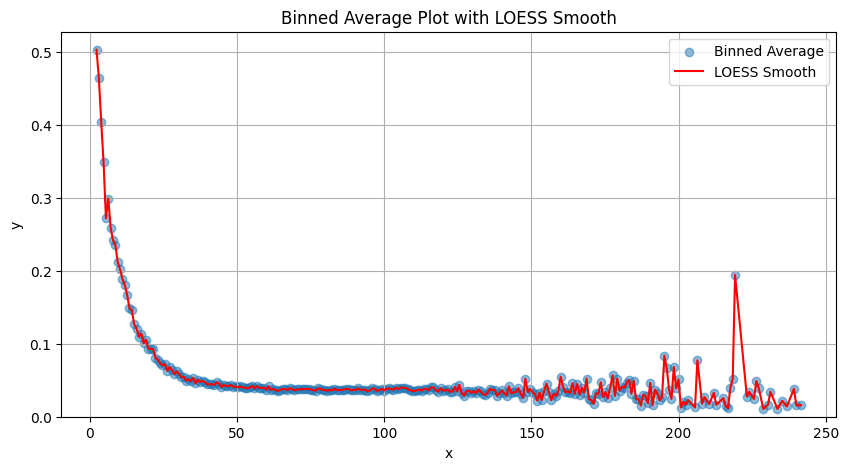

In [7]:
spatial_visualizer.plot_distance_scaler(rank_or_distance="distance",proportion_or_abs="abs",target_gene=None,bins=300, frac=0.003)

### The averaged abs value of interaction strength v.s. the order of nearest neighbor targeting gene "RORB"

loss: tensor(0.1442)
random: tensor(0.1755)
first 5: tensor(0.1662)
first 10: tensor(0.1616)
first 20: tensor(0.1548)


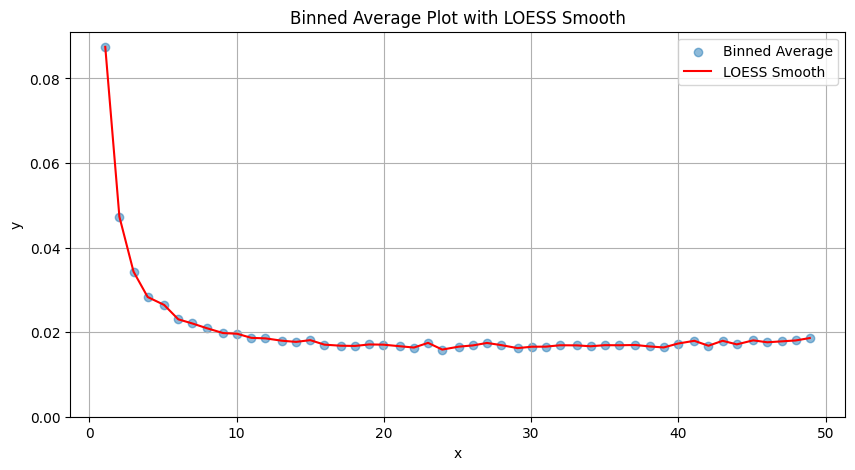

In [8]:
spatial_visualizer.plot_distance_scaler(rank_or_distance="rank",proportion_or_abs="proportion",target_gene='Rorb',bins=300, frac=0.003)

## UMAP visualization of function of CCI pairs

Visualizing the functions of CCI pairs using UMAP: the pair of one sender cell influencing one receiver cell is called a CCI pair, and the estimated influence from the sender cell to the receiver cell (how much the gene expression in the receiver cell would change because of the existing of the sender cell) are treated as the features of the CCI pair. This function aim to visualize how different CCI pairs belonging to different cell type combinations differ from each other in terms of their functions

:param `select_topk`: For each receiver cell, how many strongest CCI pair should be selected for visualize
            one point on the UMAP is one CCI pair, default to 5
            
:param `num_type_pair`: How many most frequent CCI type pair combination to show, since we can not demonstrate all cell_type_number*cell_type_number cell type combinations, there are too many colors, default to 10.

number of cell types in this sample: (array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Micro', 'OPC',
       'Oligo', 'PVM', 'Peri', 'Pvalb', 'SMC', 'Sncg', 'Sst', 'VLMC',
       'Vip', 'other'], dtype='<U10'), array([502, 473, 757, 848, 127, 427,  47, 650, 332,  32,  93,  60, 166,
       121, 551,  91, 172, 162,  89,   6,  73, 180,  50, 128]))
selecting edge types: ['L6 IT->L6 CT' 'L2/3 IT->L4/5 IT' 'L4/5 IT->L2/3 IT' 'L5 IT->L6 CT'
 'Astro->L2/3 IT' 'Astro->Oligo' 'L6 CT->L6 IT' 'Pvalb->L4/5 IT'
 'L5 ET->L5 IT' 'L5 IT->L4/5 IT']


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/gitiii/spatial_visualizer.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag = [adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


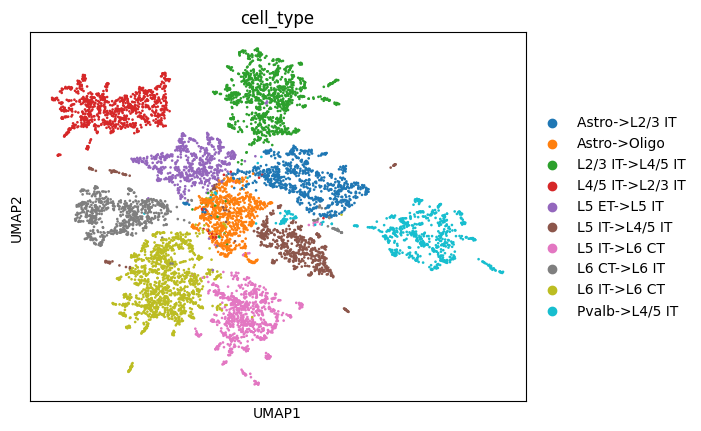

selecting edge types: ['L6 IT->L6 CT' 'L2/3 IT->L4/5 IT' 'L4/5 IT->L2/3 IT' 'L5 IT->L6 CT'
 'Astro->L2/3 IT' 'Astro->Oligo' 'L6 CT->L6 IT' 'Pvalb->L4/5 IT'
 'L5 ET->L5 IT' 'L5 IT->L4/5 IT']


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/gitiii/spatial_visualizer.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag = [adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


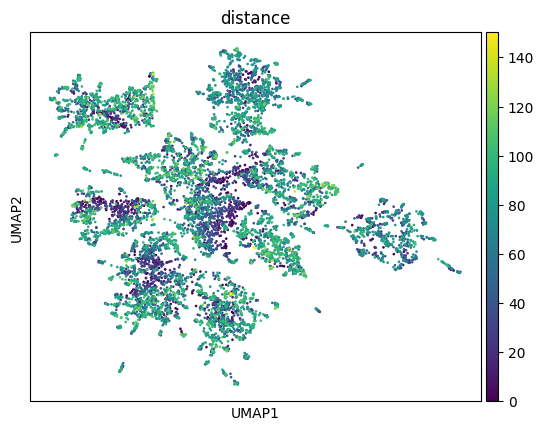

In [9]:
spatial_visualizer.visualize_CCI_function(select_topk=5,num_type_pair=10)

## Prediction visualization

Visualize the predicted cell expression v.s. predicted expression, can be state expression (have negative values) or raw expression (>0)

Now plotting predicted expression v.s. real expression


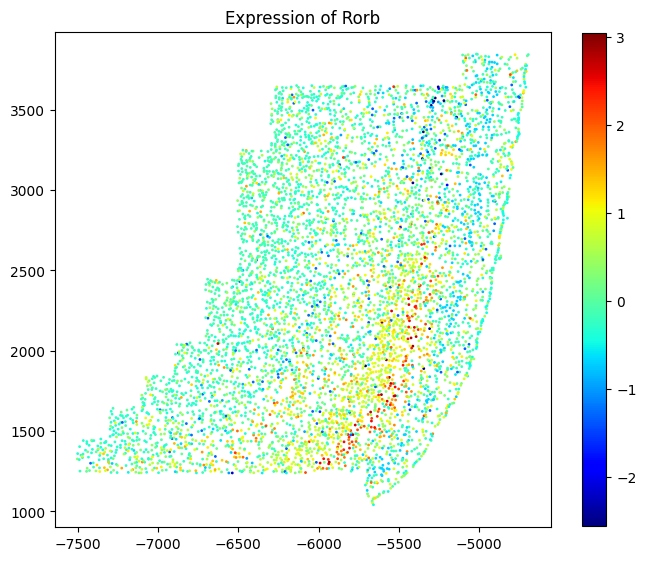

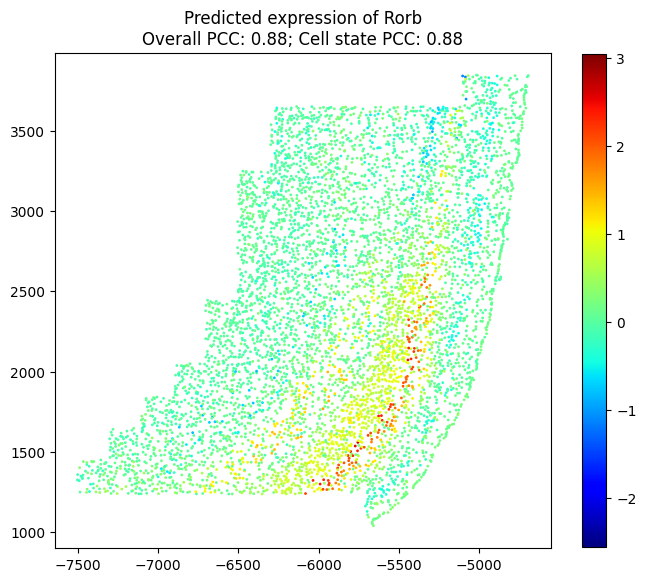

In [10]:
# Plot predicted expression (predicted cell state expression plus known cell type expression) v.s. real expression
spatial_visualizer.visualize_prediction(target_gene='Rorb',plot_state=False)

Now plotting predicted cell state expression v.s. real cell state expression


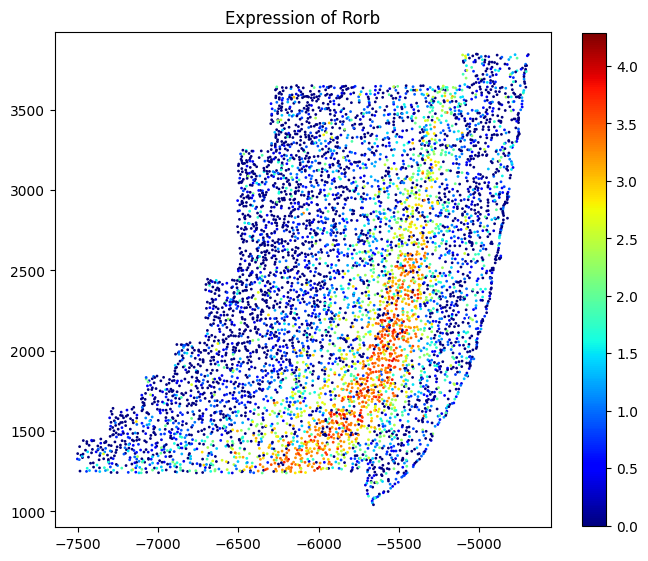

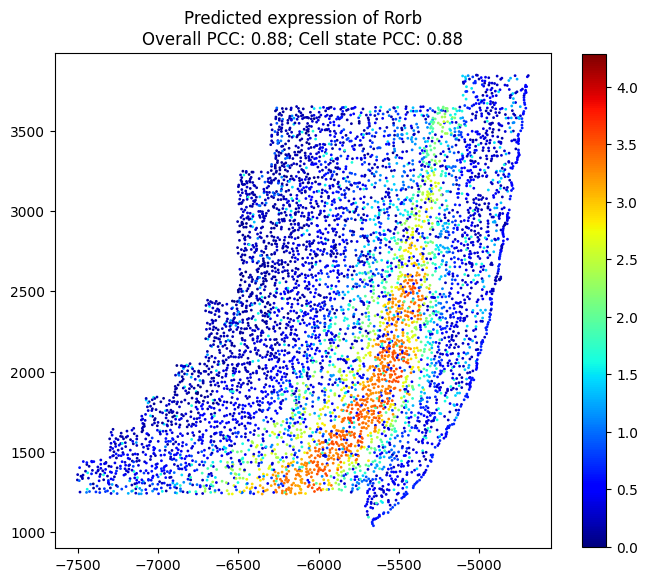

In [11]:
# Plot predicted cell state expression v.s. real cell state expression
spatial_visualizer.visualize_prediction(target_gene='Rorb',plot_state=True)

## Information flow visualization
We want to find where are the strongest CCI pairs in the slide (tissue section), with arrows in the plot indicating the interaction from one sender cell to one receiver cell

:param target_gene: the information flow with respect to which gene you would like to visualized

:param select_topk: similar as before

:param use_neuron_layer: In the plot, whether to generalize the cell types to only excitatory neurons at
            different layers and Not_excitatory_neuron, by doing this, the plot may just look more layer-organized.
            
:param cutoff: In percentage, how many top CCI pairs out of select_topk*number_of_cell pairs to visualize.

number of cell types in this sample: (array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Micro', 'OPC',
       'Oligo', 'PVM', 'Peri', 'Pvalb', 'SMC', 'Sncg', 'Sst', 'VLMC',
       'Vip', 'other'], dtype='<U10'), array([502, 473, 757, 848, 127, 427,  47, 650, 332,  32,  93,  60, 166,
       121, 551,  91, 172, 162,  89,   6,  73, 180,  50, 128]))


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/gitiii/spatial_visualizer.py:321: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  from_x = from_x[flag]
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/gitiii/spatial_visualizer.py:322: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  from_y = from_y[flag]
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/gitiii/spatial_visualizer.py:323: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

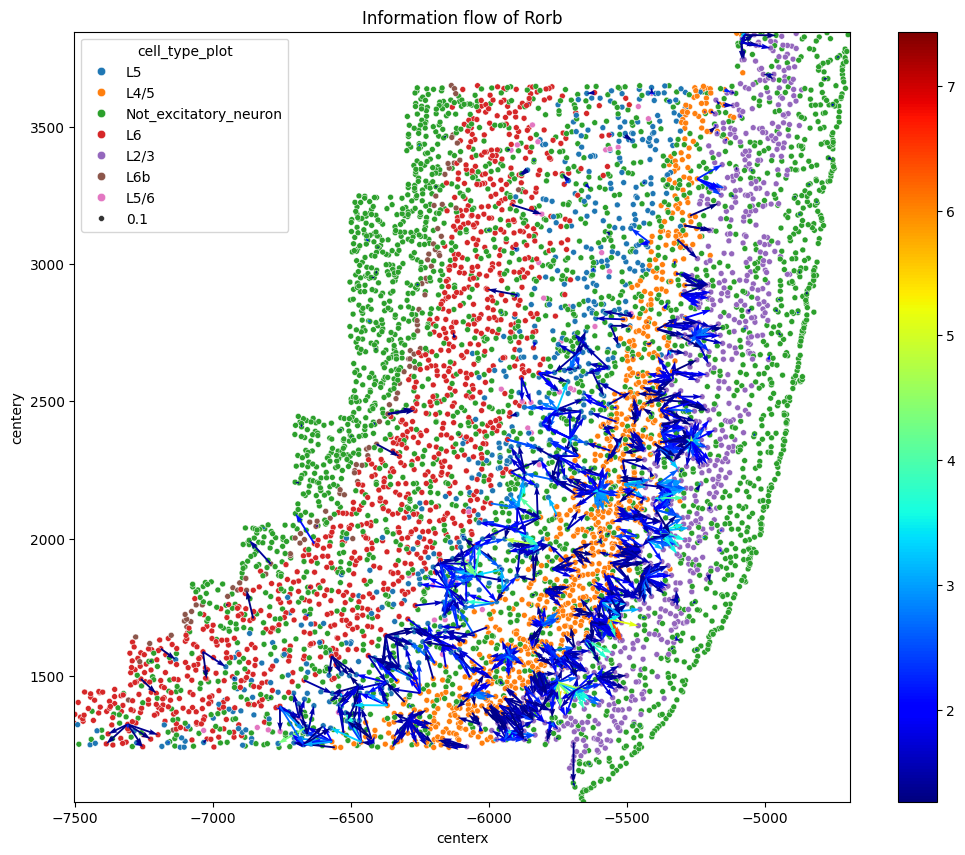

In [12]:
spatial_visualizer.visualize_information_flow(target_gene='Rorb',select_topk=5,use_neuron_layer=True,cutoff=0.05)

# Cell subtyping analysis

We first construct interpretable CCI-informed features for each cell, (how each cell type influence each measured genes in this cell), use these features to do Leiden clustering and UMAP visualization. Then differential expressed gene (DEG) analysis can be performed on these subtypes (subgroups), and we can also visualize how this cell ('s one target gene) is influenced by other cell types via heatmap.

:param `sample`: which tissue slide to analyze

---

**You can tune the following hyperparameter to get a good subtyping results that you may want to see, different methods vary a lot**

:param `normalize_to_1`: whether normalize the aggregated influence tensor so that their abs value sum
        up to one on the second dimension, default True
        
:param `use_abs`: whehter to use the absolute value for the aggregated influence tensor for downstream
        analysis, default True
        
:param `noise_threshold`: For values in the influence tensor, if its corresponding proportional influence is less than this threshold,
        we would treat it as noise, ignore it by setting it to 0, default to 0.02.

Start loading data


Finish loading data


Start aggregating
0 / 6137


500 / 6137


1000 / 6137


1500 / 6137


2000 / 6137


2500 / 6137


3000 / 6137


3500 / 6137


4000 / 6137


4500 / 6137


5000 / 6137


5500 / 6137


6000 / 6137
Finish aggregating


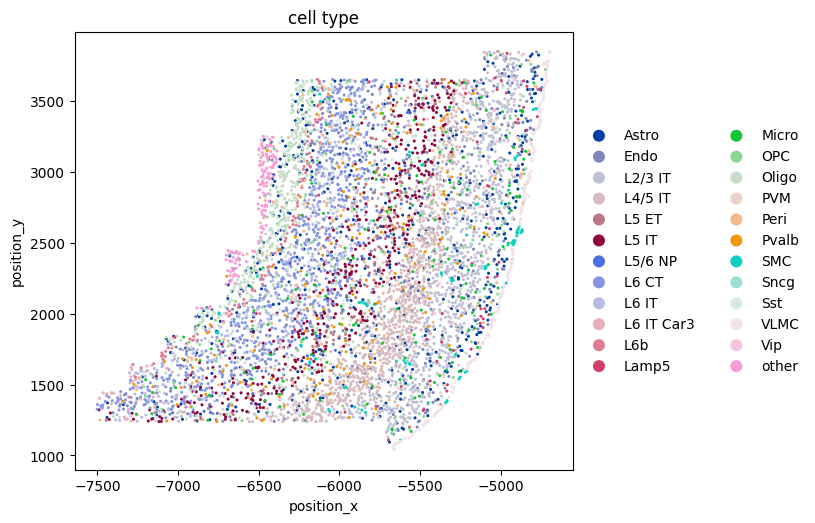

In [13]:
subtyping_analyzer=gitiii.subtyping_analyzer.Subtyping_anlayzer(sample=sample,normalize_to_1=True,use_abs=True,noise_threshold=2e-2)

/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/gitiii/subtyping_analyzer.py:154: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(self.adata_type, resolution=resolution)  # or sc.tl.louvain(adata)


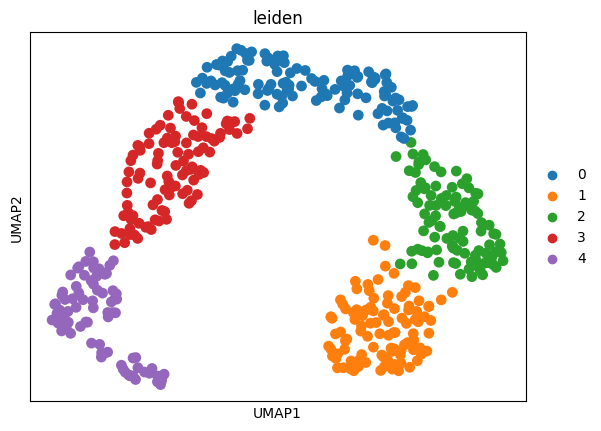

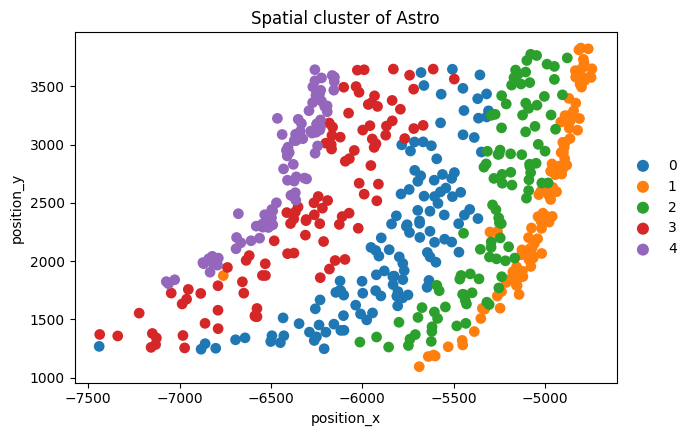

In [14]:
# Take L2/3 IT as an example for CCI informed subtyping analysis
COI="Astro" # Cell Of Interest
subtyping_analyzer.subtyping(COI=COI,resolution=0.3)

## Differential expressed gene analysis for the subgroups

function: subtyping_filter_groups(group_to_remain):

:param `group_to_remain`: list of str, for example, if you want to just analyze or compare the
            0-the group and 1-th group, as shown on the UMAP in subtyping analysis, you can make
            group_to_remain=\["1","0"\], be aware that the items in the list are not int, they are str

function: subtyping_DE(method='wilcoxon',n_gene_show=5)

:param `method`: statistical method to make comparison using scanpy, default to 'wilcoxon' (rank-sum test), other available methods are: 'logreg', 't-test', 'wilcoxon', 't-test_overestim_var'

:param `n_gene_show`: how many DE gene to plot for one subgroup, default to 5

/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 254 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


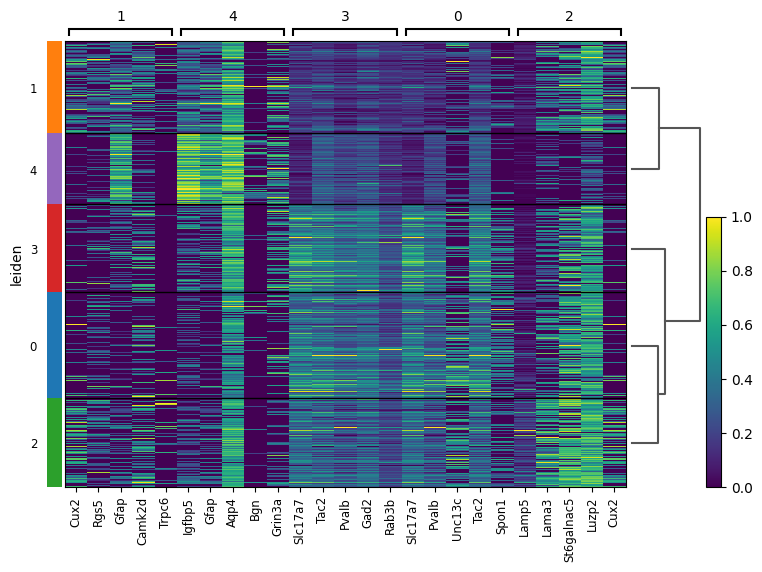

In [15]:
# We only want to compare the subgroup 0 and subgroup 1, so we do this
subtyping_analyzer.subtyping_filter_groups(["0","1","2","3","4"])

subtyping_analyzer.subtyping_DE()

# You can visualize the spatial gene expression patterns of the selected subgroups by:
# subtyping_analyzer.visualize_spatial_gene_expression("rorb")

## Analyze, proportionally, how each cell in each subgroup influenced by other cell types

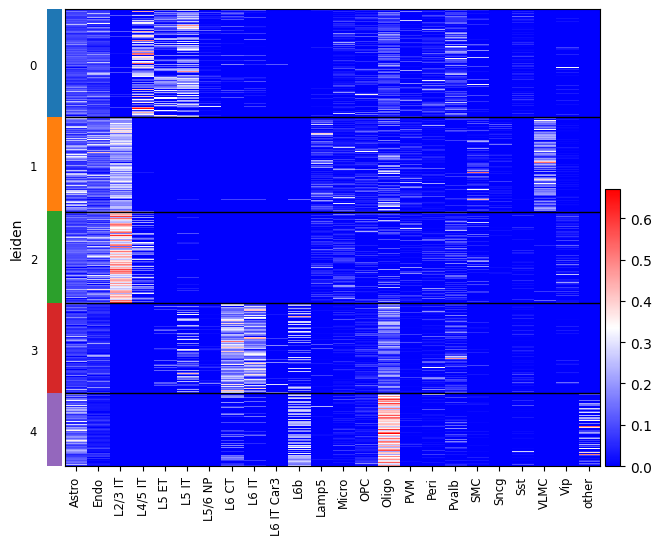

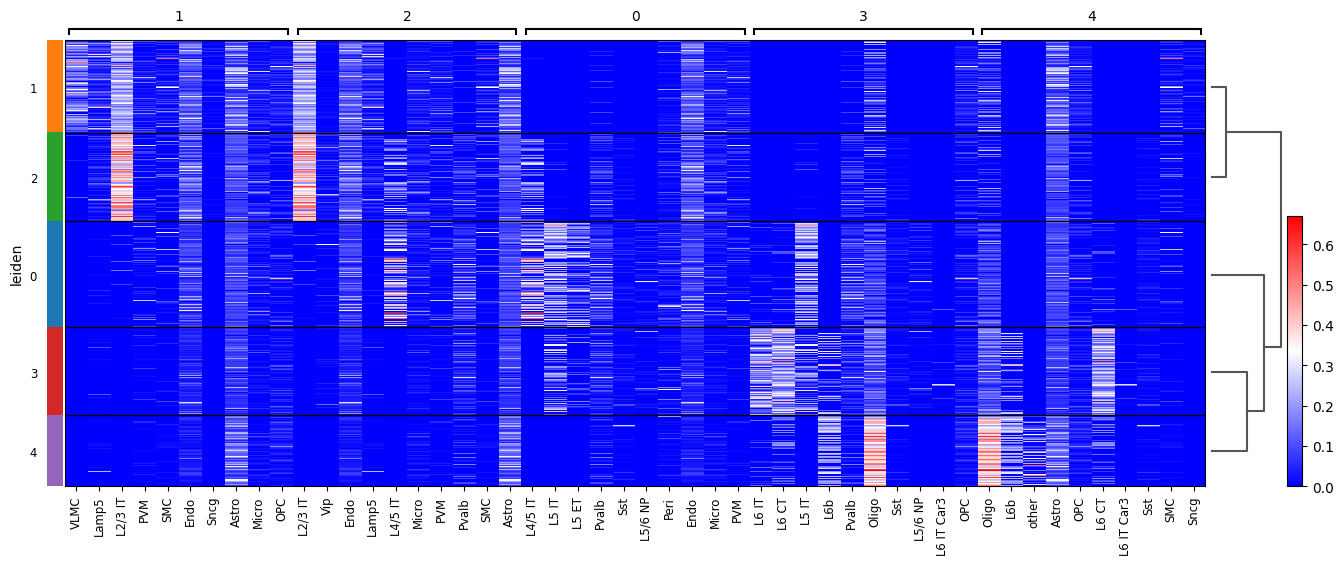

In [16]:
subtyping_analyzer.subtyping_get_aggregated_influence()

Or, if we just want to look at the proportional influence targeting one gene, like 'Rorb'.

And if you also want to know if it is up-regulated or down-regulated by other cell types, be sure to have use_abs=True in subtyping_analyzer=gitiii.subtyping_analyzer.Subtyping_anlayzer

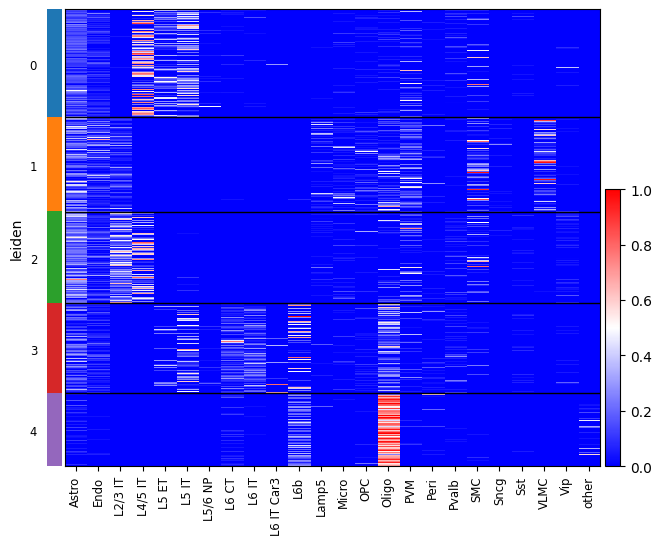

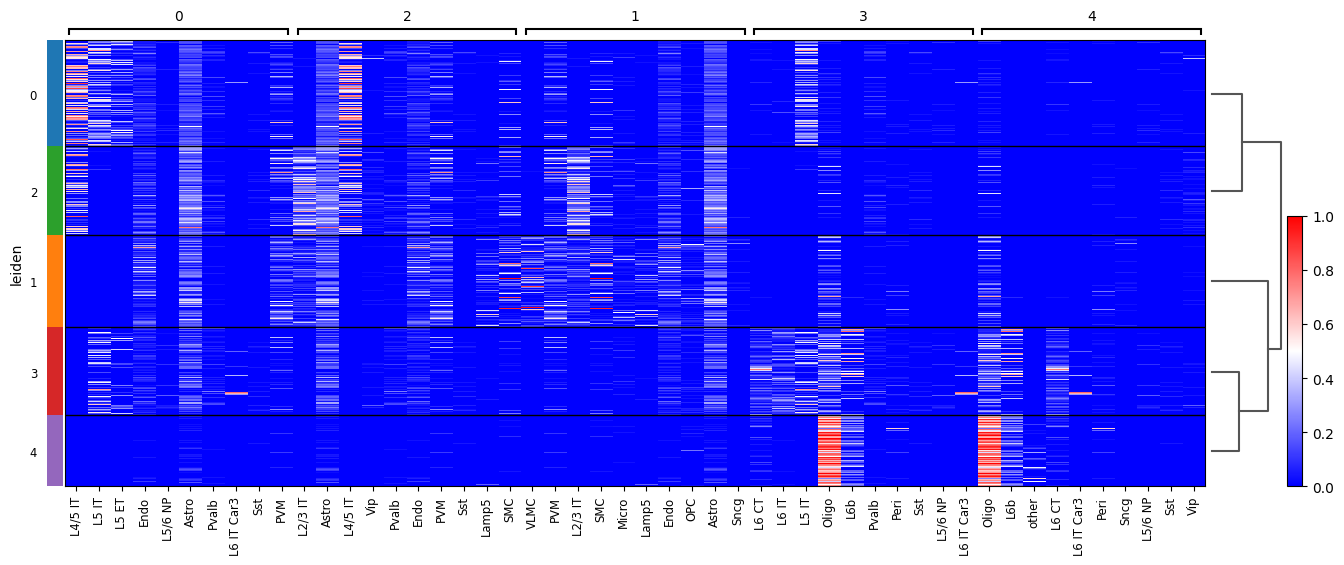

In [17]:
subtyping_analyzer.subtyping_get_aggregated_influence_target_gene(target_gene='Gfap')

# Network analysis

Using partial linear regression to make statistical test of whether one cell type significantly influence one gene in the receiver cell type, forming a significant CCI network targeting each gene.

:param `noise_threshold`: For values in the influence tensor, if its corresponding proportional influence is less than this threshold,
        we would treat it as noise, ignore it by setting it to 0, default to 0.02

In [18]:
network_analyzer=gitiii.network_analyzer.Network_analyzer(noise_threshold=2e-2)

Start loading data
Finish loading data


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/gitiii/network_analyzer.py:59: UserWarning: Network visualization is performed using R, this function only calculate the z-score matrix of significant CCI network for each sample
  warnings.warn("Network visualization is performed using R, "


## Calculate the z-scores for the significant CCI network for one sample

In [19]:
network_analyzer.determine_network_sample(sample=sample)

array([[-1.10401344,  1.32326102, -0.23916619, ..., -9.0131979 ,
        -0.74210149, -4.22649431],
       [-0.19181226, -0.22260191,  4.48898315, ..., -6.67128515,
        -2.12997198, -0.50031   ],
       [ 0.82110709, -1.1464951 ,  0.65447658, ..., -2.90793419,
        -1.1337589 , -1.79155827],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.84936684,  1.28730607, -0.38773689, ...,  1.33601344,
         0.614564  ,  0.25626367]])